## References:
1. https://www.analyticsvidhya.com/blog/2021/06/music-genres-classification-using-deep-learning-techniques/
2. https://data-flair.training/blogs/python-project-music-genre-classification/
3. https://blog.clairvoyantsoft.com/music-genre-classification-using-cnn-ef9461553726
4. https://github.com/AmbarZaidi/Audio-Genre-Classification
5. https://github.com/noahunallar/music-genre-recognition-using-neural-networks-and-k-means

### Papers

1)
Automatic Musical Genre Classification Of Audio Signals
http://ismir2001.ismir.net/pdf/tzanetakis.pdf 

2) Feature Extraction for Musical Genre Classification (2015 ) with reference to 1 
http://hpac.rwth-aachen.de/teaching/sem-mus-15/reports/Merkelbach.pdf

3) SONG-LEVEL FEATURES AND SUPPORT VECTOR MACHINES FOR MUSIC CLASSIFICATION
https://www.ee.columbia.edu/~dpwe/pubs/ismir05-svm.pdf

4) Music Genre Classification
http://cs229.stanford.edu/proj2011/HaggbladeHongKao-MusicGenreClassification.pdf

### Libraries

python_speech_features
http://python-speech-features.readthedocs.io/en/latest/
https://github.com/jameslyons/python_speech_features


MFCC tutorial
http://webcache.googleusercontent.com/search?q=cache:BlLUHkdAU_IJ:practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/+&cd=1&hl=en&ct=clnk&gl=in
http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/


Reading the signal 
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html

Hamming Window
https://docs.scipy.org/doc/numpy/reference/generated/numpy.hamming.html


## Some Findings 

- **Librosa** Library is to convert the music to the **spectograms**. Each music file will be one a spectogram
- The **Wavelet** Transform is a transformation that can be used to analyze the spectral and temporal properties of non-stationary signals like audio. **Librosa** library is to generate wavelets of each audio file.
- Also librosa.display will help to display 

### Comments by the already used methods 
- We train our CNN model for 500 epochs with Adam optimizer at a learning rate of 0.0001. We use categorical cross-entropy as the loss function [1]

### Small Discussion



## Libraries 

In [1]:
import scipy.io.wavfile as wav
from tensorflow import keras 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.axes as axt
from python_speech_features import mfcc
import pandas as pd
import numpy as np
from tempfile import TemporaryFile
import librosa, librosa.display
import json
import os
import math
import pickle
import random
import operator
import subprocess
from pydub.playback import play
from pydub import AudioSegment
from os import walk, listdir, chdir
from os.path import isfile, join
import scipy.io.wavfile as wav

In [2]:
wav_path = "./Data/genres_original/blues/blues.00000.wav"
signal, sr = librosa.load(wav_path, sr = 22050) #sr is sample rate, signal is 1D array, it is 20050 rates * 30 seconds
print(sr)

22050


In [7]:
print(signal)

[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]


### Time Domain

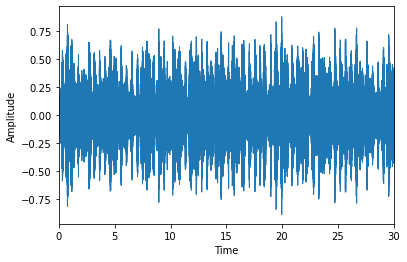

In [8]:
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Frequency Domain (Fast Fourier Transform)

In [9]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft) # indication of contribution of each frequency to the overall sound
frequency = np.linspace(0, sr, len(magnitude)) #gives a number of evenly spaced numbers in an interval. 
# Frequency interval is here 0 HZ and sample rate. Number of evenly paced values we want which is the length of magnitude


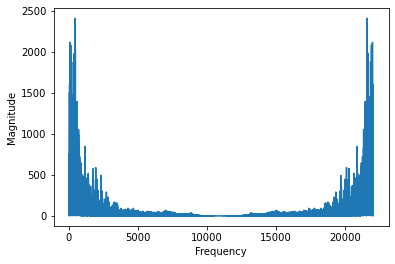

In [10]:
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### Interpretation
The first half of this is what brings us the novelty, the second half is the same information with the first half. Let's handle it by dividing it by two. 

In [11]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

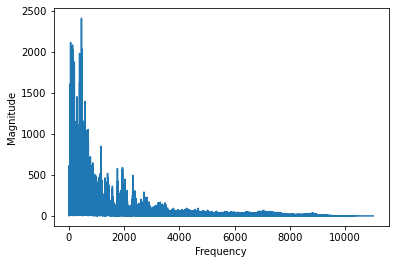

In [12]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [13]:
#number of samples per fft  (number of samples, window we're considering for performing a single fft)
n_fft = 2048
#amount we're shifting each fourier transform to the right. When we doSTFT we slide an interval, 
#each interval we calculate a fft and hop_length will tell us how much we're shifting
hop_length = 512


In [14]:
stft = librosa.core.stft(signal, hop_length = hop_length, n_fft = n_fft)
spectogram = np.abs(stft)

In [15]:
log_spectogram = librosa.amplitude_to_db(spectogram)

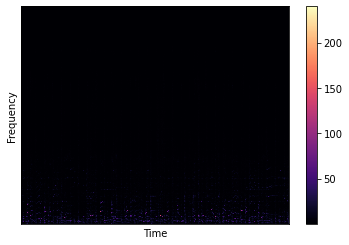

In [16]:
librosa.display.specshow(spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

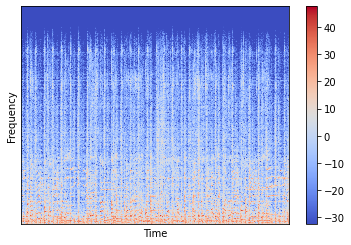

In [17]:
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

### MFFCs (Mel Frequency Cepstral Coefficients)

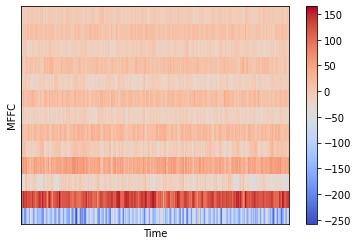

In [18]:
MFFCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFFC")
plt.colorbar()
plt.show()

### Preprocessing 
Extracting data from music dataset and writing to JSON 

In [8]:
DATASET_PATH = "./Data/genres_original"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [14]:
#num_segments is needed for NN, which needs chunks of data, rather than one full segment. 

def save_mfcc(dataset_path, json_path, num_mfcc = 13, n_fft = 2048, hop_length = 512, num_segments = 10):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }
    #overall number of samples per track 
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) # 22050 * 30 / 10 
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/hop_length) #calculating mfcc by the hop_length (fourier shifting) and we need to ceil the value
    print(expected_num_mfcc_vectors_per_segment)
    #looping through all the genres and 
    #dirpath - current, dirnames - subfolders, filenames - all file names 
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not att he root level
        if dirpath is not dataset_path:
            
            #save the semantic label, save the semantic (genre) levels
            dirpath_components = dirpath.split("/") #genre/blues will give us ["genre_original", "blues"]
            semantic_label = dirpath_components[-1] #consider the last, which is blues 
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))
            
            # process files for a specific genre
            for f in filenames: 
                print(f)
                #load audio file
                file_path = os.path.join(dirpath, f) #file path for the audio file 
                if not file_path.endswith('.DS_Store'):
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process segments extracting mfcc and storing data 
                    for s in range(num_segments):
                        start_sample = num_samples_per_segment * s #s=0 -> 0
                        finish_sample = start_sample + num_samples_per_segment #s=0 -> num_samples_per_segment

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

                        mfcc = mfcc.T

                        # store mfcc for segment if it has the expected length 
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, s+1))

    with open(json_path, "w") as fp:
        json.dump(data,fp, indent=4)
                    


In [10]:
# TESTING

# file_path = '/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/genres_original_copy/blues/blues.00000.wav'

# data = {
#         "mapping": [],
#         "mfcc": [],
#         "labels": []
#     }

# num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) # 22050 * 30 / 10  
# num_mfcc = 13
# expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/hop_length) # # (22050 * 30) / (10 * 512 )


# signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
# num_segments = 1

# # process segments extracting mfcc and storing data 
# for s in range(num_segments):
#     start_sample = num_samples_per_segment * s #s=0 -> 0
#     finish_sample = start_sample + num_samples_per_segment #s=0 -> num_samples_per_segment

#     mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

#     mfcc = mfcc.T

#     # store mfcc for segment if it has the expected length 
#     if len(mfcc) == expected_num_mfcc_vectors_per_segment:
#         data["mfcc"].append(mfcc.tolist())
#         data["labels"].append(0)
#         print("{}, segment:{}".format(file_path, s+1))
        

        
# JSON_PATH = "data3.json"
# with open(JSON_PATH, "w") as fp:
#         json.dump(data,fp, indent=4)


In [11]:
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

130

Processing pop
pop.00027.wav
./Data/genres_original/pop/pop.00027.wav, segment:1
./Data/genres_original/pop/pop.00027.wav, segment:2
./Data/genres_original/pop/pop.00027.wav, segment:3
./Data/genres_original/pop/pop.00027.wav, segment:4
./Data/genres_original/pop/pop.00027.wav, segment:5
./Data/genres_original/pop/pop.00027.wav, segment:6
./Data/genres_original/pop/pop.00027.wav, segment:7
./Data/genres_original/pop/pop.00027.wav, segment:8
./Data/genres_original/pop/pop.00027.wav, segment:9
./Data/genres_original/pop/pop.00027.wav, segment:10
pop.00033.wav
./Data/genres_original/pop/pop.00033.wav, segment:1
./Data/genres_original/pop/pop.00033.wav, segment:2
./Data/genres_original/pop/pop.00033.wav, segment:3
./Data/genres_original/pop/pop.00033.wav, segment:4
./Data/genres_original/pop/pop.00033.wav, segment:5
./Data/genres_original/pop/pop.00033.wav, segment:6
./Data/genres_original/pop/pop.00033.wav, segment:7
./Data/genres_original/pop/pop.00033.wav, segment:8
./Data/genres_o

./Data/genres_original/pop/pop.00008.wav, segment:9
./Data/genres_original/pop/pop.00008.wav, segment:10
pop.00022.wav
./Data/genres_original/pop/pop.00022.wav, segment:1
./Data/genres_original/pop/pop.00022.wav, segment:2
./Data/genres_original/pop/pop.00022.wav, segment:3
./Data/genres_original/pop/pop.00022.wav, segment:4
./Data/genres_original/pop/pop.00022.wav, segment:5
./Data/genres_original/pop/pop.00022.wav, segment:6
./Data/genres_original/pop/pop.00022.wav, segment:7
./Data/genres_original/pop/pop.00022.wav, segment:8
./Data/genres_original/pop/pop.00022.wav, segment:9
./Data/genres_original/pop/pop.00022.wav, segment:10
pop.00036.wav
./Data/genres_original/pop/pop.00036.wav, segment:1
./Data/genres_original/pop/pop.00036.wav, segment:2
./Data/genres_original/pop/pop.00036.wav, segment:3
./Data/genres_original/pop/pop.00036.wav, segment:4
./Data/genres_original/pop/pop.00036.wav, segment:5
./Data/genres_original/pop/pop.00036.wav, segment:6
./Data/genres_original/pop/pop.000

./Data/genres_original/pop/pop.00085.wav, segment:6
./Data/genres_original/pop/pop.00085.wav, segment:7
./Data/genres_original/pop/pop.00085.wav, segment:8
./Data/genres_original/pop/pop.00085.wav, segment:9
./Data/genres_original/pop/pop.00085.wav, segment:10
pop.00091.wav
./Data/genres_original/pop/pop.00091.wav, segment:1
./Data/genres_original/pop/pop.00091.wav, segment:2
./Data/genres_original/pop/pop.00091.wav, segment:3
./Data/genres_original/pop/pop.00091.wav, segment:4
./Data/genres_original/pop/pop.00091.wav, segment:5
./Data/genres_original/pop/pop.00091.wav, segment:6
./Data/genres_original/pop/pop.00091.wav, segment:7
./Data/genres_original/pop/pop.00091.wav, segment:8
./Data/genres_original/pop/pop.00091.wav, segment:9
./Data/genres_original/pop/pop.00091.wav, segment:10
pop.00046.wav
./Data/genres_original/pop/pop.00046.wav, segment:1
./Data/genres_original/pop/pop.00046.wav, segment:2
./Data/genres_original/pop/pop.00046.wav, segment:3
./Data/genres_original/pop/pop.000

./Data/genres_original/pop/pop.00097.wav, segment:7
./Data/genres_original/pop/pop.00097.wav, segment:8
./Data/genres_original/pop/pop.00097.wav, segment:9
./Data/genres_original/pop/pop.00097.wav, segment:10
pop.00083.wav
./Data/genres_original/pop/pop.00083.wav, segment:1
./Data/genres_original/pop/pop.00083.wav, segment:2
./Data/genres_original/pop/pop.00083.wav, segment:3
./Data/genres_original/pop/pop.00083.wav, segment:4
./Data/genres_original/pop/pop.00083.wav, segment:5
./Data/genres_original/pop/pop.00083.wav, segment:6
./Data/genres_original/pop/pop.00083.wav, segment:7
./Data/genres_original/pop/pop.00083.wav, segment:8
./Data/genres_original/pop/pop.00083.wav, segment:9
./Data/genres_original/pop/pop.00083.wav, segment:10
pop.00054.wav
./Data/genres_original/pop/pop.00054.wav, segment:1
./Data/genres_original/pop/pop.00054.wav, segment:2
./Data/genres_original/pop/pop.00054.wav, segment:3
./Data/genres_original/pop/pop.00054.wav, segment:4
./Data/genres_original/pop/pop.000

./Data/genres_original/pop/pop.00063.wav, segment:1
./Data/genres_original/pop/pop.00063.wav, segment:2
./Data/genres_original/pop/pop.00063.wav, segment:3
./Data/genres_original/pop/pop.00063.wav, segment:4
./Data/genres_original/pop/pop.00063.wav, segment:5
./Data/genres_original/pop/pop.00063.wav, segment:6
./Data/genres_original/pop/pop.00063.wav, segment:7
./Data/genres_original/pop/pop.00063.wav, segment:8
./Data/genres_original/pop/pop.00063.wav, segment:9
./Data/genres_original/pop/pop.00063.wav, segment:10
pop.00088.wav
./Data/genres_original/pop/pop.00088.wav, segment:1
./Data/genres_original/pop/pop.00088.wav, segment:2
./Data/genres_original/pop/pop.00088.wav, segment:3
./Data/genres_original/pop/pop.00088.wav, segment:4
./Data/genres_original/pop/pop.00088.wav, segment:5
./Data/genres_original/pop/pop.00088.wav, segment:6
./Data/genres_original/pop/pop.00088.wav, segment:7
./Data/genres_original/pop/pop.00088.wav, segment:8
./Data/genres_original/pop/pop.00088.wav, segment

./Data/genres_original/pop/pop.00005.wav, segment:6
./Data/genres_original/pop/pop.00005.wav, segment:7
./Data/genres_original/pop/pop.00005.wav, segment:8
./Data/genres_original/pop/pop.00005.wav, segment:9
./Data/genres_original/pop/pop.00005.wav, segment:10
pop.00039.wav
./Data/genres_original/pop/pop.00039.wav, segment:1
./Data/genres_original/pop/pop.00039.wav, segment:2
./Data/genres_original/pop/pop.00039.wav, segment:3
./Data/genres_original/pop/pop.00039.wav, segment:4
./Data/genres_original/pop/pop.00039.wav, segment:5
./Data/genres_original/pop/pop.00039.wav, segment:6
./Data/genres_original/pop/pop.00039.wav, segment:7
./Data/genres_original/pop/pop.00039.wav, segment:8
./Data/genres_original/pop/pop.00039.wav, segment:9
./Data/genres_original/pop/pop.00039.wav, segment:10
pop.00038.wav
./Data/genres_original/pop/pop.00038.wav, segment:1
./Data/genres_original/pop/pop.00038.wav, segment:2
./Data/genres_original/pop/pop.00038.wav, segment:3
./Data/genres_original/pop/pop.000

./Data/genres_original/metal/metal.00023.wav, segment:2
./Data/genres_original/metal/metal.00023.wav, segment:3
./Data/genres_original/metal/metal.00023.wav, segment:4
./Data/genres_original/metal/metal.00023.wav, segment:5
./Data/genres_original/metal/metal.00023.wav, segment:6
./Data/genres_original/metal/metal.00023.wav, segment:7
./Data/genres_original/metal/metal.00023.wav, segment:8
./Data/genres_original/metal/metal.00023.wav, segment:9
./Data/genres_original/metal/metal.00023.wav, segment:10
metal.00009.wav
./Data/genres_original/metal/metal.00009.wav, segment:1
./Data/genres_original/metal/metal.00009.wav, segment:2
./Data/genres_original/metal/metal.00009.wav, segment:3
./Data/genres_original/metal/metal.00009.wav, segment:4
./Data/genres_original/metal/metal.00009.wav, segment:5
./Data/genres_original/metal/metal.00009.wav, segment:6
./Data/genres_original/metal/metal.00009.wav, segment:7
./Data/genres_original/metal/metal.00009.wav, segment:8
./Data/genres_original/metal/me

./Data/genres_original/metal/metal.00032.wav, segment:9
./Data/genres_original/metal/metal.00032.wav, segment:10
metal.00026.wav
./Data/genres_original/metal/metal.00026.wav, segment:1
./Data/genres_original/metal/metal.00026.wav, segment:2
./Data/genres_original/metal/metal.00026.wav, segment:3
./Data/genres_original/metal/metal.00026.wav, segment:4
./Data/genres_original/metal/metal.00026.wav, segment:5
./Data/genres_original/metal/metal.00026.wav, segment:6
./Data/genres_original/metal/metal.00026.wav, segment:7
./Data/genres_original/metal/metal.00026.wav, segment:8
./Data/genres_original/metal/metal.00026.wav, segment:9
./Data/genres_original/metal/metal.00026.wav, segment:10
metal.00082.wav
./Data/genres_original/metal/metal.00082.wav, segment:1
./Data/genres_original/metal/metal.00082.wav, segment:2
./Data/genres_original/metal/metal.00082.wav, segment:3
./Data/genres_original/metal/metal.00082.wav, segment:4
./Data/genres_original/metal/metal.00082.wav, segment:5
./Data/genres_

./Data/genres_original/metal/metal.00057.wav, segment:4
./Data/genres_original/metal/metal.00057.wav, segment:5
./Data/genres_original/metal/metal.00057.wav, segment:6
./Data/genres_original/metal/metal.00057.wav, segment:7
./Data/genres_original/metal/metal.00057.wav, segment:8
./Data/genres_original/metal/metal.00057.wav, segment:9
./Data/genres_original/metal/metal.00057.wav, segment:10
metal.00080.wav
./Data/genres_original/metal/metal.00080.wav, segment:1
./Data/genres_original/metal/metal.00080.wav, segment:2
./Data/genres_original/metal/metal.00080.wav, segment:3
./Data/genres_original/metal/metal.00080.wav, segment:4
./Data/genres_original/metal/metal.00080.wav, segment:5
./Data/genres_original/metal/metal.00080.wav, segment:6
./Data/genres_original/metal/metal.00080.wav, segment:7
./Data/genres_original/metal/metal.00080.wav, segment:8
./Data/genres_original/metal/metal.00080.wav, segment:9
./Data/genres_original/metal/metal.00080.wav, segment:10
metal.00094.wav
./Data/genres_

./Data/genres_original/metal/metal.00051.wav, segment:5
./Data/genres_original/metal/metal.00051.wav, segment:6
./Data/genres_original/metal/metal.00051.wav, segment:7
./Data/genres_original/metal/metal.00051.wav, segment:8
./Data/genres_original/metal/metal.00051.wav, segment:9
./Data/genres_original/metal/metal.00051.wav, segment:10
metal.00045.wav
./Data/genres_original/metal/metal.00045.wav, segment:1
./Data/genres_original/metal/metal.00045.wav, segment:2
./Data/genres_original/metal/metal.00045.wav, segment:3
./Data/genres_original/metal/metal.00045.wav, segment:4
./Data/genres_original/metal/metal.00045.wav, segment:5
./Data/genres_original/metal/metal.00045.wav, segment:6
./Data/genres_original/metal/metal.00045.wav, segment:7
./Data/genres_original/metal/metal.00045.wav, segment:8
./Data/genres_original/metal/metal.00045.wav, segment:9
./Data/genres_original/metal/metal.00045.wav, segment:10
metal.00092.wav
./Data/genres_original/metal/metal.00092.wav, segment:1
./Data/genres_

./Data/genres_original/metal/metal.00099.wav, segment:4
./Data/genres_original/metal/metal.00099.wav, segment:5
./Data/genres_original/metal/metal.00099.wav, segment:6
./Data/genres_original/metal/metal.00099.wav, segment:7
./Data/genres_original/metal/metal.00099.wav, segment:8
./Data/genres_original/metal/metal.00099.wav, segment:9
./Data/genres_original/metal/metal.00099.wav, segment:10
metal.00072.wav
./Data/genres_original/metal/metal.00072.wav, segment:1
./Data/genres_original/metal/metal.00072.wav, segment:2
./Data/genres_original/metal/metal.00072.wav, segment:3
./Data/genres_original/metal/metal.00072.wav, segment:4
./Data/genres_original/metal/metal.00072.wav, segment:5
./Data/genres_original/metal/metal.00072.wav, segment:6
./Data/genres_original/metal/metal.00072.wav, segment:7
./Data/genres_original/metal/metal.00072.wav, segment:8
./Data/genres_original/metal/metal.00072.wav, segment:9
./Data/genres_original/metal/metal.00072.wav, segment:10
metal.00066.wav
./Data/genres_

./Data/genres_original/metal/metal.00014.wav, segment:5
./Data/genres_original/metal/metal.00014.wav, segment:6
./Data/genres_original/metal/metal.00014.wav, segment:7
./Data/genres_original/metal/metal.00014.wav, segment:8
./Data/genres_original/metal/metal.00014.wav, segment:9
./Data/genres_original/metal/metal.00014.wav, segment:10
metal.00000.wav
./Data/genres_original/metal/metal.00000.wav, segment:1
./Data/genres_original/metal/metal.00000.wav, segment:2
./Data/genres_original/metal/metal.00000.wav, segment:3
./Data/genres_original/metal/metal.00000.wav, segment:4
./Data/genres_original/metal/metal.00000.wav, segment:5
./Data/genres_original/metal/metal.00000.wav, segment:6
./Data/genres_original/metal/metal.00000.wav, segment:7
./Data/genres_original/metal/metal.00000.wav, segment:8
./Data/genres_original/metal/metal.00000.wav, segment:9
./Data/genres_original/metal/metal.00000.wav, segment:10
metal.00001.wav
./Data/genres_original/metal/metal.00001.wav, segment:1
./Data/genres_

./Data/genres_original/disco/disco.00091.wav, segment:6
./Data/genres_original/disco/disco.00091.wav, segment:7
./Data/genres_original/disco/disco.00091.wav, segment:8
./Data/genres_original/disco/disco.00091.wav, segment:9
./Data/genres_original/disco/disco.00091.wav, segment:10
disco.00085.wav
./Data/genres_original/disco/disco.00085.wav, segment:1
./Data/genres_original/disco/disco.00085.wav, segment:2
./Data/genres_original/disco/disco.00085.wav, segment:3
./Data/genres_original/disco/disco.00085.wav, segment:4
./Data/genres_original/disco/disco.00085.wav, segment:5
./Data/genres_original/disco/disco.00085.wav, segment:6
./Data/genres_original/disco/disco.00085.wav, segment:7
./Data/genres_original/disco/disco.00085.wav, segment:8
./Data/genres_original/disco/disco.00085.wav, segment:9
./Data/genres_original/disco/disco.00085.wav, segment:10
disco.00084.wav
./Data/genres_original/disco/disco.00084.wav, segment:1
./Data/genres_original/disco/disco.00084.wav, segment:2
./Data/genres_

./Data/genres_original/disco/disco.00040.wav, segment:7
./Data/genres_original/disco/disco.00040.wav, segment:8
./Data/genres_original/disco/disco.00040.wav, segment:9
./Data/genres_original/disco/disco.00040.wav, segment:10
disco.00054.wav
./Data/genres_original/disco/disco.00054.wav, segment:1
./Data/genres_original/disco/disco.00054.wav, segment:2
./Data/genres_original/disco/disco.00054.wav, segment:3
./Data/genres_original/disco/disco.00054.wav, segment:4
./Data/genres_original/disco/disco.00054.wav, segment:5
./Data/genres_original/disco/disco.00054.wav, segment:6
./Data/genres_original/disco/disco.00054.wav, segment:7
./Data/genres_original/disco/disco.00054.wav, segment:8
./Data/genres_original/disco/disco.00054.wav, segment:9
./Data/genres_original/disco/disco.00054.wav, segment:10
disco.00083.wav
./Data/genres_original/disco/disco.00083.wav, segment:1
./Data/genres_original/disco/disco.00083.wav, segment:2
./Data/genres_original/disco/disco.00083.wav, segment:3
./Data/genres_

./Data/genres_original/disco/disco.00056.wav, segment:7
./Data/genres_original/disco/disco.00056.wav, segment:8
./Data/genres_original/disco/disco.00056.wav, segment:9
./Data/genres_original/disco/disco.00056.wav, segment:10
disco.00031.wav
./Data/genres_original/disco/disco.00031.wav, segment:1
./Data/genres_original/disco/disco.00031.wav, segment:2
./Data/genres_original/disco/disco.00031.wav, segment:3
./Data/genres_original/disco/disco.00031.wav, segment:4
./Data/genres_original/disco/disco.00031.wav, segment:5
./Data/genres_original/disco/disco.00031.wav, segment:6
./Data/genres_original/disco/disco.00031.wav, segment:7
./Data/genres_original/disco/disco.00031.wav, segment:8
./Data/genres_original/disco/disco.00031.wav, segment:9
./Data/genres_original/disco/disco.00031.wav, segment:10
disco.00025.wav
./Data/genres_original/disco/disco.00025.wav, segment:1
./Data/genres_original/disco/disco.00025.wav, segment:2
./Data/genres_original/disco/disco.00025.wav, segment:3
./Data/genres_

./Data/genres_original/disco/disco.00034.wav, segment:8
./Data/genres_original/disco/disco.00034.wav, segment:9
./Data/genres_original/disco/disco.00034.wav, segment:10
disco.00020.wav
./Data/genres_original/disco/disco.00020.wav, segment:1
./Data/genres_original/disco/disco.00020.wav, segment:2
./Data/genres_original/disco/disco.00020.wav, segment:3
./Data/genres_original/disco/disco.00020.wav, segment:4
./Data/genres_original/disco/disco.00020.wav, segment:5
./Data/genres_original/disco/disco.00020.wav, segment:6
./Data/genres_original/disco/disco.00020.wav, segment:7
./Data/genres_original/disco/disco.00020.wav, segment:8
./Data/genres_original/disco/disco.00020.wav, segment:9
./Data/genres_original/disco/disco.00020.wav, segment:10
disco.00021.wav
./Data/genres_original/disco/disco.00021.wav, segment:1
./Data/genres_original/disco/disco.00021.wav, segment:2
./Data/genres_original/disco/disco.00021.wav, segment:3
./Data/genres_original/disco/disco.00021.wav, segment:4
./Data/genres_

./Data/genres_original/disco/disco.00016.wav, segment:4
./Data/genres_original/disco/disco.00016.wav, segment:5
./Data/genres_original/disco/disco.00016.wav, segment:6
./Data/genres_original/disco/disco.00016.wav, segment:7
./Data/genres_original/disco/disco.00016.wav, segment:8
./Data/genres_original/disco/disco.00016.wav, segment:9
./Data/genres_original/disco/disco.00016.wav, segment:10
disco.00017.wav
./Data/genres_original/disco/disco.00017.wav, segment:1
./Data/genres_original/disco/disco.00017.wav, segment:2
./Data/genres_original/disco/disco.00017.wav, segment:3
./Data/genres_original/disco/disco.00017.wav, segment:4
./Data/genres_original/disco/disco.00017.wav, segment:5
./Data/genres_original/disco/disco.00017.wav, segment:6
./Data/genres_original/disco/disco.00017.wav, segment:7
./Data/genres_original/disco/disco.00017.wav, segment:8
./Data/genres_original/disco/disco.00017.wav, segment:9
./Data/genres_original/disco/disco.00017.wav, segment:10
disco.00003.wav
./Data/genres_

./Data/genres_original/disco/disco.00070.wav, segment:6
./Data/genres_original/disco/disco.00070.wav, segment:7
./Data/genres_original/disco/disco.00070.wav, segment:8
./Data/genres_original/disco/disco.00070.wav, segment:9
./Data/genres_original/disco/disco.00070.wav, segment:10
disco.00058.wav
./Data/genres_original/disco/disco.00058.wav, segment:1
./Data/genres_original/disco/disco.00058.wav, segment:2
./Data/genres_original/disco/disco.00058.wav, segment:3
./Data/genres_original/disco/disco.00058.wav, segment:4
./Data/genres_original/disco/disco.00058.wav, segment:5
./Data/genres_original/disco/disco.00058.wav, segment:6
./Data/genres_original/disco/disco.00058.wav, segment:7
./Data/genres_original/disco/disco.00058.wav, segment:8
./Data/genres_original/disco/disco.00058.wav, segment:9
./Data/genres_original/disco/disco.00058.wav, segment:10
disco.00059.wav
./Data/genres_original/disco/disco.00059.wav, segment:1
./Data/genres_original/disco/disco.00059.wav, segment:2
./Data/genres_

./Data/genres_original/disco/disco.00077.wav, segment:1
./Data/genres_original/disco/disco.00077.wav, segment:2
./Data/genres_original/disco/disco.00077.wav, segment:3
./Data/genres_original/disco/disco.00077.wav, segment:4
./Data/genres_original/disco/disco.00077.wav, segment:5
./Data/genres_original/disco/disco.00077.wav, segment:6
./Data/genres_original/disco/disco.00077.wav, segment:7
./Data/genres_original/disco/disco.00077.wav, segment:8
./Data/genres_original/disco/disco.00077.wav, segment:9
./Data/genres_original/disco/disco.00077.wav, segment:10

Processing  mugam
rock.00011.wav
./Data/genres_original/ mugam/rock.00011.wav, segment:1
./Data/genres_original/ mugam/rock.00011.wav, segment:2
./Data/genres_original/ mugam/rock.00011.wav, segment:3
./Data/genres_original/ mugam/rock.00011.wav, segment:4
./Data/genres_original/ mugam/rock.00011.wav, segment:5
./Data/genres_original/ mugam/rock.00011.wav, segment:6
./Data/genres_original/ mugam/rock.00011.wav, segment:7
./Data/genres

./Data/genres_original/ mugam/rock.00014.wav, segment:3
./Data/genres_original/ mugam/rock.00014.wav, segment:4
./Data/genres_original/ mugam/rock.00014.wav, segment:5
./Data/genres_original/ mugam/rock.00014.wav, segment:6
./Data/genres_original/ mugam/rock.00014.wav, segment:7
./Data/genres_original/ mugam/rock.00014.wav, segment:8
./Data/genres_original/ mugam/rock.00014.wav, segment:9
./Data/genres_original/ mugam/rock.00014.wav, segment:10
rock.00000.wav
./Data/genres_original/ mugam/rock.00000.wav, segment:1
./Data/genres_original/ mugam/rock.00000.wav, segment:2
./Data/genres_original/ mugam/rock.00000.wav, segment:3
./Data/genres_original/ mugam/rock.00000.wav, segment:4
./Data/genres_original/ mugam/rock.00000.wav, segment:5
./Data/genres_original/ mugam/rock.00000.wav, segment:6
./Data/genres_original/ mugam/rock.00000.wav, segment:7
./Data/genres_original/ mugam/rock.00000.wav, segment:8
./Data/genres_original/ mugam/rock.00000.wav, segment:9
./Data/genres_original/ mugam/ro

./Data/genres_original/ mugam/rock.00064.wav, segment:9
./Data/genres_original/ mugam/rock.00064.wav, segment:10
rock.00048.wav
./Data/genres_original/ mugam/rock.00048.wav, segment:1
./Data/genres_original/ mugam/rock.00048.wav, segment:2
./Data/genres_original/ mugam/rock.00048.wav, segment:3
./Data/genres_original/ mugam/rock.00048.wav, segment:4
./Data/genres_original/ mugam/rock.00048.wav, segment:5
./Data/genres_original/ mugam/rock.00048.wav, segment:6
./Data/genres_original/ mugam/rock.00048.wav, segment:7
./Data/genres_original/ mugam/rock.00048.wav, segment:8
./Data/genres_original/ mugam/rock.00048.wav, segment:9
./Data/genres_original/ mugam/rock.00048.wav, segment:10
rock.00060.wav
./Data/genres_original/ mugam/rock.00060.wav, segment:1
./Data/genres_original/ mugam/rock.00060.wav, segment:2
./Data/genres_original/ mugam/rock.00060.wav, segment:3
./Data/genres_original/ mugam/rock.00060.wav, segment:4
./Data/genres_original/ mugam/rock.00060.wav, segment:5
./Data/genres_or

./Data/genres_original/ mugam/rock.00047.wav, segment:3
./Data/genres_original/ mugam/rock.00047.wav, segment:4
./Data/genres_original/ mugam/rock.00047.wav, segment:5
./Data/genres_original/ mugam/rock.00047.wav, segment:6
./Data/genres_original/ mugam/rock.00047.wav, segment:7
./Data/genres_original/ mugam/rock.00047.wav, segment:8
./Data/genres_original/ mugam/rock.00047.wav, segment:9
./Data/genres_original/ mugam/rock.00047.wav, segment:10
rock.00046.wav
./Data/genres_original/ mugam/rock.00046.wav, segment:1
./Data/genres_original/ mugam/rock.00046.wav, segment:2
./Data/genres_original/ mugam/rock.00046.wav, segment:3
./Data/genres_original/ mugam/rock.00046.wav, segment:4
./Data/genres_original/ mugam/rock.00046.wav, segment:5
./Data/genres_original/ mugam/rock.00046.wav, segment:6
./Data/genres_original/ mugam/rock.00046.wav, segment:7
./Data/genres_original/ mugam/rock.00046.wav, segment:8
./Data/genres_original/ mugam/rock.00046.wav, segment:9
./Data/genres_original/ mugam/ro

./Data/genres_original/ mugam/rock.00069.wav, segment:6
./Data/genres_original/ mugam/rock.00069.wav, segment:7
./Data/genres_original/ mugam/rock.00069.wav, segment:8
./Data/genres_original/ mugam/rock.00069.wav, segment:9
./Data/genres_original/ mugam/rock.00069.wav, segment:10
rock.00041.wav
./Data/genres_original/ mugam/rock.00041.wav, segment:1
./Data/genres_original/ mugam/rock.00041.wav, segment:2
./Data/genres_original/ mugam/rock.00041.wav, segment:3
./Data/genres_original/ mugam/rock.00041.wav, segment:4
./Data/genres_original/ mugam/rock.00041.wav, segment:5
./Data/genres_original/ mugam/rock.00041.wav, segment:6
./Data/genres_original/ mugam/rock.00041.wav, segment:7
./Data/genres_original/ mugam/rock.00041.wav, segment:8
./Data/genres_original/ mugam/rock.00041.wav, segment:9
./Data/genres_original/ mugam/rock.00041.wav, segment:10
rock.00055.wav
./Data/genres_original/ mugam/rock.00055.wav, segment:1
./Data/genres_original/ mugam/rock.00055.wav, segment:2
./Data/genres_or

./Data/genres_original/ mugam/rock.00024.wav, segment:2
./Data/genres_original/ mugam/rock.00024.wav, segment:3
./Data/genres_original/ mugam/rock.00024.wav, segment:4
./Data/genres_original/ mugam/rock.00024.wav, segment:5
./Data/genres_original/ mugam/rock.00024.wav, segment:6
./Data/genres_original/ mugam/rock.00024.wav, segment:7
./Data/genres_original/ mugam/rock.00024.wav, segment:8
./Data/genres_original/ mugam/rock.00024.wav, segment:9
./Data/genres_original/ mugam/rock.00024.wav, segment:10
rock.00018.wav
./Data/genres_original/ mugam/rock.00018.wav, segment:1
./Data/genres_original/ mugam/rock.00018.wav, segment:2
./Data/genres_original/ mugam/rock.00018.wav, segment:3
./Data/genres_original/ mugam/rock.00018.wav, segment:4
./Data/genres_original/ mugam/rock.00018.wav, segment:5
./Data/genres_original/ mugam/rock.00018.wav, segment:6
./Data/genres_original/ mugam/rock.00018.wav, segment:7
./Data/genres_original/ mugam/rock.00018.wav, segment:8
./Data/genres_original/ mugam/ro

./Data/genres_original/ mugam/rock.00020.wav, segment:5
./Data/genres_original/ mugam/rock.00020.wav, segment:6
./Data/genres_original/ mugam/rock.00020.wav, segment:7
./Data/genres_original/ mugam/rock.00020.wav, segment:8
./Data/genres_original/ mugam/rock.00020.wav, segment:9
./Data/genres_original/ mugam/rock.00020.wav, segment:10
rock.00034.wav
./Data/genres_original/ mugam/rock.00034.wav, segment:1
./Data/genres_original/ mugam/rock.00034.wav, segment:2
./Data/genres_original/ mugam/rock.00034.wav, segment:3
./Data/genres_original/ mugam/rock.00034.wav, segment:4
./Data/genres_original/ mugam/rock.00034.wav, segment:5
./Data/genres_original/ mugam/rock.00034.wav, segment:6
./Data/genres_original/ mugam/rock.00034.wav, segment:7
./Data/genres_original/ mugam/rock.00034.wav, segment:8
./Data/genres_original/ mugam/rock.00034.wav, segment:9
./Data/genres_original/ mugam/rock.00034.wav, segment:10
rock.00008.wav
./Data/genres_original/ mugam/rock.00008.wav, segment:1
./Data/genres_or

./Data/genres_original/blues/blues.00053.wav, segment:9
./Data/genres_original/blues/blues.00053.wav, segment:10
blues.00052.wav
./Data/genres_original/blues/blues.00052.wav, segment:1
./Data/genres_original/blues/blues.00052.wav, segment:2
./Data/genres_original/blues/blues.00052.wav, segment:3
./Data/genres_original/blues/blues.00052.wav, segment:4
./Data/genres_original/blues/blues.00052.wav, segment:5
./Data/genres_original/blues/blues.00052.wav, segment:6
./Data/genres_original/blues/blues.00052.wav, segment:7
./Data/genres_original/blues/blues.00052.wav, segment:8
./Data/genres_original/blues/blues.00052.wav, segment:9
./Data/genres_original/blues/blues.00052.wav, segment:10
blues.00046.wav
./Data/genres_original/blues/blues.00046.wav, segment:1
./Data/genres_original/blues/blues.00046.wav, segment:2
./Data/genres_original/blues/blues.00046.wav, segment:3
./Data/genres_original/blues/blues.00046.wav, segment:4
./Data/genres_original/blues/blues.00046.wav, segment:5
./Data/genres_

./Data/genres_original/blues/blues.00040.wav, segment:4
./Data/genres_original/blues/blues.00040.wav, segment:5
./Data/genres_original/blues/blues.00040.wav, segment:6
./Data/genres_original/blues/blues.00040.wav, segment:7
./Data/genres_original/blues/blues.00040.wav, segment:8
./Data/genres_original/blues/blues.00040.wav, segment:9
./Data/genres_original/blues/blues.00040.wav, segment:10
blues.00054.wav
./Data/genres_original/blues/blues.00054.wav, segment:1
./Data/genres_original/blues/blues.00054.wav, segment:2
./Data/genres_original/blues/blues.00054.wav, segment:3
./Data/genres_original/blues/blues.00054.wav, segment:4
./Data/genres_original/blues/blues.00054.wav, segment:5
./Data/genres_original/blues/blues.00054.wav, segment:6
./Data/genres_original/blues/blues.00054.wav, segment:7
./Data/genres_original/blues/blues.00054.wav, segment:8
./Data/genres_original/blues/blues.00054.wav, segment:9
./Data/genres_original/blues/blues.00054.wav, segment:10
blues.00068.wav
./Data/genres_

./Data/genres_original/blues/blues.00035.wav, segment:5
./Data/genres_original/blues/blues.00035.wav, segment:6
./Data/genres_original/blues/blues.00035.wav, segment:7
./Data/genres_original/blues/blues.00035.wav, segment:8
./Data/genres_original/blues/blues.00035.wav, segment:9
./Data/genres_original/blues/blues.00035.wav, segment:10
blues.00034.wav
./Data/genres_original/blues/blues.00034.wav, segment:1
./Data/genres_original/blues/blues.00034.wav, segment:2
./Data/genres_original/blues/blues.00034.wav, segment:3
./Data/genres_original/blues/blues.00034.wav, segment:4
./Data/genres_original/blues/blues.00034.wav, segment:5
./Data/genres_original/blues/blues.00034.wav, segment:6
./Data/genres_original/blues/blues.00034.wav, segment:7
./Data/genres_original/blues/blues.00034.wav, segment:8
./Data/genres_original/blues/blues.00034.wav, segment:9
./Data/genres_original/blues/blues.00034.wav, segment:10
blues.00020.wav
./Data/genres_original/blues/blues.00020.wav, segment:1
./Data/genres_

./Data/genres_original/blues/blues.00038.wav, segment:10
blues.00010.wav
./Data/genres_original/blues/blues.00010.wav, segment:1
./Data/genres_original/blues/blues.00010.wav, segment:2
./Data/genres_original/blues/blues.00010.wav, segment:3
./Data/genres_original/blues/blues.00010.wav, segment:4
./Data/genres_original/blues/blues.00010.wav, segment:5
./Data/genres_original/blues/blues.00010.wav, segment:6
./Data/genres_original/blues/blues.00010.wav, segment:7
./Data/genres_original/blues/blues.00010.wav, segment:8
./Data/genres_original/blues/blues.00010.wav, segment:9
./Data/genres_original/blues/blues.00010.wav, segment:10
blues.00004.wav
./Data/genres_original/blues/blues.00004.wav, segment:1
./Data/genres_original/blues/blues.00004.wav, segment:2
./Data/genres_original/blues/blues.00004.wav, segment:3
./Data/genres_original/blues/blues.00004.wav, segment:4
./Data/genres_original/blues/blues.00004.wav, segment:5
./Data/genres_original/blues/blues.00004.wav, segment:6
./Data/genres_

./Data/genres_original/blues/blues.00064.wav, segment:7
./Data/genres_original/blues/blues.00064.wav, segment:8
./Data/genres_original/blues/blues.00064.wav, segment:9
./Data/genres_original/blues/blues.00064.wav, segment:10
blues.00070.wav
./Data/genres_original/blues/blues.00070.wav, segment:1
./Data/genres_original/blues/blues.00070.wav, segment:2
./Data/genres_original/blues/blues.00070.wav, segment:3
./Data/genres_original/blues/blues.00070.wav, segment:4
./Data/genres_original/blues/blues.00070.wav, segment:5
./Data/genres_original/blues/blues.00070.wav, segment:6
./Data/genres_original/blues/blues.00070.wav, segment:7
./Data/genres_original/blues/blues.00070.wav, segment:8
./Data/genres_original/blues/blues.00070.wav, segment:9
./Data/genres_original/blues/blues.00070.wav, segment:10
blues.00099.wav
./Data/genres_original/blues/blues.00099.wav, segment:1
./Data/genres_original/blues/blues.00099.wav, segment:2
./Data/genres_original/blues/blues.00099.wav, segment:3
./Data/genres_

./Data/genres_original/blues/blues.00060.wav, segment:10
blues.00061.wav
./Data/genres_original/blues/blues.00061.wav, segment:1
./Data/genres_original/blues/blues.00061.wav, segment:2
./Data/genres_original/blues/blues.00061.wav, segment:3
./Data/genres_original/blues/blues.00061.wav, segment:4
./Data/genres_original/blues/blues.00061.wav, segment:5
./Data/genres_original/blues/blues.00061.wav, segment:6
./Data/genres_original/blues/blues.00061.wav, segment:7
./Data/genres_original/blues/blues.00061.wav, segment:8
./Data/genres_original/blues/blues.00061.wav, segment:9
./Data/genres_original/blues/blues.00061.wav, segment:10
blues.00075.wav
./Data/genres_original/blues/blues.00075.wav, segment:1
./Data/genres_original/blues/blues.00075.wav, segment:2
./Data/genres_original/blues/blues.00075.wav, segment:3
./Data/genres_original/blues/blues.00075.wav, segment:4
./Data/genres_original/blues/blues.00075.wav, segment:5
./Data/genres_original/blues/blues.00075.wav, segment:6
./Data/genres_

./Data/genres_original/reggae/reggae.00068.wav, segment:10
reggae.00069.wav
./Data/genres_original/reggae/reggae.00069.wav, segment:1
./Data/genres_original/reggae/reggae.00069.wav, segment:2
./Data/genres_original/reggae/reggae.00069.wav, segment:3
./Data/genres_original/reggae/reggae.00069.wav, segment:4
./Data/genres_original/reggae/reggae.00069.wav, segment:5
./Data/genres_original/reggae/reggae.00069.wav, segment:6
./Data/genres_original/reggae/reggae.00069.wav, segment:7
./Data/genres_original/reggae/reggae.00069.wav, segment:8
./Data/genres_original/reggae/reggae.00069.wav, segment:9
./Data/genres_original/reggae/reggae.00069.wav, segment:10
reggae.00041.wav
./Data/genres_original/reggae/reggae.00041.wav, segment:1
./Data/genres_original/reggae/reggae.00041.wav, segment:2
./Data/genres_original/reggae/reggae.00041.wav, segment:3
./Data/genres_original/reggae/reggae.00041.wav, segment:4
./Data/genres_original/reggae/reggae.00041.wav, segment:5
./Data/genres_original/reggae/reggae

./Data/genres_original/reggae/reggae.00091.wav, segment:3
./Data/genres_original/reggae/reggae.00091.wav, segment:4
./Data/genres_original/reggae/reggae.00091.wav, segment:5
./Data/genres_original/reggae/reggae.00091.wav, segment:6
./Data/genres_original/reggae/reggae.00091.wav, segment:7
./Data/genres_original/reggae/reggae.00091.wav, segment:8
./Data/genres_original/reggae/reggae.00091.wav, segment:9
./Data/genres_original/reggae/reggae.00091.wav, segment:10
reggae.00046.wav
./Data/genres_original/reggae/reggae.00046.wav, segment:1
./Data/genres_original/reggae/reggae.00046.wav, segment:2
./Data/genres_original/reggae/reggae.00046.wav, segment:3
./Data/genres_original/reggae/reggae.00046.wav, segment:4
./Data/genres_original/reggae/reggae.00046.wav, segment:5
./Data/genres_original/reggae/reggae.00046.wav, segment:6
./Data/genres_original/reggae/reggae.00046.wav, segment:7
./Data/genres_original/reggae/reggae.00046.wav, segment:8
./Data/genres_original/reggae/reggae.00046.wav, segmen

./Data/genres_original/reggae/reggae.00032.wav, segment:4
./Data/genres_original/reggae/reggae.00032.wav, segment:5
./Data/genres_original/reggae/reggae.00032.wav, segment:6
./Data/genres_original/reggae/reggae.00032.wav, segment:7
./Data/genres_original/reggae/reggae.00032.wav, segment:8
./Data/genres_original/reggae/reggae.00032.wav, segment:9
./Data/genres_original/reggae/reggae.00032.wav, segment:10
reggae.00026.wav
./Data/genres_original/reggae/reggae.00026.wav, segment:1
./Data/genres_original/reggae/reggae.00026.wav, segment:2
./Data/genres_original/reggae/reggae.00026.wav, segment:3
./Data/genres_original/reggae/reggae.00026.wav, segment:4
./Data/genres_original/reggae/reggae.00026.wav, segment:5
./Data/genres_original/reggae/reggae.00026.wav, segment:6
./Data/genres_original/reggae/reggae.00026.wav, segment:7
./Data/genres_original/reggae/reggae.00026.wav, segment:8
./Data/genres_original/reggae/reggae.00026.wav, segment:9
./Data/genres_original/reggae/reggae.00026.wav, segmen

./Data/genres_original/reggae/reggae.00016.wav, segment:6
./Data/genres_original/reggae/reggae.00016.wav, segment:7
./Data/genres_original/reggae/reggae.00016.wav, segment:8
./Data/genres_original/reggae/reggae.00016.wav, segment:9
./Data/genres_original/reggae/reggae.00016.wav, segment:10
reggae.00002.wav
./Data/genres_original/reggae/reggae.00002.wav, segment:1
./Data/genres_original/reggae/reggae.00002.wav, segment:2
./Data/genres_original/reggae/reggae.00002.wav, segment:3
./Data/genres_original/reggae/reggae.00002.wav, segment:4
./Data/genres_original/reggae/reggae.00002.wav, segment:5
./Data/genres_original/reggae/reggae.00002.wav, segment:6
./Data/genres_original/reggae/reggae.00002.wav, segment:7
./Data/genres_original/reggae/reggae.00002.wav, segment:8
./Data/genres_original/reggae/reggae.00002.wav, segment:9
./Data/genres_original/reggae/reggae.00002.wav, segment:10
reggae.00003.wav
./Data/genres_original/reggae/reggae.00003.wav, segment:1
./Data/genres_original/reggae/reggae

./Data/genres_original/reggae/reggae.00062.wav, segment:2
./Data/genres_original/reggae/reggae.00062.wav, segment:3
./Data/genres_original/reggae/reggae.00062.wav, segment:4
./Data/genres_original/reggae/reggae.00062.wav, segment:5
./Data/genres_original/reggae/reggae.00062.wav, segment:6
./Data/genres_original/reggae/reggae.00062.wav, segment:7
./Data/genres_original/reggae/reggae.00062.wav, segment:8
./Data/genres_original/reggae/reggae.00062.wav, segment:9
./Data/genres_original/reggae/reggae.00062.wav, segment:10
reggae.00076.wav
./Data/genres_original/reggae/reggae.00076.wav, segment:1
./Data/genres_original/reggae/reggae.00076.wav, segment:2
./Data/genres_original/reggae/reggae.00076.wav, segment:3
./Data/genres_original/reggae/reggae.00076.wav, segment:4
./Data/genres_original/reggae/reggae.00076.wav, segment:5
./Data/genres_original/reggae/reggae.00076.wav, segment:6
./Data/genres_original/reggae/reggae.00076.wav, segment:7
./Data/genres_original/reggae/reggae.00076.wav, segmen

./Data/genres_original/reggae/reggae.00064.wav, segment:10
reggae.00065.wav
./Data/genres_original/reggae/reggae.00065.wav, segment:1
./Data/genres_original/reggae/reggae.00065.wav, segment:2
./Data/genres_original/reggae/reggae.00065.wav, segment:3
./Data/genres_original/reggae/reggae.00065.wav, segment:4
./Data/genres_original/reggae/reggae.00065.wav, segment:5
./Data/genres_original/reggae/reggae.00065.wav, segment:6
./Data/genres_original/reggae/reggae.00065.wav, segment:7
./Data/genres_original/reggae/reggae.00065.wav, segment:8
./Data/genres_original/reggae/reggae.00065.wav, segment:9
./Data/genres_original/reggae/reggae.00065.wav, segment:10
reggae.00071.wav
./Data/genres_original/reggae/reggae.00071.wav, segment:1
./Data/genres_original/reggae/reggae.00071.wav, segment:2
./Data/genres_original/reggae/reggae.00071.wav, segment:3
./Data/genres_original/reggae/reggae.00071.wav, segment:4
./Data/genres_original/reggae/reggae.00071.wav, segment:5
./Data/genres_original/reggae/reggae

./Data/genres_original/classical/classical.00093.wav, segment:8
./Data/genres_original/classical/classical.00093.wav, segment:9
./Data/genres_original/classical/classical.00093.wav, segment:10
classical.00087.wav
./Data/genres_original/classical/classical.00087.wav, segment:1
./Data/genres_original/classical/classical.00087.wav, segment:2
./Data/genres_original/classical/classical.00087.wav, segment:3
./Data/genres_original/classical/classical.00087.wav, segment:4
./Data/genres_original/classical/classical.00087.wav, segment:5
./Data/genres_original/classical/classical.00087.wav, segment:6
./Data/genres_original/classical/classical.00087.wav, segment:7
./Data/genres_original/classical/classical.00087.wav, segment:8
./Data/genres_original/classical/classical.00087.wav, segment:9
./Data/genres_original/classical/classical.00087.wav, segment:10
classical.00050.wav
./Data/genres_original/classical/classical.00050.wav, segment:1
./Data/genres_original/classical/classical.00050.wav, segment:

./Data/genres_original/classical/classical.00057.wav, segment:7
./Data/genres_original/classical/classical.00057.wav, segment:8
./Data/genres_original/classical/classical.00057.wav, segment:9
./Data/genres_original/classical/classical.00057.wav, segment:10
classical.00043.wav
./Data/genres_original/classical/classical.00043.wav, segment:1
./Data/genres_original/classical/classical.00043.wav, segment:2
./Data/genres_original/classical/classical.00043.wav, segment:3
./Data/genres_original/classical/classical.00043.wav, segment:4
./Data/genres_original/classical/classical.00043.wav, segment:5
./Data/genres_original/classical/classical.00043.wav, segment:6
./Data/genres_original/classical/classical.00043.wav, segment:7
./Data/genres_original/classical/classical.00043.wav, segment:8
./Data/genres_original/classical/classical.00043.wav, segment:9
./Data/genres_original/classical/classical.00043.wav, segment:10
classical.00094.wav
./Data/genres_original/classical/classical.00094.wav, segment:

./Data/genres_original/classical/classical.00096.wav, segment:7
./Data/genres_original/classical/classical.00096.wav, segment:8
./Data/genres_original/classical/classical.00096.wav, segment:9
./Data/genres_original/classical/classical.00096.wav, segment:10
classical.00082.wav
./Data/genres_original/classical/classical.00082.wav, segment:1
./Data/genres_original/classical/classical.00082.wav, segment:2
./Data/genres_original/classical/classical.00082.wav, segment:3
./Data/genres_original/classical/classical.00082.wav, segment:4
./Data/genres_original/classical/classical.00082.wav, segment:5
./Data/genres_original/classical/classical.00082.wav, segment:6
./Data/genres_original/classical/classical.00082.wav, segment:7
./Data/genres_original/classical/classical.00082.wav, segment:8
./Data/genres_original/classical/classical.00082.wav, segment:9
./Data/genres_original/classical/classical.00082.wav, segment:10
classical.00069.wav
./Data/genres_original/classical/classical.00069.wav, segment:

./Data/genres_original/classical/classical.00030.wav, segment:6
./Data/genres_original/classical/classical.00030.wav, segment:7
./Data/genres_original/classical/classical.00030.wav, segment:8
./Data/genres_original/classical/classical.00030.wav, segment:9
./Data/genres_original/classical/classical.00030.wav, segment:10
classical.00018.wav
./Data/genres_original/classical/classical.00018.wav, segment:1
./Data/genres_original/classical/classical.00018.wav, segment:2
./Data/genres_original/classical/classical.00018.wav, segment:3
./Data/genres_original/classical/classical.00018.wav, segment:4
./Data/genres_original/classical/classical.00018.wav, segment:5
./Data/genres_original/classical/classical.00018.wav, segment:6
./Data/genres_original/classical/classical.00018.wav, segment:7
./Data/genres_original/classical/classical.00018.wav, segment:8
./Data/genres_original/classical/classical.00018.wav, segment:9
./Data/genres_original/classical/classical.00018.wav, segment:10
classical.00034.wa

./Data/genres_original/classical/classical.00013.wav, segment:8
./Data/genres_original/classical/classical.00013.wav, segment:9
./Data/genres_original/classical/classical.00013.wav, segment:10
classical.00012.wav
./Data/genres_original/classical/classical.00012.wav, segment:1
./Data/genres_original/classical/classical.00012.wav, segment:2
./Data/genres_original/classical/classical.00012.wav, segment:3
./Data/genres_original/classical/classical.00012.wav, segment:4
./Data/genres_original/classical/classical.00012.wav, segment:5
./Data/genres_original/classical/classical.00012.wav, segment:6
./Data/genres_original/classical/classical.00012.wav, segment:7
./Data/genres_original/classical/classical.00012.wav, segment:8
./Data/genres_original/classical/classical.00012.wav, segment:9
./Data/genres_original/classical/classical.00012.wav, segment:10
classical.00006.wav
./Data/genres_original/classical/classical.00006.wav, segment:1
./Data/genres_original/classical/classical.00006.wav, segment:

./Data/genres_original/classical/classical.00014.wav, segment:7
./Data/genres_original/classical/classical.00014.wav, segment:8
./Data/genres_original/classical/classical.00014.wav, segment:9
./Data/genres_original/classical/classical.00014.wav, segment:10
classical.00002.wav
./Data/genres_original/classical/classical.00002.wav, segment:1
./Data/genres_original/classical/classical.00002.wav, segment:2
./Data/genres_original/classical/classical.00002.wav, segment:3
./Data/genres_original/classical/classical.00002.wav, segment:4
./Data/genres_original/classical/classical.00002.wav, segment:5
./Data/genres_original/classical/classical.00002.wav, segment:6
./Data/genres_original/classical/classical.00002.wav, segment:7
./Data/genres_original/classical/classical.00002.wav, segment:8
./Data/genres_original/classical/classical.00002.wav, segment:9
./Data/genres_original/classical/classical.00002.wav, segment:10
classical.00016.wav
./Data/genres_original/classical/classical.00016.wav, segment:

./Data/genres_original/classical/classical.00066.wav, segment:2
./Data/genres_original/classical/classical.00066.wav, segment:3
./Data/genres_original/classical/classical.00066.wav, segment:4
./Data/genres_original/classical/classical.00066.wav, segment:5
./Data/genres_original/classical/classical.00066.wav, segment:6
./Data/genres_original/classical/classical.00066.wav, segment:7
./Data/genres_original/classical/classical.00066.wav, segment:8
./Data/genres_original/classical/classical.00066.wav, segment:9
./Data/genres_original/classical/classical.00066.wav, segment:10
classical.00072.wav
./Data/genres_original/classical/classical.00072.wav, segment:1
./Data/genres_original/classical/classical.00072.wav, segment:2
./Data/genres_original/classical/classical.00072.wav, segment:3
./Data/genres_original/classical/classical.00072.wav, segment:4
./Data/genres_original/classical/classical.00072.wav, segment:5
./Data/genres_original/classical/classical.00072.wav, segment:6
./Data/genres_origi

./Data/genres_original/rock/rock.00011.wav, segment:5
./Data/genres_original/rock/rock.00011.wav, segment:6
./Data/genres_original/rock/rock.00011.wav, segment:7
./Data/genres_original/rock/rock.00011.wav, segment:8
./Data/genres_original/rock/rock.00011.wav, segment:9
./Data/genres_original/rock/rock.00011.wav, segment:10
rock.00005.wav
./Data/genres_original/rock/rock.00005.wav, segment:1
./Data/genres_original/rock/rock.00005.wav, segment:2
./Data/genres_original/rock/rock.00005.wav, segment:3
./Data/genres_original/rock/rock.00005.wav, segment:4
./Data/genres_original/rock/rock.00005.wav, segment:5
./Data/genres_original/rock/rock.00005.wav, segment:6
./Data/genres_original/rock/rock.00005.wav, segment:7
./Data/genres_original/rock/rock.00005.wav, segment:8
./Data/genres_original/rock/rock.00005.wav, segment:9
./Data/genres_original/rock/rock.00005.wav, segment:10
rock.00039.wav
./Data/genres_original/rock/rock.00039.wav, segment:1
./Data/genres_original/rock/rock.00039.wav, segmen

./Data/genres_original/rock/rock.00001.wav, segment:6
./Data/genres_original/rock/rock.00001.wav, segment:7
./Data/genres_original/rock/rock.00001.wav, segment:8
./Data/genres_original/rock/rock.00001.wav, segment:9
./Data/genres_original/rock/rock.00001.wav, segment:10
rock.00015.wav
./Data/genres_original/rock/rock.00015.wav, segment:1
./Data/genres_original/rock/rock.00015.wav, segment:2
./Data/genres_original/rock/rock.00015.wav, segment:3
./Data/genres_original/rock/rock.00015.wav, segment:4
./Data/genres_original/rock/rock.00015.wav, segment:5
./Data/genres_original/rock/rock.00015.wav, segment:6
./Data/genres_original/rock/rock.00015.wav, segment:7
./Data/genres_original/rock/rock.00015.wav, segment:8
./Data/genres_original/rock/rock.00015.wav, segment:9
./Data/genres_original/rock/rock.00015.wav, segment:10
rock.00029.wav
./Data/genres_original/rock/rock.00029.wav, segment:1
./Data/genres_original/rock/rock.00029.wav, segment:2
./Data/genres_original/rock/rock.00029.wav, segmen

./Data/genres_original/rock/rock.00048.wav, segment:4
./Data/genres_original/rock/rock.00048.wav, segment:5
./Data/genres_original/rock/rock.00048.wav, segment:6
./Data/genres_original/rock/rock.00048.wav, segment:7
./Data/genres_original/rock/rock.00048.wav, segment:8
./Data/genres_original/rock/rock.00048.wav, segment:9
./Data/genres_original/rock/rock.00048.wav, segment:10
rock.00060.wav
./Data/genres_original/rock/rock.00060.wav, segment:1
./Data/genres_original/rock/rock.00060.wav, segment:2
./Data/genres_original/rock/rock.00060.wav, segment:3
./Data/genres_original/rock/rock.00060.wav, segment:4
./Data/genres_original/rock/rock.00060.wav, segment:5
./Data/genres_original/rock/rock.00060.wav, segment:6
./Data/genres_original/rock/rock.00060.wav, segment:7
./Data/genres_original/rock/rock.00060.wav, segment:8
./Data/genres_original/rock/rock.00060.wav, segment:9
./Data/genres_original/rock/rock.00060.wav, segment:10
rock.00074.wav
./Data/genres_original/rock/rock.00074.wav, segmen

./Data/genres_original/rock/rock.00052.wav, segment:5
./Data/genres_original/rock/rock.00052.wav, segment:6
./Data/genres_original/rock/rock.00052.wav, segment:7
./Data/genres_original/rock/rock.00052.wav, segment:8
./Data/genres_original/rock/rock.00052.wav, segment:9
./Data/genres_original/rock/rock.00052.wav, segment:10
rock.00085.wav
./Data/genres_original/rock/rock.00085.wav, segment:1
./Data/genres_original/rock/rock.00085.wav, segment:2
./Data/genres_original/rock/rock.00085.wav, segment:3
./Data/genres_original/rock/rock.00085.wav, segment:4
./Data/genres_original/rock/rock.00085.wav, segment:5
./Data/genres_original/rock/rock.00085.wav, segment:6
./Data/genres_original/rock/rock.00085.wav, segment:7
./Data/genres_original/rock/rock.00085.wav, segment:8
./Data/genres_original/rock/rock.00085.wav, segment:9
./Data/genres_original/rock/rock.00085.wav, segment:10
rock.00091.wav
./Data/genres_original/rock/rock.00091.wav, segment:1
./Data/genres_original/rock/rock.00091.wav, segmen

./Data/genres_original/rock/rock.00055.wav, segment:1
./Data/genres_original/rock/rock.00055.wav, segment:2
./Data/genres_original/rock/rock.00055.wav, segment:3
./Data/genres_original/rock/rock.00055.wav, segment:4
./Data/genres_original/rock/rock.00055.wav, segment:5
./Data/genres_original/rock/rock.00055.wav, segment:6
./Data/genres_original/rock/rock.00055.wav, segment:7
./Data/genres_original/rock/rock.00055.wav, segment:8
./Data/genres_original/rock/rock.00055.wav, segment:9
./Data/genres_original/rock/rock.00055.wav, segment:10
rock.00054.wav
./Data/genres_original/rock/rock.00054.wav, segment:1
./Data/genres_original/rock/rock.00054.wav, segment:2
./Data/genres_original/rock/rock.00054.wav, segment:3
./Data/genres_original/rock/rock.00054.wav, segment:4
./Data/genres_original/rock/rock.00054.wav, segment:5
./Data/genres_original/rock/rock.00054.wav, segment:6
./Data/genres_original/rock/rock.00054.wav, segment:7
./Data/genres_original/rock/rock.00054.wav, segment:8
./Data/genre

./Data/genres_original/rock/rock.00018.wav, segment:10
rock.00019.wav
./Data/genres_original/rock/rock.00019.wav, segment:1
./Data/genres_original/rock/rock.00019.wav, segment:2
./Data/genres_original/rock/rock.00019.wav, segment:3
./Data/genres_original/rock/rock.00019.wav, segment:4
./Data/genres_original/rock/rock.00019.wav, segment:5
./Data/genres_original/rock/rock.00019.wav, segment:6
./Data/genres_original/rock/rock.00019.wav, segment:7
./Data/genres_original/rock/rock.00019.wav, segment:8
./Data/genres_original/rock/rock.00019.wav, segment:9
./Data/genres_original/rock/rock.00019.wav, segment:10
rock.00025.wav
./Data/genres_original/rock/rock.00025.wav, segment:1
./Data/genres_original/rock/rock.00025.wav, segment:2
./Data/genres_original/rock/rock.00025.wav, segment:3
./Data/genres_original/rock/rock.00025.wav, segment:4
./Data/genres_original/rock/rock.00025.wav, segment:5
./Data/genres_original/rock/rock.00025.wav, segment:6
./Data/genres_original/rock/rock.00025.wav, segmen

./Data/genres_original/hiphop/hiphop.00022.wav, segment:1
./Data/genres_original/hiphop/hiphop.00022.wav, segment:2
./Data/genres_original/hiphop/hiphop.00022.wav, segment:3
./Data/genres_original/hiphop/hiphop.00022.wav, segment:4
./Data/genres_original/hiphop/hiphop.00022.wav, segment:5
./Data/genres_original/hiphop/hiphop.00022.wav, segment:6
./Data/genres_original/hiphop/hiphop.00022.wav, segment:7
./Data/genres_original/hiphop/hiphop.00022.wav, segment:8
./Data/genres_original/hiphop/hiphop.00022.wav, segment:9
./Data/genres_original/hiphop/hiphop.00022.wav, segment:10
hiphop.00036.wav
./Data/genres_original/hiphop/hiphop.00036.wav, segment:1
./Data/genres_original/hiphop/hiphop.00036.wav, segment:2
./Data/genres_original/hiphop/hiphop.00036.wav, segment:3
./Data/genres_original/hiphop/hiphop.00036.wav, segment:4
./Data/genres_original/hiphop/hiphop.00036.wav, segment:5
./Data/genres_original/hiphop/hiphop.00036.wav, segment:6
./Data/genres_original/hiphop/hiphop.00036.wav, segmen

./Data/genres_original/hiphop/hiphop.00025.wav, segment:2
./Data/genres_original/hiphop/hiphop.00025.wav, segment:3
./Data/genres_original/hiphop/hiphop.00025.wav, segment:4
./Data/genres_original/hiphop/hiphop.00025.wav, segment:5
./Data/genres_original/hiphop/hiphop.00025.wav, segment:6
./Data/genres_original/hiphop/hiphop.00025.wav, segment:7
./Data/genres_original/hiphop/hiphop.00025.wav, segment:8
./Data/genres_original/hiphop/hiphop.00025.wav, segment:9
./Data/genres_original/hiphop/hiphop.00025.wav, segment:10
hiphop.00031.wav
./Data/genres_original/hiphop/hiphop.00031.wav, segment:1
./Data/genres_original/hiphop/hiphop.00031.wav, segment:2
./Data/genres_original/hiphop/hiphop.00031.wav, segment:3
./Data/genres_original/hiphop/hiphop.00031.wav, segment:4
./Data/genres_original/hiphop/hiphop.00031.wav, segment:5
./Data/genres_original/hiphop/hiphop.00031.wav, segment:6
./Data/genres_original/hiphop/hiphop.00031.wav, segment:7
./Data/genres_original/hiphop/hiphop.00031.wav, segmen

./Data/genres_original/hiphop/hiphop.00056.wav, segment:10
hiphop.00042.wav
./Data/genres_original/hiphop/hiphop.00042.wav, segment:1
./Data/genres_original/hiphop/hiphop.00042.wav, segment:2
./Data/genres_original/hiphop/hiphop.00042.wav, segment:3
./Data/genres_original/hiphop/hiphop.00042.wav, segment:4
./Data/genres_original/hiphop/hiphop.00042.wav, segment:5
./Data/genres_original/hiphop/hiphop.00042.wav, segment:6
./Data/genres_original/hiphop/hiphop.00042.wav, segment:7
./Data/genres_original/hiphop/hiphop.00042.wav, segment:8
./Data/genres_original/hiphop/hiphop.00042.wav, segment:9
./Data/genres_original/hiphop/hiphop.00042.wav, segment:10
hiphop.00095.wav
./Data/genres_original/hiphop/hiphop.00095.wav, segment:1
./Data/genres_original/hiphop/hiphop.00095.wav, segment:2
./Data/genres_original/hiphop/hiphop.00095.wav, segment:3
./Data/genres_original/hiphop/hiphop.00095.wav, segment:4
./Data/genres_original/hiphop/hiphop.00095.wav, segment:5
./Data/genres_original/hiphop/hiphop

./Data/genres_original/hiphop/hiphop.00050.wav, segment:9
./Data/genres_original/hiphop/hiphop.00050.wav, segment:10
hiphop.00078.wav
./Data/genres_original/hiphop/hiphop.00078.wav, segment:1
./Data/genres_original/hiphop/hiphop.00078.wav, segment:2
./Data/genres_original/hiphop/hiphop.00078.wav, segment:3
./Data/genres_original/hiphop/hiphop.00078.wav, segment:4
./Data/genres_original/hiphop/hiphop.00078.wav, segment:5
./Data/genres_original/hiphop/hiphop.00078.wav, segment:6
./Data/genres_original/hiphop/hiphop.00078.wav, segment:7
./Data/genres_original/hiphop/hiphop.00078.wav, segment:8
./Data/genres_original/hiphop/hiphop.00078.wav, segment:9
./Data/genres_original/hiphop/hiphop.00078.wav, segment:10
hiphop.00087.wav
./Data/genres_original/hiphop/hiphop.00087.wav, segment:1
./Data/genres_original/hiphop/hiphop.00087.wav, segment:2
./Data/genres_original/hiphop/hiphop.00087.wav, segment:3
./Data/genres_original/hiphop/hiphop.00087.wav, segment:4
./Data/genres_original/hiphop/hiphop

./Data/genres_original/hiphop/hiphop.00088.wav, segment:4
./Data/genres_original/hiphop/hiphop.00088.wav, segment:5
./Data/genres_original/hiphop/hiphop.00088.wav, segment:6
./Data/genres_original/hiphop/hiphop.00088.wav, segment:7
./Data/genres_original/hiphop/hiphop.00088.wav, segment:8
./Data/genres_original/hiphop/hiphop.00088.wav, segment:9
./Data/genres_original/hiphop/hiphop.00088.wav, segment:10
hiphop.00089.wav
./Data/genres_original/hiphop/hiphop.00089.wav, segment:1
./Data/genres_original/hiphop/hiphop.00089.wav, segment:2
./Data/genres_original/hiphop/hiphop.00089.wav, segment:3
./Data/genres_original/hiphop/hiphop.00089.wav, segment:4
./Data/genres_original/hiphop/hiphop.00089.wav, segment:5
./Data/genres_original/hiphop/hiphop.00089.wav, segment:6
./Data/genres_original/hiphop/hiphop.00089.wav, segment:7
./Data/genres_original/hiphop/hiphop.00089.wav, segment:8
./Data/genres_original/hiphop/hiphop.00089.wav, segment:9
./Data/genres_original/hiphop/hiphop.00089.wav, segmen

./Data/genres_original/hiphop/hiphop.00003.wav, segment:8
./Data/genres_original/hiphop/hiphop.00003.wav, segment:9
./Data/genres_original/hiphop/hiphop.00003.wav, segment:10
hiphop.00017.wav
./Data/genres_original/hiphop/hiphop.00017.wav, segment:1
./Data/genres_original/hiphop/hiphop.00017.wav, segment:2
./Data/genres_original/hiphop/hiphop.00017.wav, segment:3
./Data/genres_original/hiphop/hiphop.00017.wav, segment:4
./Data/genres_original/hiphop/hiphop.00017.wav, segment:5
./Data/genres_original/hiphop/hiphop.00017.wav, segment:6
./Data/genres_original/hiphop/hiphop.00017.wav, segment:7
./Data/genres_original/hiphop/hiphop.00017.wav, segment:8
./Data/genres_original/hiphop/hiphop.00017.wav, segment:9
./Data/genres_original/hiphop/hiphop.00017.wav, segment:10
hiphop.00016.wav
./Data/genres_original/hiphop/hiphop.00016.wav, segment:1
./Data/genres_original/hiphop/hiphop.00016.wav, segment:2
./Data/genres_original/hiphop/hiphop.00016.wav, segment:3
./Data/genres_original/hiphop/hiphop

./Data/genres_original/hiphop/hiphop.00012.wav, segment:1
./Data/genres_original/hiphop/hiphop.00012.wav, segment:2
./Data/genres_original/hiphop/hiphop.00012.wav, segment:3
./Data/genres_original/hiphop/hiphop.00012.wav, segment:4
./Data/genres_original/hiphop/hiphop.00012.wav, segment:5
./Data/genres_original/hiphop/hiphop.00012.wav, segment:6
./Data/genres_original/hiphop/hiphop.00012.wav, segment:7
./Data/genres_original/hiphop/hiphop.00012.wav, segment:8
./Data/genres_original/hiphop/hiphop.00012.wav, segment:9
./Data/genres_original/hiphop/hiphop.00012.wav, segment:10
hiphop.00013.wav
./Data/genres_original/hiphop/hiphop.00013.wav, segment:1
./Data/genres_original/hiphop/hiphop.00013.wav, segment:2
./Data/genres_original/hiphop/hiphop.00013.wav, segment:3
./Data/genres_original/hiphop/hiphop.00013.wav, segment:4
./Data/genres_original/hiphop/hiphop.00013.wav, segment:5
./Data/genres_original/hiphop/hiphop.00013.wav, segment:6
./Data/genres_original/hiphop/hiphop.00013.wav, segmen

./Data/genres_original/country/country.00075.wav, segment:6
./Data/genres_original/country/country.00075.wav, segment:7
./Data/genres_original/country/country.00075.wav, segment:8
./Data/genres_original/country/country.00075.wav, segment:9
./Data/genres_original/country/country.00075.wav, segment:10
country.00049.wav
./Data/genres_original/country/country.00049.wav, segment:1
./Data/genres_original/country/country.00049.wav, segment:2
./Data/genres_original/country/country.00049.wav, segment:3
./Data/genres_original/country/country.00049.wav, segment:4
./Data/genres_original/country/country.00049.wav, segment:5
./Data/genres_original/country/country.00049.wav, segment:6
./Data/genres_original/country/country.00049.wav, segment:7
./Data/genres_original/country/country.00049.wav, segment:8
./Data/genres_original/country/country.00049.wav, segment:9
./Data/genres_original/country/country.00049.wav, segment:10
country.00071.wav
./Data/genres_original/country/country.00071.wav, segment:1
./

./Data/genres_original/country/country.00014.wav, segment:3
./Data/genres_original/country/country.00014.wav, segment:4
./Data/genres_original/country/country.00014.wav, segment:5
./Data/genres_original/country/country.00014.wav, segment:6
./Data/genres_original/country/country.00014.wav, segment:7
./Data/genres_original/country/country.00014.wav, segment:8
./Data/genres_original/country/country.00014.wav, segment:9
./Data/genres_original/country/country.00014.wav, segment:10
country.00015.wav
./Data/genres_original/country/country.00015.wav, segment:1
./Data/genres_original/country/country.00015.wav, segment:2
./Data/genres_original/country/country.00015.wav, segment:3
./Data/genres_original/country/country.00015.wav, segment:4
./Data/genres_original/country/country.00015.wav, segment:5
./Data/genres_original/country/country.00015.wav, segment:6
./Data/genres_original/country/country.00015.wav, segment:7
./Data/genres_original/country/country.00015.wav, segment:8
./Data/genres_origina

./Data/genres_original/country/country.00010.wav, segment:1
./Data/genres_original/country/country.00010.wav, segment:2
./Data/genres_original/country/country.00010.wav, segment:3
./Data/genres_original/country/country.00010.wav, segment:4
./Data/genres_original/country/country.00010.wav, segment:5
./Data/genres_original/country/country.00010.wav, segment:6
./Data/genres_original/country/country.00010.wav, segment:7
./Data/genres_original/country/country.00010.wav, segment:8
./Data/genres_original/country/country.00010.wav, segment:9
./Data/genres_original/country/country.00010.wav, segment:10
country.00004.wav
./Data/genres_original/country/country.00004.wav, segment:1
./Data/genres_original/country/country.00004.wav, segment:2
./Data/genres_original/country/country.00004.wav, segment:3
./Data/genres_original/country/country.00004.wav, segment:4
./Data/genres_original/country/country.00004.wav, segment:5
./Data/genres_original/country/country.00004.wav, segment:6
./Data/genres_origina

./Data/genres_original/country/country.00027.wav, segment:6
./Data/genres_original/country/country.00027.wav, segment:7
./Data/genres_original/country/country.00027.wav, segment:8
./Data/genres_original/country/country.00027.wav, segment:9
./Data/genres_original/country/country.00027.wav, segment:10
country.00026.wav
./Data/genres_original/country/country.00026.wav, segment:1
./Data/genres_original/country/country.00026.wav, segment:2
./Data/genres_original/country/country.00026.wav, segment:3
./Data/genres_original/country/country.00026.wav, segment:4
./Data/genres_original/country/country.00026.wav, segment:5
./Data/genres_original/country/country.00026.wav, segment:6
./Data/genres_original/country/country.00026.wav, segment:7
./Data/genres_original/country/country.00026.wav, segment:8
./Data/genres_original/country/country.00026.wav, segment:9
./Data/genres_original/country/country.00026.wav, segment:10
country.00032.wav
./Data/genres_original/country/country.00032.wav, segment:1
./

./Data/genres_original/country/country.00094.wav, segment:6
./Data/genres_original/country/country.00094.wav, segment:7
./Data/genres_original/country/country.00094.wav, segment:8
./Data/genres_original/country/country.00094.wav, segment:9
./Data/genres_original/country/country.00094.wav, segment:10
country.00080.wav
./Data/genres_original/country/country.00080.wav, segment:1
./Data/genres_original/country/country.00080.wav, segment:2
./Data/genres_original/country/country.00080.wav, segment:3
./Data/genres_original/country/country.00080.wav, segment:4
./Data/genres_original/country/country.00080.wav, segment:5
./Data/genres_original/country/country.00080.wav, segment:6
./Data/genres_original/country/country.00080.wav, segment:7
./Data/genres_original/country/country.00080.wav, segment:8
./Data/genres_original/country/country.00080.wav, segment:9
./Data/genres_original/country/country.00080.wav, segment:10
country.00096.wav
./Data/genres_original/country/country.00096.wav, segment:1
./

./Data/genres_original/country/country.00044.wav, segment:6
./Data/genres_original/country/country.00044.wav, segment:7
./Data/genres_original/country/country.00044.wav, segment:8
./Data/genres_original/country/country.00044.wav, segment:9
./Data/genres_original/country/country.00044.wav, segment:10
country.00078.wav
./Data/genres_original/country/country.00078.wav, segment:1
./Data/genres_original/country/country.00078.wav, segment:2
./Data/genres_original/country/country.00078.wav, segment:3
./Data/genres_original/country/country.00078.wav, segment:4
./Data/genres_original/country/country.00078.wav, segment:5
./Data/genres_original/country/country.00078.wav, segment:6
./Data/genres_original/country/country.00078.wav, segment:7
./Data/genres_original/country/country.00078.wav, segment:8
./Data/genres_original/country/country.00078.wav, segment:9
./Data/genres_original/country/country.00078.wav, segment:10
country.00079.wav
./Data/genres_original/country/country.00079.wav, segment:1
./

./Data/genres_original/country/country.00085.wav, segment:2
./Data/genres_original/country/country.00085.wav, segment:3
./Data/genres_original/country/country.00085.wav, segment:4
./Data/genres_original/country/country.00085.wav, segment:5
./Data/genres_original/country/country.00085.wav, segment:6
./Data/genres_original/country/country.00085.wav, segment:7
./Data/genres_original/country/country.00085.wav, segment:8
./Data/genres_original/country/country.00085.wav, segment:9
./Data/genres_original/country/country.00085.wav, segment:10

Processing jazz
jazz.00016.wav
./Data/genres_original/jazz/jazz.00016.wav, segment:1
./Data/genres_original/jazz/jazz.00016.wav, segment:2
./Data/genres_original/jazz/jazz.00016.wav, segment:3
./Data/genres_original/jazz/jazz.00016.wav, segment:4
./Data/genres_original/jazz/jazz.00016.wav, segment:5
./Data/genres_original/jazz/jazz.00016.wav, segment:6
./Data/genres_original/jazz/jazz.00016.wav, segment:7
./Data/genres_original/jazz/jazz.00016.wav, segme

./Data/genres_original/jazz/jazz.00011.wav, segment:10
jazz.00005.wav
./Data/genres_original/jazz/jazz.00005.wav, segment:1
./Data/genres_original/jazz/jazz.00005.wav, segment:2
./Data/genres_original/jazz/jazz.00005.wav, segment:3
./Data/genres_original/jazz/jazz.00005.wav, segment:4
./Data/genres_original/jazz/jazz.00005.wav, segment:5
./Data/genres_original/jazz/jazz.00005.wav, segment:6
./Data/genres_original/jazz/jazz.00005.wav, segment:7
./Data/genres_original/jazz/jazz.00005.wav, segment:8
./Data/genres_original/jazz/jazz.00005.wav, segment:9
./Data/genres_original/jazz/jazz.00005.wav, segment:10
jazz.00039.wav
./Data/genres_original/jazz/jazz.00039.wav, segment:1
./Data/genres_original/jazz/jazz.00039.wav, segment:2
./Data/genres_original/jazz/jazz.00039.wav, segment:3
./Data/genres_original/jazz/jazz.00039.wav, segment:4
./Data/genres_original/jazz/jazz.00039.wav, segment:5
./Data/genres_original/jazz/jazz.00039.wav, segment:6
./Data/genres_original/jazz/jazz.00039.wav, segmen

./Data/genres_original/jazz/jazz.00088.wav, segment:4
./Data/genres_original/jazz/jazz.00088.wav, segment:5
./Data/genres_original/jazz/jazz.00088.wav, segment:6
./Data/genres_original/jazz/jazz.00088.wav, segment:7
./Data/genres_original/jazz/jazz.00088.wav, segment:8
./Data/genres_original/jazz/jazz.00088.wav, segment:9
./Data/genres_original/jazz/jazz.00088.wav, segment:10
jazz.00077.wav
./Data/genres_original/jazz/jazz.00077.wav, segment:1
./Data/genres_original/jazz/jazz.00077.wav, segment:2
./Data/genres_original/jazz/jazz.00077.wav, segment:3
./Data/genres_original/jazz/jazz.00077.wav, segment:4
./Data/genres_original/jazz/jazz.00077.wav, segment:5
./Data/genres_original/jazz/jazz.00077.wav, segment:6
./Data/genres_original/jazz/jazz.00077.wav, segment:7
./Data/genres_original/jazz/jazz.00077.wav, segment:8
./Data/genres_original/jazz/jazz.00077.wav, segment:9
./Data/genres_original/jazz/jazz.00077.wav, segment:10
jazz.00063.wav
./Data/genres_original/jazz/jazz.00063.wav, segmen

./Data/genres_original/jazz/jazz.00068.wav, segment:9
./Data/genres_original/jazz/jazz.00068.wav, segment:10
jazz.00097.wav
./Data/genres_original/jazz/jazz.00097.wav, segment:1
./Data/genres_original/jazz/jazz.00097.wav, segment:2
./Data/genres_original/jazz/jazz.00097.wav, segment:3
./Data/genres_original/jazz/jazz.00097.wav, segment:4
./Data/genres_original/jazz/jazz.00097.wav, segment:5
./Data/genres_original/jazz/jazz.00097.wav, segment:6
./Data/genres_original/jazz/jazz.00097.wav, segment:7
./Data/genres_original/jazz/jazz.00097.wav, segment:8
./Data/genres_original/jazz/jazz.00097.wav, segment:9
./Data/genres_original/jazz/jazz.00097.wav, segment:10
jazz.00083.wav
./Data/genres_original/jazz/jazz.00083.wav, segment:1
./Data/genres_original/jazz/jazz.00083.wav, segment:2
./Data/genres_original/jazz/jazz.00083.wav, segment:3
./Data/genres_original/jazz/jazz.00083.wav, segment:4
./Data/genres_original/jazz/jazz.00083.wav, segment:5
./Data/genres_original/jazz/jazz.00083.wav, segmen

./Data/genres_original/jazz/jazz.00042.wav, segment:10
jazz.00046.wav
./Data/genres_original/jazz/jazz.00046.wav, segment:1
./Data/genres_original/jazz/jazz.00046.wav, segment:2
./Data/genres_original/jazz/jazz.00046.wav, segment:3
./Data/genres_original/jazz/jazz.00046.wav, segment:4
./Data/genres_original/jazz/jazz.00046.wav, segment:5
./Data/genres_original/jazz/jazz.00046.wav, segment:6
./Data/genres_original/jazz/jazz.00046.wav, segment:7
./Data/genres_original/jazz/jazz.00046.wav, segment:8
./Data/genres_original/jazz/jazz.00046.wav, segment:9
./Data/genres_original/jazz/jazz.00046.wav, segment:10
jazz.00052.wav
./Data/genres_original/jazz/jazz.00052.wav, segment:1
./Data/genres_original/jazz/jazz.00052.wav, segment:2
./Data/genres_original/jazz/jazz.00052.wav, segment:3
./Data/genres_original/jazz/jazz.00052.wav, segment:4
./Data/genres_original/jazz/jazz.00052.wav, segment:5
./Data/genres_original/jazz/jazz.00052.wav, segment:6
./Data/genres_original/jazz/jazz.00052.wav, segmen

./Data/genres_original/jazz/jazz.00044.wav, segment:7
./Data/genres_original/jazz/jazz.00044.wav, segment:8
./Data/genres_original/jazz/jazz.00044.wav, segment:9
./Data/genres_original/jazz/jazz.00044.wav, segment:10
jazz.00050.wav
./Data/genres_original/jazz/jazz.00050.wav, segment:1
./Data/genres_original/jazz/jazz.00050.wav, segment:2
./Data/genres_original/jazz/jazz.00050.wav, segment:3
./Data/genres_original/jazz/jazz.00050.wav, segment:4
./Data/genres_original/jazz/jazz.00050.wav, segment:5
./Data/genres_original/jazz/jazz.00050.wav, segment:6
./Data/genres_original/jazz/jazz.00050.wav, segment:7
./Data/genres_original/jazz/jazz.00050.wav, segment:8
./Data/genres_original/jazz/jazz.00050.wav, segment:9
./Data/genres_original/jazz/jazz.00050.wav, segment:10
jazz.00078.wav
./Data/genres_original/jazz/jazz.00078.wav, segment:1
./Data/genres_original/jazz/jazz.00078.wav, segment:2
./Data/genres_original/jazz/jazz.00078.wav, segment:3
./Data/genres_original/jazz/jazz.00078.wav, segmen

./Data/genres_original/jazz/jazz.00031.wav, segment:7
./Data/genres_original/jazz/jazz.00031.wav, segment:8
./Data/genres_original/jazz/jazz.00031.wav, segment:9
./Data/genres_original/jazz/jazz.00031.wav, segment:10
jazz.00030.wav
./Data/genres_original/jazz/jazz.00030.wav, segment:1
./Data/genres_original/jazz/jazz.00030.wav, segment:2
./Data/genres_original/jazz/jazz.00030.wav, segment:3
./Data/genres_original/jazz/jazz.00030.wav, segment:4
./Data/genres_original/jazz/jazz.00030.wav, segment:5
./Data/genres_original/jazz/jazz.00030.wav, segment:6
./Data/genres_original/jazz/jazz.00030.wav, segment:7
./Data/genres_original/jazz/jazz.00030.wav, segment:8
./Data/genres_original/jazz/jazz.00030.wav, segment:9
./Data/genres_original/jazz/jazz.00030.wav, segment:10
jazz.00024.wav
./Data/genres_original/jazz/jazz.00024.wav, segment:1
./Data/genres_original/jazz/jazz.00024.wav, segment:2
./Data/genres_original/jazz/jazz.00024.wav, segment:3
./Data/genres_original/jazz/jazz.00024.wav, segmen

# Music Genre Multi-classification with Neural Network 
The steps are as the followings: 
- Load the data 
- Split the data into train, validation and test sets 
- Building neural network 
- Compiling 
- Training 
- Testing

In [12]:
print(JSON_PATH)

data.json


### Load Data

In [13]:
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)

inputs = np.array(data["mfcc"])
targets = np.array(data["labels"])

### Splitting Data to train and test

In [14]:
X_train, X_test, y_train, y_test =  train_test_split(inputs, targets, test_size=0.2)

### Building NN

In [15]:
# inputs is 3D: index, intervals and MFCC values, therefore, inputs[1] - intervals , inputps[2] - values of MFCCs

model = keras.Sequential([
    keras.layers.Flatten(input_shape = (inputs.shape[1], inputs.shape[2])),
    
    #1st hidden layer 
#     keras.layers.Dense(512, activation = "relu",  name="layer1"), 
    
    #2nd hidden layer 
    keras.layers.Dense(256, activation = "relu",  name="layer2"), 
    
    #3nd hidden layer 
    keras.layers.Dense(64, activation = "relu",  name="layer3"), 
    
    #output layer 
    keras.layers.Dense(10, activation = "softmax",  name="outputlayer") # labels. (Softmax is for multiclasss, sigmoid for binary classification)
])


### Compiling 

In [16]:
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 layer2 (Dense)              (None, 256)               432896    
                                                                 
 layer3 (Dense)              (None, 64)                16448     
                                                                 
 outputlayer (Dense)         (None, 10)                650       
                                                                 
Total params: 449,994
Trainable params: 449,994
Non-trainable params: 0
_________________________________________________________________


In [115]:
print(len(model.layers)) 

4


### Train network

In [89]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=150, 
          batch_size=32)

Epoch 1/150
250/250 [==============================] - 2s 6ms/step - loss: 0.1625 - accuracy: 0.9479 - val_loss: 2.4306 - val_accuracy: 0.6041
Epoch 2/150
250/250 [==============================] - 2s 6ms/step - loss: 0.0481 - accuracy: 0.9849 - val_loss: 2.4495 - val_accuracy: 0.6311
Epoch 3/150
250/250 [==============================] - 2s 6ms/step - loss: 0.0189 - accuracy: 0.9955 - val_loss: 2.4479 - val_accuracy: 0.6301
Epoch 4/150
250/250 [==============================] - 2s 7ms/step - loss: 0.0572 - accuracy: 0.9813 - val_loss: 2.5878 - val_accuracy: 0.6251
Epoch 5/150
250/250 [==============================] - 2s 6ms/step - loss: 0.1655 - accuracy: 0.9532 - val_loss: 3.2136 - val_accuracy: 0.5490
Epoch 6/150
250/250 [==============================] - 2s 6ms/step - loss: 0.3015 - accuracy: 0.9134 - val_loss: 2.7126 - val_accuracy: 0.6071
Epoch 7/150
250/250 [==============================] - 2s 6ms/step - loss: 0.1085 - accuracy: 0.9654 - val_loss: 2.5486 - val_accuracy: 0.6261

Epoch 58/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0564 - accuracy: 0.9821 - val_loss: 3.3353 - val_accuracy: 0.6216
Epoch 59/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0527 - accuracy: 0.9831 - val_loss: 3.2963 - val_accuracy: 0.6296
Epoch 60/150
250/250 [==============================] - 2s 6ms/step - loss: 0.0325 - accuracy: 0.9902 - val_loss: 3.5513 - val_accuracy: 0.6366
Epoch 61/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0259 - accuracy: 0.9914 - val_loss: 3.8525 - val_accuracy: 0.6186
Epoch 62/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0935 - accuracy: 0.9715 - val_loss: 3.1806 - val_accuracy: 0.6401
Epoch 63/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0470 - accuracy: 0.9854 - val_loss: 3.9396 - val_accuracy: 0.6096
Epoch 64/150
250/250 [==============================] - 1s 6ms/step - loss: 0.1190 - accuracy: 0.9656 - val_loss: 3.5931 - val_accuracy:

Epoch 115/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0359 - accuracy: 0.9904 - val_loss: 3.5995 - val_accuracy: 0.6517
Epoch 116/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0363 - accuracy: 0.9880 - val_loss: 3.4512 - val_accuracy: 0.6577
Epoch 117/150
250/250 [==============================] - 2s 6ms/step - loss: 0.0680 - accuracy: 0.9816 - val_loss: 3.4703 - val_accuracy: 0.6532
Epoch 118/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0822 - accuracy: 0.9775 - val_loss: 3.7580 - val_accuracy: 0.6316
Epoch 119/150
250/250 [==============================] - 2s 6ms/step - loss: 0.0648 - accuracy: 0.9855 - val_loss: 4.2811 - val_accuracy: 0.6351
Epoch 120/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0549 - accuracy: 0.9841 - val_loss: 3.8484 - val_accuracy: 0.6361
Epoch 121/150
250/250 [==============================] - 1s 6ms/step - loss: 0.0383 - accuracy: 0.9910 - val_loss: 3.8201 - val_ac

In [116]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=50, 
          batch_size=32)

Epoch 1/50
250/250 [==============================] - 1s 4ms/step - loss: 8.6046 - accuracy: 0.3023 - val_loss: 2.5140 - val_accuracy: 0.2012
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 2.2080 - accuracy: 0.2146 - val_loss: 2.2395 - val_accuracy: 0.2262
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 2.0113 - accuracy: 0.2964 - val_loss: 2.1357 - val_accuracy: 0.2628
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 1.9261 - accuracy: 0.3259 - val_loss: 2.1343 - val_accuracy: 0.3073
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 1.8369 - accuracy: 0.3629 - val_loss: 2.0723 - val_accuracy: 0.3238
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 1.7660 - accuracy: 0.3837 - val_loss: 2.0994 - val_accuracy: 0.3664
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 1.7436 - accuracy: 0.3956 - val_loss: 2.0384 - val_accuracy: 0.3323
Epoch 

### Overfitting... 

### Plotting

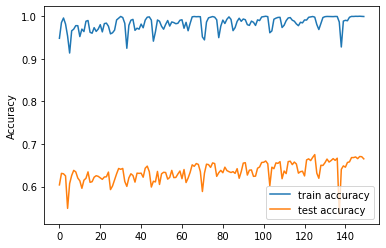

In [110]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="test accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")    
plt.show()

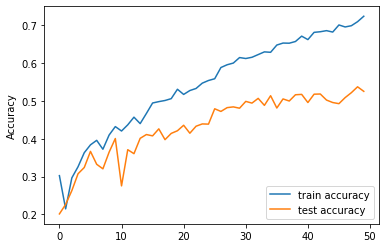

In [117]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="test accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")    
plt.show()

# Convolutional Neural Network

In [32]:
len(inputs)

10986

In [33]:
inputs.shape

(10986, 130, 13)

In [34]:
X_train, X_test, y_train, y_test =  train_test_split(inputs, targets, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [35]:
print(X_train[0][0][0])

-100.62495422363281


In [36]:
X_train.shape

(7690, 130, 13)

In [8]:
# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
# tf.keras.layers.Conv2D(
#     filters, kernel_size, strides=(1, 1), padding='valid',
#     data_format=None, dilation_rate=(1, 1), groups=1, activation=None,
#     use_bias=True, kernel_initializer='glorot_uniform',
#     bias_initializer='zeros', kernel_regularizer=None,
#     bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
#     bias_constraint=None, **kwargs
# )

In [9]:
input_shape = (X_train.shape[1], X_train.shape[2], 1) ##

In [ ]:
print(input_shape)

In [10]:
model_cnn = keras.Sequential()

# st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))


In [11]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [49]:
def plot_accuracy(history):
    fig, ax = plt.subplots()

    # create accuracy sublpot
    ax.plot(history.history["accuracy"], label="train accuracy")
    ax.plot(history.history["val_accuracy"], label="test accuracy")
    ax.set_ylabel("Accuracy")
    ax.legend(loc="lower right")
    ax.set_title("Accuracy eval")

    plt.show()



In [50]:
def plot_loss(history):
    fig, ax = plt.subplots()
    
    # create error sublpot
    ax.plot(history.history["loss"], label="train error")
    ax.plot(history.history["val_loss"], label="test error")
    ax.set_ylabel("Error")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")
    ax.set_title("Error eval")

    plt.show()

In [14]:
history = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=60)

Epoch 1/60
219/219 [==============================] - 6s 25ms/step - loss: 2.4765 - accuracy: 0.2040 - val_loss: 1.8575 - val_accuracy: 0.3478
Epoch 2/60
219/219 [==============================] - 5s 24ms/step - loss: 1.8900 - accuracy: 0.3396 - val_loss: 1.5646 - val_accuracy: 0.4393
Epoch 3/60
219/219 [==============================] - 6s 25ms/step - loss: 1.6830 - accuracy: 0.3980 - val_loss: 1.4116 - val_accuracy: 0.5000
Epoch 4/60
219/219 [==============================] - 6s 25ms/step - loss: 1.5376 - accuracy: 0.4471 - val_loss: 1.3183 - val_accuracy: 0.5227
Epoch 5/60
219/219 [==============================] - 6s 28ms/step - loss: 1.4579 - accuracy: 0.4811 - val_loss: 1.2506 - val_accuracy: 0.5607
Epoch 6/60
219/219 [==============================] - 6s 25ms/step - loss: 1.3749 - accuracy: 0.5166 - val_loss: 1.1805 - val_accuracy: 0.5888
Epoch 7/60
219/219 [==============================] - 6s 26ms/step - loss: 1.3088 - accuracy: 0.5441 - val_loss: 1.1303 - val_accuracy: 0.5948

Epoch 58/60
219/219 [==============================] - 5s 25ms/step - loss: 0.4229 - accuracy: 0.8557 - val_loss: 0.7494 - val_accuracy: 0.7550
Epoch 59/60
219/219 [==============================] - 5s 24ms/step - loss: 0.4090 - accuracy: 0.8562 - val_loss: 0.7036 - val_accuracy: 0.7590
Epoch 60/60
219/219 [==============================] - 5s 24ms/step - loss: 0.4013 - accuracy: 0.8591 - val_loss: 0.7315 - val_accuracy: 0.7610


In [15]:
# evaluate model on test set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

47/47 - 0s - loss: 0.7499 - accuracy: 0.7583 - 316ms/epoch - 7ms/step

Test accuracy: 0.7583444714546204


In [16]:
len(X_test)

1498

In [17]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [18]:
X_to_predict.shape

(130, 13, 1)

In [20]:
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [21]:
# perform prediction
# print(X_to_predict)
prediction = model_cnn.predict(X_to_predict)
# print(prediction)
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Target: {}, Predicted label: {}".format(y_to_predict, predicted_index))

Target: 5, Predicted label: [5]


### Plot accuracy/error for training and validation

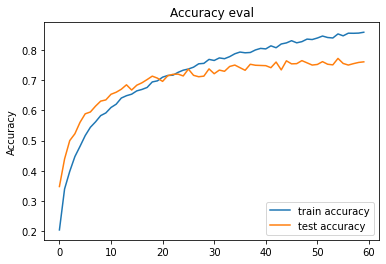

In [25]:
plot_accuracy(history)

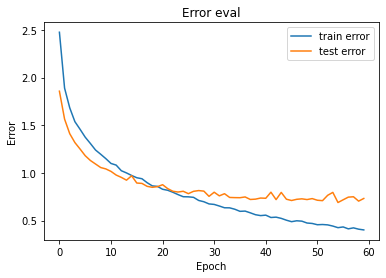

In [26]:
plot_loss(history)

## Preparation of mugam data

In [82]:
# Specify the path of newly added songs and where to store them as .wav
new_songs_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original"
wav_songs_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/genres+mugam/mugam"

In [83]:
# Find those song files
onlyfiles = [f for f in listdir(new_songs_path) if isfile(join(new_songs_path, f))]

In [84]:
print(onlyfiles)

['10.MAHUR.mp3', '2.HEYRATI.mp3', '14.DASHDI.mp3', '3.QATAR.mp3', '7.SHUSHTAR TASNIFI.mp3', '2.CAHARGAH.mp3', '3.TASNIF MENDE YOXDUR.mp3', '4.TASNIF SHUSHA.mp3', '2.RAHAB 2.mp3', '9.DURUN GEDAK.mp3', '4.HUMAYUN.mp3', '4.ARAQ-PANJIGAH.mp3', '3.MIRZA HUSEYN SEGAHI.mp3', '2.BAYATI-SHIRAZ 2.mp3', '11.SEGAH.mp3', '.DS_Store', '3.BAYATI-SHIRAZ 2.mp3', '7.ARAQ TASNIFI.mp3', '3.MANSURIYYA.mp3', '5.OSMANLI TASNIFI.mp3', '3.ARAQ.mp3', '1.BAYATI-SHIRAZ 3.mp3', '2.BAYATI.mp3', '2.CAHARGAH 2.mp3', '1.ZABUL-SEGAH.mp3', 'VILAYATI-DILKASH.mp3', '4.MANSURIYYA.mp3', '12.MAHUR-HINDI-2.mp3', '2.MIRZA HUSEYN SEGAHI 2.mp3', '9.MAHUR-HINDI.mp3', '1.BAYATI-SHIRAZ 2.mp3', '2.RAHAB.mp3', '7.BUDAQ SARI.mp3', '2.BAYATI-KURD.mp3', '11.BAYATI-SHIRAZ.mp3', '3.BAYATI-ACAM.mp3', '15.YERI, DAM USTA YERI.mp3', '5.MAYE-SHUR.mp3', '4.SEGAH.mp3', '1.SEGAH-ZABUL.mp3', '2.RAST 3.mp3', '13.ZAMINXARA.mp3', '1.CHOBAN-BAYATI.mp3', '4.TASNIF MENDEN OLDU.mp3', '3.SHUR TASNIFI 2.mp3', '2.RAST 2.mp3', '3.SHUSHTAR.mp3', '9.KEREMI.mp3

In [85]:
numb = 0
audio_length = 30 * 1000 # in milliseconds, 30 seconds
for f in onlyfiles: 
    filename = os.fsdecode(f)
    if filename.endswith(".mp3"):
        xpath = os.path.join(new_songs_path,filename)
        print(xpath)
        new  = os.path.join(os.path.join(wav_songs_path),"mugam."+ str(numb).zfill(5) + ".wav" )
        audSeg = AudioSegment.from_mp3(xpath)
        audSeg = audSeg[0:audio_length]
        audSeg = audSeg.set_frame_rate(22050)
        audSeg.export(new, format="wav")
        numb = numb +  1

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/10.MAHUR.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/2.HEYRATI.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/14.DASHDI.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/3.QATAR.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/7.SHUSHTAR TASNIFI.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/2.CAHARGAH.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/3.TASNIF MENDE YOXDUR.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classi

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/3.MUXALIF.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/9.TAJ.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/1.ZABUL-SEGAH 3.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/2.MIRZA HUSEYN SEGAHI.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/6.SARENC.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/1.AXSHAM OLDU.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/4.SEGAH TASNIFI.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Cl

## Writing MFCC to json with genre mugam

In [61]:
NEW_DATASET_PATH = "./Data/genres+mugam"
NEW_JSON_PATH = "new_data.json"
onesegment_NEW_JSON_PATH = "onesegment_new_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [108]:
save_mfcc(NEW_DATASET_PATH, NEJSON_PATH, num_segments=10)

130

Processing pop
pop.00027.wav
./Data/genres+mugam/pop/pop.00027.wav, segment:1
./Data/genres+mugam/pop/pop.00027.wav, segment:2
./Data/genres+mugam/pop/pop.00027.wav, segment:3
./Data/genres+mugam/pop/pop.00027.wav, segment:4
./Data/genres+mugam/pop/pop.00027.wav, segment:5
./Data/genres+mugam/pop/pop.00027.wav, segment:6
./Data/genres+mugam/pop/pop.00027.wav, segment:7
./Data/genres+mugam/pop/pop.00027.wav, segment:8
./Data/genres+mugam/pop/pop.00027.wav, segment:9
./Data/genres+mugam/pop/pop.00027.wav, segment:10
pop.00033.wav
./Data/genres+mugam/pop/pop.00033.wav, segment:1
./Data/genres+mugam/pop/pop.00033.wav, segment:2
./Data/genres+mugam/pop/pop.00033.wav, segment:3
./Data/genres+mugam/pop/pop.00033.wav, segment:4
./Data/genres+mugam/pop/pop.00033.wav, segment:5
./Data/genres+mugam/pop/pop.00033.wav, segment:6
./Data/genres+mugam/pop/pop.00033.wav, segment:7
./Data/genres+mugam/pop/pop.00033.wav, segment:8
./Data/genres+mugam/pop/pop.00033.wav, segment:9
./Data/genres+mugam/

./Data/genres+mugam/pop/pop.00023.wav, segment:5
./Data/genres+mugam/pop/pop.00023.wav, segment:6
./Data/genres+mugam/pop/pop.00023.wav, segment:7
./Data/genres+mugam/pop/pop.00023.wav, segment:8
./Data/genres+mugam/pop/pop.00023.wav, segment:9
./Data/genres+mugam/pop/pop.00023.wav, segment:10
pop.00044.wav
./Data/genres+mugam/pop/pop.00044.wav, segment:1
./Data/genres+mugam/pop/pop.00044.wav, segment:2
./Data/genres+mugam/pop/pop.00044.wav, segment:3
./Data/genres+mugam/pop/pop.00044.wav, segment:4
./Data/genres+mugam/pop/pop.00044.wav, segment:5
./Data/genres+mugam/pop/pop.00044.wav, segment:6
./Data/genres+mugam/pop/pop.00044.wav, segment:7
./Data/genres+mugam/pop/pop.00044.wav, segment:8
./Data/genres+mugam/pop/pop.00044.wav, segment:9
./Data/genres+mugam/pop/pop.00044.wav, segment:10
pop.00050.wav
./Data/genres+mugam/pop/pop.00050.wav, segment:1
./Data/genres+mugam/pop/pop.00050.wav, segment:2
./Data/genres+mugam/pop/pop.00050.wav, segment:3
./Data/genres+mugam/pop/pop.00050.wav, 

./Data/genres+mugam/pop/pop.00091.wav, segment:10
pop.00046.wav
./Data/genres+mugam/pop/pop.00046.wav, segment:1
./Data/genres+mugam/pop/pop.00046.wav, segment:2
./Data/genres+mugam/pop/pop.00046.wav, segment:3
./Data/genres+mugam/pop/pop.00046.wav, segment:4
./Data/genres+mugam/pop/pop.00046.wav, segment:5
./Data/genres+mugam/pop/pop.00046.wav, segment:6
./Data/genres+mugam/pop/pop.00046.wav, segment:7
./Data/genres+mugam/pop/pop.00046.wav, segment:8
./Data/genres+mugam/pop/pop.00046.wav, segment:9
./Data/genres+mugam/pop/pop.00046.wav, segment:10
pop.00052.wav
./Data/genres+mugam/pop/pop.00052.wav, segment:1
./Data/genres+mugam/pop/pop.00052.wav, segment:2
./Data/genres+mugam/pop/pop.00052.wav, segment:3
./Data/genres+mugam/pop/pop.00052.wav, segment:4
./Data/genres+mugam/pop/pop.00052.wav, segment:5
./Data/genres+mugam/pop/pop.00052.wav, segment:6
./Data/genres+mugam/pop/pop.00052.wav, segment:7
./Data/genres+mugam/pop/pop.00052.wav, segment:8
./Data/genres+mugam/pop/pop.00052.wav, 

./Data/genres+mugam/pop/pop.00054.wav, segment:7
./Data/genres+mugam/pop/pop.00054.wav, segment:8
./Data/genres+mugam/pop/pop.00054.wav, segment:9
./Data/genres+mugam/pop/pop.00054.wav, segment:10
pop.00040.wav
./Data/genres+mugam/pop/pop.00040.wav, segment:1
./Data/genres+mugam/pop/pop.00040.wav, segment:2
./Data/genres+mugam/pop/pop.00040.wav, segment:3
./Data/genres+mugam/pop/pop.00040.wav, segment:4
./Data/genres+mugam/pop/pop.00040.wav, segment:5
./Data/genres+mugam/pop/pop.00040.wav, segment:6
./Data/genres+mugam/pop/pop.00040.wav, segment:7
./Data/genres+mugam/pop/pop.00040.wav, segment:8
./Data/genres+mugam/pop/pop.00040.wav, segment:9
./Data/genres+mugam/pop/pop.00040.wav, segment:10
pop.00068.wav
./Data/genres+mugam/pop/pop.00068.wav, segment:1
./Data/genres+mugam/pop/pop.00068.wav, segment:2
./Data/genres+mugam/pop/pop.00068.wav, segment:3
./Data/genres+mugam/pop/pop.00068.wav, segment:4
./Data/genres+mugam/pop/pop.00068.wav, segment:5
./Data/genres+mugam/pop/pop.00068.wav, 

./Data/genres+mugam/pop/pop.00062.wav, segment:4
./Data/genres+mugam/pop/pop.00062.wav, segment:5
./Data/genres+mugam/pop/pop.00062.wav, segment:6
./Data/genres+mugam/pop/pop.00062.wav, segment:7
./Data/genres+mugam/pop/pop.00062.wav, segment:8
./Data/genres+mugam/pop/pop.00062.wav, segment:9
./Data/genres+mugam/pop/pop.00062.wav, segment:10
pop.00076.wav
./Data/genres+mugam/pop/pop.00076.wav, segment:1
./Data/genres+mugam/pop/pop.00076.wav, segment:2
./Data/genres+mugam/pop/pop.00076.wav, segment:3
./Data/genres+mugam/pop/pop.00076.wav, segment:4
./Data/genres+mugam/pop/pop.00076.wav, segment:5
./Data/genres+mugam/pop/pop.00076.wav, segment:6
./Data/genres+mugam/pop/pop.00076.wav, segment:7
./Data/genres+mugam/pop/pop.00076.wav, segment:8
./Data/genres+mugam/pop/pop.00076.wav, segment:9
./Data/genres+mugam/pop/pop.00076.wav, segment:10
pop.00048.wav
./Data/genres+mugam/pop/pop.00048.wav, segment:1
./Data/genres+mugam/pop/pop.00048.wav, segment:2
./Data/genres+mugam/pop/pop.00048.wav, 

./Data/genres+mugam/pop/pop.00028.wav, segment:10
pop.00014.wav
./Data/genres+mugam/pop/pop.00014.wav, segment:1
./Data/genres+mugam/pop/pop.00014.wav, segment:2
./Data/genres+mugam/pop/pop.00014.wav, segment:3
./Data/genres+mugam/pop/pop.00014.wav, segment:4
./Data/genres+mugam/pop/pop.00014.wav, segment:5
./Data/genres+mugam/pop/pop.00014.wav, segment:6
./Data/genres+mugam/pop/pop.00014.wav, segment:7
./Data/genres+mugam/pop/pop.00014.wav, segment:8
./Data/genres+mugam/pop/pop.00014.wav, segment:9
./Data/genres+mugam/pop/pop.00014.wav, segment:10
pop.00000.wav
./Data/genres+mugam/pop/pop.00000.wav, segment:1
./Data/genres+mugam/pop/pop.00000.wav, segment:2
./Data/genres+mugam/pop/pop.00000.wav, segment:3
./Data/genres+mugam/pop/pop.00000.wav, segment:4
./Data/genres+mugam/pop/pop.00000.wav, segment:5
./Data/genres+mugam/pop/pop.00000.wav, segment:6
./Data/genres+mugam/pop/pop.00000.wav, segment:7
./Data/genres+mugam/pop/pop.00000.wav, segment:8
./Data/genres+mugam/pop/pop.00000.wav, 

./Data/genres+mugam/metal/metal.00021.wav, segment:9
./Data/genres+mugam/metal/metal.00021.wav, segment:10
metal.00020.wav
./Data/genres+mugam/metal/metal.00020.wav, segment:1
./Data/genres+mugam/metal/metal.00020.wav, segment:2
./Data/genres+mugam/metal/metal.00020.wav, segment:3
./Data/genres+mugam/metal/metal.00020.wav, segment:4
./Data/genres+mugam/metal/metal.00020.wav, segment:5
./Data/genres+mugam/metal/metal.00020.wav, segment:6
./Data/genres+mugam/metal/metal.00020.wav, segment:7
./Data/genres+mugam/metal/metal.00020.wav, segment:8
./Data/genres+mugam/metal/metal.00020.wav, segment:9
./Data/genres+mugam/metal/metal.00020.wav, segment:10
metal.00034.wav
./Data/genres+mugam/metal/metal.00034.wav, segment:1
./Data/genres+mugam/metal/metal.00034.wav, segment:2
./Data/genres+mugam/metal/metal.00034.wav, segment:3
./Data/genres+mugam/metal/metal.00034.wav, segment:4
./Data/genres+mugam/metal/metal.00034.wav, segment:5
./Data/genres+mugam/metal/metal.00034.wav, segment:6
./Data/genre

./Data/genres+mugam/metal/metal.00069.wav, segment:5
./Data/genres+mugam/metal/metal.00069.wav, segment:6
./Data/genres+mugam/metal/metal.00069.wav, segment:7
./Data/genres+mugam/metal/metal.00069.wav, segment:8
./Data/genres+mugam/metal/metal.00069.wav, segment:9
./Data/genres+mugam/metal/metal.00069.wav, segment:10
metal.00041.wav
./Data/genres+mugam/metal/metal.00041.wav, segment:1
./Data/genres+mugam/metal/metal.00041.wav, segment:2
./Data/genres+mugam/metal/metal.00041.wav, segment:3
./Data/genres+mugam/metal/metal.00041.wav, segment:4
./Data/genres+mugam/metal/metal.00041.wav, segment:5
./Data/genres+mugam/metal/metal.00041.wav, segment:6
./Data/genres+mugam/metal/metal.00041.wav, segment:7
./Data/genres+mugam/metal/metal.00041.wav, segment:8
./Data/genres+mugam/metal/metal.00041.wav, segment:9
./Data/genres+mugam/metal/metal.00041.wav, segment:10
metal.00055.wav
./Data/genres+mugam/metal/metal.00055.wav, segment:1
./Data/genres+mugam/metal/metal.00055.wav, segment:2
./Data/genre

./Data/genres+mugam/metal/metal.00084.wav, segment:3
./Data/genres+mugam/metal/metal.00084.wav, segment:4
./Data/genres+mugam/metal/metal.00084.wav, segment:5
./Data/genres+mugam/metal/metal.00084.wav, segment:6
./Data/genres+mugam/metal/metal.00084.wav, segment:7
./Data/genres+mugam/metal/metal.00084.wav, segment:8
./Data/genres+mugam/metal/metal.00084.wav, segment:9
./Data/genres+mugam/metal/metal.00084.wav, segment:10
metal.00053.wav
./Data/genres+mugam/metal/metal.00053.wav, segment:1
./Data/genres+mugam/metal/metal.00053.wav, segment:2
./Data/genres+mugam/metal/metal.00053.wav, segment:3
./Data/genres+mugam/metal/metal.00053.wav, segment:4
./Data/genres+mugam/metal/metal.00053.wav, segment:5
./Data/genres+mugam/metal/metal.00053.wav, segment:6
./Data/genres+mugam/metal/metal.00053.wav, segment:7
./Data/genres+mugam/metal/metal.00053.wav, segment:8
./Data/genres+mugam/metal/metal.00053.wav, segment:9
./Data/genres+mugam/metal/metal.00053.wav, segment:10
metal.00047.wav
./Data/genre

./Data/genres+mugam/metal/metal.00048.wav, segment:4
./Data/genres+mugam/metal/metal.00048.wav, segment:5
./Data/genres+mugam/metal/metal.00048.wav, segment:6
./Data/genres+mugam/metal/metal.00048.wav, segment:7
./Data/genres+mugam/metal/metal.00048.wav, segment:8
./Data/genres+mugam/metal/metal.00048.wav, segment:9
./Data/genres+mugam/metal/metal.00048.wav, segment:10
metal.00060.wav
./Data/genres+mugam/metal/metal.00060.wav, segment:1
./Data/genres+mugam/metal/metal.00060.wav, segment:2
./Data/genres+mugam/metal/metal.00060.wav, segment:3
./Data/genres+mugam/metal/metal.00060.wav, segment:4
./Data/genres+mugam/metal/metal.00060.wav, segment:5
./Data/genres+mugam/metal/metal.00060.wav, segment:6
./Data/genres+mugam/metal/metal.00060.wav, segment:7
./Data/genres+mugam/metal/metal.00060.wav, segment:8
./Data/genres+mugam/metal/metal.00060.wav, segment:9
./Data/genres+mugam/metal/metal.00060.wav, segment:10
metal.00074.wav
./Data/genres+mugam/metal/metal.00074.wav, segment:1
./Data/genre

./Data/genres+mugam/metal/metal.00098.wav, segment:6
./Data/genres+mugam/metal/metal.00098.wav, segment:7
./Data/genres+mugam/metal/metal.00098.wav, segment:8
./Data/genres+mugam/metal/metal.00098.wav, segment:9
./Data/genres+mugam/metal/metal.00098.wav, segment:10
metal.00065.wav
./Data/genres+mugam/metal/metal.00065.wav, segment:1
./Data/genres+mugam/metal/metal.00065.wav, segment:2
./Data/genres+mugam/metal/metal.00065.wav, segment:3
./Data/genres+mugam/metal/metal.00065.wav, segment:4
./Data/genres+mugam/metal/metal.00065.wav, segment:5
./Data/genres+mugam/metal/metal.00065.wav, segment:6
./Data/genres+mugam/metal/metal.00065.wav, segment:7
./Data/genres+mugam/metal/metal.00065.wav, segment:8
./Data/genres+mugam/metal/metal.00065.wav, segment:9
./Data/genres+mugam/metal/metal.00065.wav, segment:10
metal.00071.wav
./Data/genres+mugam/metal/metal.00071.wav, segment:1
./Data/genres+mugam/metal/metal.00071.wav, segment:2
./Data/genres+mugam/metal/metal.00071.wav, segment:3
./Data/genre

./Data/genres+mugam/metal/metal.00029.wav, segment:8
./Data/genres+mugam/metal/metal.00029.wav, segment:9
./Data/genres+mugam/metal/metal.00029.wav, segment:10
metal.00011.wav
./Data/genres+mugam/metal/metal.00011.wav, segment:1
./Data/genres+mugam/metal/metal.00011.wav, segment:2
./Data/genres+mugam/metal/metal.00011.wav, segment:3
./Data/genres+mugam/metal/metal.00011.wav, segment:4
./Data/genres+mugam/metal/metal.00011.wav, segment:5
./Data/genres+mugam/metal/metal.00011.wav, segment:6
./Data/genres+mugam/metal/metal.00011.wav, segment:7
./Data/genres+mugam/metal/metal.00011.wav, segment:8
./Data/genres+mugam/metal/metal.00011.wav, segment:9
./Data/genres+mugam/metal/metal.00011.wav, segment:10
metal.00005.wav
./Data/genres+mugam/metal/metal.00005.wav, segment:1
./Data/genres+mugam/metal/metal.00005.wav, segment:2
./Data/genres+mugam/metal/metal.00005.wav, segment:3
./Data/genres+mugam/metal/metal.00005.wav, segment:4
./Data/genres+mugam/metal/metal.00005.wav, segment:5
./Data/genre

./Data/genres+mugam/disco/disco.00047.wav, segment:9
./Data/genres+mugam/disco/disco.00047.wav, segment:10
disco.00053.wav
./Data/genres+mugam/disco/disco.00053.wav, segment:1
./Data/genres+mugam/disco/disco.00053.wav, segment:2
./Data/genres+mugam/disco/disco.00053.wav, segment:3
./Data/genres+mugam/disco/disco.00053.wav, segment:4
./Data/genres+mugam/disco/disco.00053.wav, segment:5
./Data/genres+mugam/disco/disco.00053.wav, segment:6
./Data/genres+mugam/disco/disco.00053.wav, segment:7
./Data/genres+mugam/disco/disco.00053.wav, segment:8
./Data/genres+mugam/disco/disco.00053.wav, segment:9
./Data/genres+mugam/disco/disco.00053.wav, segment:10
disco.00045.wav
./Data/genres+mugam/disco/disco.00045.wav, segment:1
./Data/genres+mugam/disco/disco.00045.wav, segment:2
./Data/genres+mugam/disco/disco.00045.wav, segment:3
./Data/genres+mugam/disco/disco.00045.wav, segment:4
./Data/genres+mugam/disco/disco.00045.wav, segment:5
./Data/genres+mugam/disco/disco.00045.wav, segment:6
./Data/genre

./Data/genres+mugam/disco/disco.00097.wav, segment:6
./Data/genres+mugam/disco/disco.00097.wav, segment:7
./Data/genres+mugam/disco/disco.00097.wav, segment:8
./Data/genres+mugam/disco/disco.00097.wav, segment:9
./Data/genres+mugam/disco/disco.00097.wav, segment:10
disco.00096.wav
./Data/genres+mugam/disco/disco.00096.wav, segment:1
./Data/genres+mugam/disco/disco.00096.wav, segment:2
./Data/genres+mugam/disco/disco.00096.wav, segment:3
./Data/genres+mugam/disco/disco.00096.wav, segment:4
./Data/genres+mugam/disco/disco.00096.wav, segment:5
./Data/genres+mugam/disco/disco.00096.wav, segment:6
./Data/genres+mugam/disco/disco.00096.wav, segment:7
./Data/genres+mugam/disco/disco.00096.wav, segment:8
./Data/genres+mugam/disco/disco.00096.wav, segment:9
./Data/genres+mugam/disco/disco.00096.wav, segment:10
disco.00082.wav
./Data/genres+mugam/disco/disco.00082.wav, segment:1
./Data/genres+mugam/disco/disco.00082.wav, segment:2
./Data/genres+mugam/disco/disco.00082.wav, segment:3
./Data/genre

./Data/genres+mugam/disco/disco.00018.wav, segment:5
./Data/genres+mugam/disco/disco.00018.wav, segment:6
./Data/genres+mugam/disco/disco.00018.wav, segment:7
./Data/genres+mugam/disco/disco.00018.wav, segment:8
./Data/genres+mugam/disco/disco.00018.wav, segment:9
./Data/genres+mugam/disco/disco.00018.wav, segment:10
disco.00024.wav
./Data/genres+mugam/disco/disco.00024.wav, segment:1
./Data/genres+mugam/disco/disco.00024.wav, segment:2
./Data/genres+mugam/disco/disco.00024.wav, segment:3
./Data/genres+mugam/disco/disco.00024.wav, segment:4
./Data/genres+mugam/disco/disco.00024.wav, segment:5
./Data/genres+mugam/disco/disco.00024.wav, segment:6
./Data/genres+mugam/disco/disco.00024.wav, segment:7
./Data/genres+mugam/disco/disco.00024.wav, segment:8
./Data/genres+mugam/disco/disco.00024.wav, segment:9
./Data/genres+mugam/disco/disco.00024.wav, segment:10
disco.00030.wav
./Data/genres+mugam/disco/disco.00030.wav, segment:1
./Data/genres+mugam/disco/disco.00030.wav, segment:2
./Data/genre

./Data/genres+mugam/disco/disco.00010.wav, segment:1
./Data/genres+mugam/disco/disco.00010.wav, segment:2
./Data/genres+mugam/disco/disco.00010.wav, segment:3
./Data/genres+mugam/disco/disco.00010.wav, segment:4
./Data/genres+mugam/disco/disco.00010.wav, segment:5
./Data/genres+mugam/disco/disco.00010.wav, segment:6
./Data/genres+mugam/disco/disco.00010.wav, segment:7
./Data/genres+mugam/disco/disco.00010.wav, segment:8
./Data/genres+mugam/disco/disco.00010.wav, segment:9
./Data/genres+mugam/disco/disco.00010.wav, segment:10
disco.00004.wav
./Data/genres+mugam/disco/disco.00004.wav, segment:1
./Data/genres+mugam/disco/disco.00004.wav, segment:2
./Data/genres+mugam/disco/disco.00004.wav, segment:3
./Data/genres+mugam/disco/disco.00004.wav, segment:4
./Data/genres+mugam/disco/disco.00004.wav, segment:5
./Data/genres+mugam/disco/disco.00004.wav, segment:6
./Data/genres+mugam/disco/disco.00004.wav, segment:7
./Data/genres+mugam/disco/disco.00004.wav, segment:8
./Data/genres+mugam/disco/dis

./Data/genres+mugam/disco/disco.00015.wav, segment:3
./Data/genres+mugam/disco/disco.00015.wav, segment:4
./Data/genres+mugam/disco/disco.00015.wav, segment:5
./Data/genres+mugam/disco/disco.00015.wav, segment:6
./Data/genres+mugam/disco/disco.00015.wav, segment:7
./Data/genres+mugam/disco/disco.00015.wav, segment:8
./Data/genres+mugam/disco/disco.00015.wav, segment:9
./Data/genres+mugam/disco/disco.00015.wav, segment:10
disco.00001.wav
./Data/genres+mugam/disco/disco.00001.wav, segment:1
./Data/genres+mugam/disco/disco.00001.wav, segment:2
./Data/genres+mugam/disco/disco.00001.wav, segment:3
./Data/genres+mugam/disco/disco.00001.wav, segment:4
./Data/genres+mugam/disco/disco.00001.wav, segment:5
./Data/genres+mugam/disco/disco.00001.wav, segment:6
./Data/genres+mugam/disco/disco.00001.wav, segment:7
./Data/genres+mugam/disco/disco.00001.wav, segment:8
./Data/genres+mugam/disco/disco.00001.wav, segment:9
./Data/genres+mugam/disco/disco.00001.wav, segment:10
disco.00000.wav
./Data/genre

./Data/genres+mugam/disco/disco.00049.wav, segment:8
./Data/genres+mugam/disco/disco.00049.wav, segment:9
./Data/genres+mugam/disco/disco.00049.wav, segment:10
disco.00061.wav
./Data/genres+mugam/disco/disco.00061.wav, segment:1
./Data/genres+mugam/disco/disco.00061.wav, segment:2
./Data/genres+mugam/disco/disco.00061.wav, segment:3
./Data/genres+mugam/disco/disco.00061.wav, segment:4
./Data/genres+mugam/disco/disco.00061.wav, segment:5
./Data/genres+mugam/disco/disco.00061.wav, segment:6
./Data/genres+mugam/disco/disco.00061.wav, segment:7
./Data/genres+mugam/disco/disco.00061.wav, segment:8
./Data/genres+mugam/disco/disco.00061.wav, segment:9
./Data/genres+mugam/disco/disco.00061.wav, segment:10
disco.00075.wav
./Data/genres+mugam/disco/disco.00075.wav, segment:1
./Data/genres+mugam/disco/disco.00075.wav, segment:2
./Data/genres+mugam/disco/disco.00075.wav, segment:3
./Data/genres+mugam/disco/disco.00075.wav, segment:4
./Data/genres+mugam/disco/disco.00075.wav, segment:5
./Data/genre

./Data/genres+mugam/blues/blues.00051.wav, segment:1
./Data/genres+mugam/blues/blues.00051.wav, segment:2
./Data/genres+mugam/blues/blues.00051.wav, segment:3
./Data/genres+mugam/blues/blues.00051.wav, segment:4
./Data/genres+mugam/blues/blues.00051.wav, segment:5
./Data/genres+mugam/blues/blues.00051.wav, segment:6
./Data/genres+mugam/blues/blues.00051.wav, segment:7
./Data/genres+mugam/blues/blues.00051.wav, segment:8
./Data/genres+mugam/blues/blues.00051.wav, segment:9
./Data/genres+mugam/blues/blues.00051.wav, segment:10
blues.00086.wav
./Data/genres+mugam/blues/blues.00086.wav, segment:1
./Data/genres+mugam/blues/blues.00086.wav, segment:2
./Data/genres+mugam/blues/blues.00086.wav, segment:3
./Data/genres+mugam/blues/blues.00086.wav, segment:4
./Data/genres+mugam/blues/blues.00086.wav, segment:5
./Data/genres+mugam/blues/blues.00086.wav, segment:6
./Data/genres+mugam/blues/blues.00086.wav, segment:7
./Data/genres+mugam/blues/blues.00086.wav, segment:8
./Data/genres+mugam/blues/blu

./Data/genres+mugam/blues/blues.00043.wav, segment:10
blues.00094.wav
./Data/genres+mugam/blues/blues.00094.wav, segment:1
./Data/genres+mugam/blues/blues.00094.wav, segment:2
./Data/genres+mugam/blues/blues.00094.wav, segment:3
./Data/genres+mugam/blues/blues.00094.wav, segment:4
./Data/genres+mugam/blues/blues.00094.wav, segment:5
./Data/genres+mugam/blues/blues.00094.wav, segment:6
./Data/genres+mugam/blues/blues.00094.wav, segment:7
./Data/genres+mugam/blues/blues.00094.wav, segment:8
./Data/genres+mugam/blues/blues.00094.wav, segment:9
./Data/genres+mugam/blues/blues.00094.wav, segment:10
blues.00080.wav
./Data/genres+mugam/blues/blues.00080.wav, segment:1
./Data/genres+mugam/blues/blues.00080.wav, segment:2
./Data/genres+mugam/blues/blues.00080.wav, segment:3
./Data/genres+mugam/blues/blues.00080.wav, segment:4
./Data/genres+mugam/blues/blues.00080.wav, segment:5
./Data/genres+mugam/blues/blues.00080.wav, segment:6
./Data/genres+mugam/blues/blues.00080.wav, segment:7
./Data/genre

./Data/genres+mugam/blues/blues.00030.wav, segment:3
./Data/genres+mugam/blues/blues.00030.wav, segment:4
./Data/genres+mugam/blues/blues.00030.wav, segment:5
./Data/genres+mugam/blues/blues.00030.wav, segment:6
./Data/genres+mugam/blues/blues.00030.wav, segment:7
./Data/genres+mugam/blues/blues.00030.wav, segment:8
./Data/genres+mugam/blues/blues.00030.wav, segment:9
./Data/genres+mugam/blues/blues.00030.wav, segment:10
blues.00018.wav
./Data/genres+mugam/blues/blues.00018.wav, segment:1
./Data/genres+mugam/blues/blues.00018.wav, segment:2
./Data/genres+mugam/blues/blues.00018.wav, segment:3
./Data/genres+mugam/blues/blues.00018.wav, segment:4
./Data/genres+mugam/blues/blues.00018.wav, segment:5
./Data/genres+mugam/blues/blues.00018.wav, segment:6
./Data/genres+mugam/blues/blues.00018.wav, segment:7
./Data/genres+mugam/blues/blues.00018.wav, segment:8
./Data/genres+mugam/blues/blues.00018.wav, segment:9
./Data/genres+mugam/blues/blues.00018.wav, segment:10
blues.00019.wav
./Data/genre

./Data/genres+mugam/blues/blues.00013.wav, segment:3
./Data/genres+mugam/blues/blues.00013.wav, segment:4
./Data/genres+mugam/blues/blues.00013.wav, segment:5
./Data/genres+mugam/blues/blues.00013.wav, segment:6
./Data/genres+mugam/blues/blues.00013.wav, segment:7
./Data/genres+mugam/blues/blues.00013.wav, segment:8
./Data/genres+mugam/blues/blues.00013.wav, segment:9
./Data/genres+mugam/blues/blues.00013.wav, segment:10
blues.00005.wav
./Data/genres+mugam/blues/blues.00005.wav, segment:1
./Data/genres+mugam/blues/blues.00005.wav, segment:2
./Data/genres+mugam/blues/blues.00005.wav, segment:3
./Data/genres+mugam/blues/blues.00005.wav, segment:4
./Data/genres+mugam/blues/blues.00005.wav, segment:5
./Data/genres+mugam/blues/blues.00005.wav, segment:6
./Data/genres+mugam/blues/blues.00005.wav, segment:7
./Data/genres+mugam/blues/blues.00005.wav, segment:8
./Data/genres+mugam/blues/blues.00005.wav, segment:9
./Data/genres+mugam/blues/blues.00005.wav, segment:10
blues.00011.wav
./Data/genre

./Data/genres+mugam/blues/blues.00016.wav, segment:8
./Data/genres+mugam/blues/blues.00016.wav, segment:9
./Data/genres+mugam/blues/blues.00016.wav, segment:10
blues.00071.wav
./Data/genres+mugam/blues/blues.00071.wav, segment:1
./Data/genres+mugam/blues/blues.00071.wav, segment:2
./Data/genres+mugam/blues/blues.00071.wav, segment:3
./Data/genres+mugam/blues/blues.00071.wav, segment:4
./Data/genres+mugam/blues/blues.00071.wav, segment:5
./Data/genres+mugam/blues/blues.00071.wav, segment:6
./Data/genres+mugam/blues/blues.00071.wav, segment:7
./Data/genres+mugam/blues/blues.00071.wav, segment:8
./Data/genres+mugam/blues/blues.00071.wav, segment:9
./Data/genres+mugam/blues/blues.00071.wav, segment:10
blues.00065.wav
./Data/genres+mugam/blues/blues.00065.wav, segment:1
./Data/genres+mugam/blues/blues.00065.wav, segment:2
./Data/genres+mugam/blues/blues.00065.wav, segment:3
./Data/genres+mugam/blues/blues.00065.wav, segment:4
./Data/genres+mugam/blues/blues.00065.wav, segment:5
./Data/genre

./Data/genres+mugam/blues/blues.00062.wav, segment:3
./Data/genres+mugam/blues/blues.00062.wav, segment:4
./Data/genres+mugam/blues/blues.00062.wav, segment:5
./Data/genres+mugam/blues/blues.00062.wav, segment:6
./Data/genres+mugam/blues/blues.00062.wav, segment:7
./Data/genres+mugam/blues/blues.00062.wav, segment:8
./Data/genres+mugam/blues/blues.00062.wav, segment:9
./Data/genres+mugam/blues/blues.00062.wav, segment:10
blues.00089.wav
./Data/genres+mugam/blues/blues.00089.wav, segment:1
./Data/genres+mugam/blues/blues.00089.wav, segment:2
./Data/genres+mugam/blues/blues.00089.wav, segment:3
./Data/genres+mugam/blues/blues.00089.wav, segment:4
./Data/genres+mugam/blues/blues.00089.wav, segment:5
./Data/genres+mugam/blues/blues.00089.wav, segment:6
./Data/genres+mugam/blues/blues.00089.wav, segment:7
./Data/genres+mugam/blues/blues.00089.wav, segment:8
./Data/genres+mugam/blues/blues.00089.wav, segment:9
./Data/genres+mugam/blues/blues.00089.wav, segment:10
blues.00048.wav
./Data/genre

./Data/genres+mugam/mugam/mugam.00013.wav, segment:1
./Data/genres+mugam/mugam/mugam.00013.wav, segment:2
./Data/genres+mugam/mugam/mugam.00013.wav, segment:3
./Data/genres+mugam/mugam/mugam.00013.wav, segment:4
./Data/genres+mugam/mugam/mugam.00013.wav, segment:5
./Data/genres+mugam/mugam/mugam.00013.wav, segment:6
./Data/genres+mugam/mugam/mugam.00013.wav, segment:7
./Data/genres+mugam/mugam/mugam.00013.wav, segment:8
./Data/genres+mugam/mugam/mugam.00013.wav, segment:9
./Data/genres+mugam/mugam/mugam.00013.wav, segment:10
mugam.00007.wav
./Data/genres+mugam/mugam/mugam.00007.wav, segment:1
./Data/genres+mugam/mugam/mugam.00007.wav, segment:2
./Data/genres+mugam/mugam/mugam.00007.wav, segment:3
./Data/genres+mugam/mugam/mugam.00007.wav, segment:4
./Data/genres+mugam/mugam/mugam.00007.wav, segment:5
./Data/genres+mugam/mugam/mugam.00007.wav, segment:6
./Data/genres+mugam/mugam/mugam.00007.wav, segment:7
./Data/genres+mugam/mugam/mugam.00007.wav, segment:8
./Data/genres+mugam/mugam/mug

./Data/genres+mugam/mugam/mugam.00067.wav, segment:6
./Data/genres+mugam/mugam/mugam.00067.wav, segment:7
./Data/genres+mugam/mugam/mugam.00067.wav, segment:8
./Data/genres+mugam/mugam/mugam.00067.wav, segment:9
./Data/genres+mugam/mugam/mugam.00067.wav, segment:10
mugam.00073.wav
./Data/genres+mugam/mugam/mugam.00073.wav, segment:1
./Data/genres+mugam/mugam/mugam.00073.wav, segment:2
./Data/genres+mugam/mugam/mugam.00073.wav, segment:3
./Data/genres+mugam/mugam/mugam.00073.wav, segment:4
./Data/genres+mugam/mugam/mugam.00073.wav, segment:5
./Data/genres+mugam/mugam/mugam.00073.wav, segment:6
./Data/genres+mugam/mugam/mugam.00073.wav, segment:7
./Data/genres+mugam/mugam/mugam.00073.wav, segment:8
./Data/genres+mugam/mugam/mugam.00073.wav, segment:9
./Data/genres+mugam/mugam/mugam.00073.wav, segment:10
mugam.00065.wav
./Data/genres+mugam/mugam/mugam.00065.wav, segment:1
./Data/genres+mugam/mugam/mugam.00065.wav, segment:2
./Data/genres+mugam/mugam/mugam.00065.wav, segment:3
./Data/genre

./Data/genres+mugam/mugam/mugam.00088.wav, segment:4
./Data/genres+mugam/mugam/mugam.00088.wav, segment:5
./Data/genres+mugam/mugam/mugam.00088.wav, segment:6
./Data/genres+mugam/mugam/mugam.00088.wav, segment:7
./Data/genres+mugam/mugam/mugam.00088.wav, segment:8
./Data/genres+mugam/mugam/mugam.00088.wav, segment:9
./Data/genres+mugam/mugam/mugam.00088.wav, segment:10
mugam.00089.wav
./Data/genres+mugam/mugam/mugam.00089.wav, segment:1
./Data/genres+mugam/mugam/mugam.00089.wav, segment:2
./Data/genres+mugam/mugam/mugam.00089.wav, segment:3
./Data/genres+mugam/mugam/mugam.00089.wav, segment:4
./Data/genres+mugam/mugam/mugam.00089.wav, segment:5
./Data/genres+mugam/mugam/mugam.00089.wav, segment:6
./Data/genres+mugam/mugam/mugam.00089.wav, segment:7
./Data/genres+mugam/mugam/mugam.00089.wav, segment:8
./Data/genres+mugam/mugam/mugam.00089.wav, segment:9
./Data/genres+mugam/mugam/mugam.00089.wav, segment:10
mugam.00062.wav
./Data/genres+mugam/mugam/mugam.00062.wav, segment:1
./Data/genre

./Data/genres+mugam/mugam/mugam.00093.wav, segment:3
./Data/genres+mugam/mugam/mugam.00093.wav, segment:4
./Data/genres+mugam/mugam/mugam.00093.wav, segment:5
./Data/genres+mugam/mugam/mugam.00093.wav, segment:6
./Data/genres+mugam/mugam/mugam.00093.wav, segment:7
./Data/genres+mugam/mugam/mugam.00093.wav, segment:8
./Data/genres+mugam/mugam/mugam.00093.wav, segment:9
./Data/genres+mugam/mugam/mugam.00093.wav, segment:10
mugam.00092.wav
./Data/genres+mugam/mugam/mugam.00092.wav, segment:1
./Data/genres+mugam/mugam/mugam.00092.wav, segment:2
./Data/genres+mugam/mugam/mugam.00092.wav, segment:3
./Data/genres+mugam/mugam/mugam.00092.wav, segment:4
./Data/genres+mugam/mugam/mugam.00092.wav, segment:5
./Data/genres+mugam/mugam/mugam.00092.wav, segment:6
./Data/genres+mugam/mugam/mugam.00092.wav, segment:7
./Data/genres+mugam/mugam/mugam.00092.wav, segment:8
./Data/genres+mugam/mugam/mugam.00092.wav, segment:9
./Data/genres+mugam/mugam/mugam.00092.wav, segment:10
mugam.00086.wav
./Data/genre

./Data/genres+mugam/mugam/mugam.00042.wav, segment:3
./Data/genres+mugam/mugam/mugam.00042.wav, segment:4
./Data/genres+mugam/mugam/mugam.00042.wav, segment:5
./Data/genres+mugam/mugam/mugam.00042.wav, segment:6
./Data/genres+mugam/mugam/mugam.00042.wav, segment:7
./Data/genres+mugam/mugam/mugam.00042.wav, segment:8
./Data/genres+mugam/mugam/mugam.00042.wav, segment:9
./Data/genres+mugam/mugam/mugam.00042.wav, segment:10
mugam.00095.wav
./Data/genres+mugam/mugam/mugam.00095.wav, segment:1
./Data/genres+mugam/mugam/mugam.00095.wav, segment:2
./Data/genres+mugam/mugam/mugam.00095.wav, segment:3
./Data/genres+mugam/mugam/mugam.00095.wav, segment:4
./Data/genres+mugam/mugam/mugam.00095.wav, segment:5
./Data/genres+mugam/mugam/mugam.00095.wav, segment:6
./Data/genres+mugam/mugam/mugam.00095.wav, segment:7
./Data/genres+mugam/mugam/mugam.00095.wav, segment:8
./Data/genres+mugam/mugam/mugam.00095.wav, segment:9
./Data/genres+mugam/mugam/mugam.00095.wav, segment:10
mugam.00081.wav
./Data/genre

./Data/genres+mugam/mugam/mugam.00032.wav, segment:4
./Data/genres+mugam/mugam/mugam.00032.wav, segment:5
./Data/genres+mugam/mugam/mugam.00032.wav, segment:6
./Data/genres+mugam/mugam/mugam.00032.wav, segment:7
./Data/genres+mugam/mugam/mugam.00032.wav, segment:8
./Data/genres+mugam/mugam/mugam.00032.wav, segment:9
./Data/genres+mugam/mugam/mugam.00032.wav, segment:10
mugam.00026.wav
./Data/genres+mugam/mugam/mugam.00026.wav, segment:1
./Data/genres+mugam/mugam/mugam.00026.wav, segment:2
./Data/genres+mugam/mugam/mugam.00026.wav, segment:3
./Data/genres+mugam/mugam/mugam.00026.wav, segment:4
./Data/genres+mugam/mugam/mugam.00026.wav, segment:5
./Data/genres+mugam/mugam/mugam.00026.wav, segment:6
./Data/genres+mugam/mugam/mugam.00026.wav, segment:7
./Data/genres+mugam/mugam/mugam.00026.wav, segment:8
./Data/genres+mugam/mugam/mugam.00026.wav, segment:9
./Data/genres+mugam/mugam/mugam.00026.wav, segment:10
mugam.00022.wav
./Data/genres+mugam/mugam/mugam.00022.wav, segment:1
./Data/genre

./Data/genres+mugam/reggae/reggae.00057.wav, segment:3
./Data/genres+mugam/reggae/reggae.00057.wav, segment:4
./Data/genres+mugam/reggae/reggae.00057.wav, segment:5
./Data/genres+mugam/reggae/reggae.00057.wav, segment:6
./Data/genres+mugam/reggae/reggae.00057.wav, segment:7
./Data/genres+mugam/reggae/reggae.00057.wav, segment:8
./Data/genres+mugam/reggae/reggae.00057.wav, segment:9
./Data/genres+mugam/reggae/reggae.00057.wav, segment:10
reggae.00056.wav
./Data/genres+mugam/reggae/reggae.00056.wav, segment:1
./Data/genres+mugam/reggae/reggae.00056.wav, segment:2
./Data/genres+mugam/reggae/reggae.00056.wav, segment:3
./Data/genres+mugam/reggae/reggae.00056.wav, segment:4
./Data/genres+mugam/reggae/reggae.00056.wav, segment:5
./Data/genres+mugam/reggae/reggae.00056.wav, segment:6
./Data/genres+mugam/reggae/reggae.00056.wav, segment:7
./Data/genres+mugam/reggae/reggae.00056.wav, segment:8
./Data/genres+mugam/reggae/reggae.00056.wav, segment:9
./Data/genres+mugam/reggae/reggae.00056.wav, se

./Data/genres+mugam/reggae/reggae.00079.wav, segment:9
./Data/genres+mugam/reggae/reggae.00079.wav, segment:10
reggae.00051.wav
./Data/genres+mugam/reggae/reggae.00051.wav, segment:1
./Data/genres+mugam/reggae/reggae.00051.wav, segment:2
./Data/genres+mugam/reggae/reggae.00051.wav, segment:3
./Data/genres+mugam/reggae/reggae.00051.wav, segment:4
./Data/genres+mugam/reggae/reggae.00051.wav, segment:5
./Data/genres+mugam/reggae/reggae.00051.wav, segment:6
./Data/genres+mugam/reggae/reggae.00051.wav, segment:7
./Data/genres+mugam/reggae/reggae.00051.wav, segment:8
./Data/genres+mugam/reggae/reggae.00051.wav, segment:9
./Data/genres+mugam/reggae/reggae.00051.wav, segment:10
reggae.00045.wav
./Data/genres+mugam/reggae/reggae.00045.wav, segment:1
./Data/genres+mugam/reggae/reggae.00045.wav, segment:2
./Data/genres+mugam/reggae/reggae.00045.wav, segment:3
./Data/genres+mugam/reggae/reggae.00045.wav, segment:4
./Data/genres+mugam/reggae/reggae.00045.wav, segment:5
./Data/genres+mugam/reggae/re

./Data/genres+mugam/reggae/reggae.00008.wav, segment:5
./Data/genres+mugam/reggae/reggae.00008.wav, segment:6
./Data/genres+mugam/reggae/reggae.00008.wav, segment:7
./Data/genres+mugam/reggae/reggae.00008.wav, segment:8
./Data/genres+mugam/reggae/reggae.00008.wav, segment:9
./Data/genres+mugam/reggae/reggae.00008.wav, segment:10
reggae.00009.wav
./Data/genres+mugam/reggae/reggae.00009.wav, segment:1
./Data/genres+mugam/reggae/reggae.00009.wav, segment:2
./Data/genres+mugam/reggae/reggae.00009.wav, segment:3
./Data/genres+mugam/reggae/reggae.00009.wav, segment:4
./Data/genres+mugam/reggae/reggae.00009.wav, segment:5
./Data/genres+mugam/reggae/reggae.00009.wav, segment:6
./Data/genres+mugam/reggae/reggae.00009.wav, segment:7
./Data/genres+mugam/reggae/reggae.00009.wav, segment:8
./Data/genres+mugam/reggae/reggae.00009.wav, segment:9
./Data/genres+mugam/reggae/reggae.00009.wav, segment:10
reggae.00035.wav
./Data/genres+mugam/reggae/reggae.00035.wav, segment:1
./Data/genres+mugam/reggae/re

./Data/genres+mugam/reggae/reggae.00024.wav, segment:3
./Data/genres+mugam/reggae/reggae.00024.wav, segment:4
./Data/genres+mugam/reggae/reggae.00024.wav, segment:5
./Data/genres+mugam/reggae/reggae.00024.wav, segment:6
./Data/genres+mugam/reggae/reggae.00024.wav, segment:7
./Data/genres+mugam/reggae/reggae.00024.wav, segment:8
./Data/genres+mugam/reggae/reggae.00024.wav, segment:9
./Data/genres+mugam/reggae/reggae.00024.wav, segment:10
reggae.00018.wav
./Data/genres+mugam/reggae/reggae.00018.wav, segment:1
./Data/genres+mugam/reggae/reggae.00018.wav, segment:2
./Data/genres+mugam/reggae/reggae.00018.wav, segment:3
./Data/genres+mugam/reggae/reggae.00018.wav, segment:4
./Data/genres+mugam/reggae/reggae.00018.wav, segment:5
./Data/genres+mugam/reggae/reggae.00018.wav, segment:6
./Data/genres+mugam/reggae/reggae.00018.wav, segment:7
./Data/genres+mugam/reggae/reggae.00018.wav, segment:8
./Data/genres+mugam/reggae/reggae.00018.wav, segment:9
./Data/genres+mugam/reggae/reggae.00018.wav, se

./Data/genres+mugam/reggae/reggae.00038.wav, segment:6
./Data/genres+mugam/reggae/reggae.00038.wav, segment:7
./Data/genres+mugam/reggae/reggae.00038.wav, segment:8
./Data/genres+mugam/reggae/reggae.00038.wav, segment:9
./Data/genres+mugam/reggae/reggae.00038.wav, segment:10
reggae.00004.wav
./Data/genres+mugam/reggae/reggae.00004.wav, segment:1
./Data/genres+mugam/reggae/reggae.00004.wav, segment:2
./Data/genres+mugam/reggae/reggae.00004.wav, segment:3
./Data/genres+mugam/reggae/reggae.00004.wav, segment:4
./Data/genres+mugam/reggae/reggae.00004.wav, segment:5
./Data/genres+mugam/reggae/reggae.00004.wav, segment:6
./Data/genres+mugam/reggae/reggae.00004.wav, segment:7
./Data/genres+mugam/reggae/reggae.00004.wav, segment:8
./Data/genres+mugam/reggae/reggae.00004.wav, segment:9
./Data/genres+mugam/reggae/reggae.00004.wav, segment:10
reggae.00010.wav
./Data/genres+mugam/reggae/reggae.00010.wav, segment:1
./Data/genres+mugam/reggae/reggae.00010.wav, segment:2
./Data/genres+mugam/reggae/re

./Data/genres+mugam/reggae/reggae.00074.wav, segment:5
./Data/genres+mugam/reggae/reggae.00074.wav, segment:6
./Data/genres+mugam/reggae/reggae.00074.wav, segment:7
./Data/genres+mugam/reggae/reggae.00074.wav, segment:8
./Data/genres+mugam/reggae/reggae.00074.wav, segment:9
./Data/genres+mugam/reggae/reggae.00074.wav, segment:10
reggae.00058.wav
./Data/genres+mugam/reggae/reggae.00058.wav, segment:1
./Data/genres+mugam/reggae/reggae.00058.wav, segment:2
./Data/genres+mugam/reggae/reggae.00058.wav, segment:3
./Data/genres+mugam/reggae/reggae.00058.wav, segment:4
./Data/genres+mugam/reggae/reggae.00058.wav, segment:5
./Data/genres+mugam/reggae/reggae.00058.wav, segment:6
./Data/genres+mugam/reggae/reggae.00058.wav, segment:7
./Data/genres+mugam/reggae/reggae.00058.wav, segment:8
./Data/genres+mugam/reggae/reggae.00058.wav, segment:9
./Data/genres+mugam/reggae/reggae.00058.wav, segment:10
reggae.00070.wav
./Data/genres+mugam/reggae/reggae.00070.wav, segment:1
./Data/genres+mugam/reggae/re

./Data/genres+mugam/classical/classical.00051.wav, segment:5
./Data/genres+mugam/classical/classical.00051.wav, segment:6
./Data/genres+mugam/classical/classical.00051.wav, segment:7
./Data/genres+mugam/classical/classical.00051.wav, segment:8
./Data/genres+mugam/classical/classical.00051.wav, segment:9
classical.00086.wav
./Data/genres+mugam/classical/classical.00086.wav, segment:1
./Data/genres+mugam/classical/classical.00086.wav, segment:2
./Data/genres+mugam/classical/classical.00086.wav, segment:3
./Data/genres+mugam/classical/classical.00086.wav, segment:4
./Data/genres+mugam/classical/classical.00086.wav, segment:5
./Data/genres+mugam/classical/classical.00086.wav, segment:6
./Data/genres+mugam/classical/classical.00086.wav, segment:7
./Data/genres+mugam/classical/classical.00086.wav, segment:8
./Data/genres+mugam/classical/classical.00086.wav, segment:9
./Data/genres+mugam/classical/classical.00086.wav, segment:10
classical.00092.wav
./Data/genres+mugam/classical/classical.0009

./Data/genres+mugam/classical/classical.00053.wav, segment:1
./Data/genres+mugam/classical/classical.00053.wav, segment:2
./Data/genres+mugam/classical/classical.00053.wav, segment:3
./Data/genres+mugam/classical/classical.00053.wav, segment:4
./Data/genres+mugam/classical/classical.00053.wav, segment:5
./Data/genres+mugam/classical/classical.00053.wav, segment:6
./Data/genres+mugam/classical/classical.00053.wav, segment:7
./Data/genres+mugam/classical/classical.00053.wav, segment:8
./Data/genres+mugam/classical/classical.00053.wav, segment:9
./Data/genres+mugam/classical/classical.00053.wav, segment:10
classical.00057.wav
./Data/genres+mugam/classical/classical.00057.wav, segment:1
./Data/genres+mugam/classical/classical.00057.wav, segment:2
./Data/genres+mugam/classical/classical.00057.wav, segment:3
./Data/genres+mugam/classical/classical.00057.wav, segment:4
./Data/genres+mugam/classical/classical.00057.wav, segment:5
./Data/genres+mugam/classical/classical.00057.wav, segment:6
./D

./Data/genres+mugam/classical/classical.00082.wav, segment:4
./Data/genres+mugam/classical/classical.00082.wav, segment:5
./Data/genres+mugam/classical/classical.00082.wav, segment:6
./Data/genres+mugam/classical/classical.00082.wav, segment:7
./Data/genres+mugam/classical/classical.00082.wav, segment:8
./Data/genres+mugam/classical/classical.00082.wav, segment:9
./Data/genres+mugam/classical/classical.00082.wav, segment:10
classical.00069.wav
./Data/genres+mugam/classical/classical.00069.wav, segment:1
./Data/genres+mugam/classical/classical.00069.wav, segment:2
./Data/genres+mugam/classical/classical.00069.wav, segment:3
./Data/genres+mugam/classical/classical.00069.wav, segment:4
./Data/genres+mugam/classical/classical.00069.wav, segment:5
./Data/genres+mugam/classical/classical.00069.wav, segment:6
./Data/genres+mugam/classical/classical.00069.wav, segment:7
./Data/genres+mugam/classical/classical.00069.wav, segment:8
./Data/genres+mugam/classical/classical.00069.wav, segment:9
./D

./Data/genres+mugam/classical/classical.00020.wav, segment:5
./Data/genres+mugam/classical/classical.00020.wav, segment:6
./Data/genres+mugam/classical/classical.00020.wav, segment:7
./Data/genres+mugam/classical/classical.00020.wav, segment:8
./Data/genres+mugam/classical/classical.00020.wav, segment:9
./Data/genres+mugam/classical/classical.00020.wav, segment:10
classical.00008.wav
./Data/genres+mugam/classical/classical.00008.wav, segment:1
./Data/genres+mugam/classical/classical.00008.wav, segment:2
./Data/genres+mugam/classical/classical.00008.wav, segment:3
./Data/genres+mugam/classical/classical.00008.wav, segment:4
./Data/genres+mugam/classical/classical.00008.wav, segment:5
./Data/genres+mugam/classical/classical.00008.wav, segment:6
./Data/genres+mugam/classical/classical.00008.wav, segment:7
./Data/genres+mugam/classical/classical.00008.wav, segment:8
./Data/genres+mugam/classical/classical.00008.wav, segment:9
./Data/genres+mugam/classical/classical.00008.wav, segment:10
cl

./Data/genres+mugam/classical/classical.00038.wav, segment:5
./Data/genres+mugam/classical/classical.00038.wav, segment:6
./Data/genres+mugam/classical/classical.00038.wav, segment:7
./Data/genres+mugam/classical/classical.00038.wav, segment:8
./Data/genres+mugam/classical/classical.00038.wav, segment:9
./Data/genres+mugam/classical/classical.00038.wav, segment:10
classical.00010.wav
./Data/genres+mugam/classical/classical.00010.wav, segment:1
./Data/genres+mugam/classical/classical.00010.wav, segment:2
./Data/genres+mugam/classical/classical.00010.wav, segment:3
./Data/genres+mugam/classical/classical.00010.wav, segment:4
./Data/genres+mugam/classical/classical.00010.wav, segment:5
./Data/genres+mugam/classical/classical.00010.wav, segment:6
./Data/genres+mugam/classical/classical.00010.wav, segment:7
./Data/genres+mugam/classical/classical.00010.wav, segment:8
./Data/genres+mugam/classical/classical.00010.wav, segment:9
./Data/genres+mugam/classical/classical.00010.wav, segment:10
cl

./Data/genres+mugam/classical/classical.00017.wav, segment:9
./Data/genres+mugam/classical/classical.00017.wav, segment:10
classical.00003.wav
./Data/genres+mugam/classical/classical.00003.wav, segment:1
./Data/genres+mugam/classical/classical.00003.wav, segment:2
./Data/genres+mugam/classical/classical.00003.wav, segment:3
./Data/genres+mugam/classical/classical.00003.wav, segment:4
./Data/genres+mugam/classical/classical.00003.wav, segment:5
./Data/genres+mugam/classical/classical.00003.wav, segment:6
./Data/genres+mugam/classical/classical.00003.wav, segment:7
./Data/genres+mugam/classical/classical.00003.wav, segment:8
./Data/genres+mugam/classical/classical.00003.wav, segment:9
./Data/genres+mugam/classical/classical.00003.wav, segment:10
classical.00058.wav
./Data/genres+mugam/classical/classical.00058.wav, segment:1
./Data/genres+mugam/classical/classical.00058.wav, segment:2
./Data/genres+mugam/classical/classical.00058.wav, segment:3
./Data/genres+mugam/classical/classical.000

./Data/genres+mugam/classical/classical.00062.wav, segment:3
./Data/genres+mugam/classical/classical.00062.wav, segment:4
./Data/genres+mugam/classical/classical.00062.wav, segment:5
./Data/genres+mugam/classical/classical.00062.wav, segment:6
./Data/genres+mugam/classical/classical.00062.wav, segment:7
./Data/genres+mugam/classical/classical.00062.wav, segment:8
./Data/genres+mugam/classical/classical.00062.wav, segment:9
./Data/genres+mugam/classical/classical.00062.wav, segment:10
classical.00089.wav
./Data/genres+mugam/classical/classical.00089.wav, segment:1
./Data/genres+mugam/classical/classical.00089.wav, segment:2
./Data/genres+mugam/classical/classical.00089.wav, segment:3
./Data/genres+mugam/classical/classical.00089.wav, segment:4
./Data/genres+mugam/classical/classical.00089.wav, segment:5
./Data/genres+mugam/classical/classical.00089.wav, segment:6
./Data/genres+mugam/classical/classical.00089.wav, segment:7
./Data/genres+mugam/classical/classical.00089.wav, segment:8
./D

./Data/genres+mugam/rock/rock.00038.wav, segment:4
./Data/genres+mugam/rock/rock.00038.wav, segment:5
./Data/genres+mugam/rock/rock.00038.wav, segment:6
./Data/genres+mugam/rock/rock.00038.wav, segment:7
./Data/genres+mugam/rock/rock.00038.wav, segment:8
./Data/genres+mugam/rock/rock.00038.wav, segment:9
./Data/genres+mugam/rock/rock.00038.wav, segment:10
rock.00004.wav
./Data/genres+mugam/rock/rock.00004.wav, segment:1
./Data/genres+mugam/rock/rock.00004.wav, segment:2
./Data/genres+mugam/rock/rock.00004.wav, segment:3
./Data/genres+mugam/rock/rock.00004.wav, segment:4
./Data/genres+mugam/rock/rock.00004.wav, segment:5
./Data/genres+mugam/rock/rock.00004.wav, segment:6
./Data/genres+mugam/rock/rock.00004.wav, segment:7
./Data/genres+mugam/rock/rock.00004.wav, segment:8
./Data/genres+mugam/rock/rock.00004.wav, segment:9
./Data/genres+mugam/rock/rock.00004.wav, segment:10
rock.00010.wav
./Data/genres+mugam/rock/rock.00010.wav, segment:1
./Data/genres+mugam/rock/rock.00010.wav, segment:2

./Data/genres+mugam/rock/rock.00099.wav, segment:7
./Data/genres+mugam/rock/rock.00099.wav, segment:8
./Data/genres+mugam/rock/rock.00099.wav, segment:9
./Data/genres+mugam/rock/rock.00099.wav, segment:10
rock.00072.wav
./Data/genres+mugam/rock/rock.00072.wav, segment:1
./Data/genres+mugam/rock/rock.00072.wav, segment:2
./Data/genres+mugam/rock/rock.00072.wav, segment:3
./Data/genres+mugam/rock/rock.00072.wav, segment:4
./Data/genres+mugam/rock/rock.00072.wav, segment:5
./Data/genres+mugam/rock/rock.00072.wav, segment:6
./Data/genres+mugam/rock/rock.00072.wav, segment:7
./Data/genres+mugam/rock/rock.00072.wav, segment:8
./Data/genres+mugam/rock/rock.00072.wav, segment:9
./Data/genres+mugam/rock/rock.00072.wav, segment:10
rock.00066.wav
./Data/genres+mugam/rock/rock.00066.wav, segment:1
./Data/genres+mugam/rock/rock.00066.wav, segment:2
./Data/genres+mugam/rock/rock.00066.wav, segment:3
./Data/genres+mugam/rock/rock.00066.wav, segment:4
./Data/genres+mugam/rock/rock.00066.wav, segment:5

./Data/genres+mugam/rock/rock.00088.wav, segment:8
./Data/genres+mugam/rock/rock.00088.wav, segment:9
./Data/genres+mugam/rock/rock.00088.wav, segment:10
rock.00077.wav
./Data/genres+mugam/rock/rock.00077.wav, segment:1
./Data/genres+mugam/rock/rock.00077.wav, segment:2
./Data/genres+mugam/rock/rock.00077.wav, segment:3
./Data/genres+mugam/rock/rock.00077.wav, segment:4
./Data/genres+mugam/rock/rock.00077.wav, segment:5
./Data/genres+mugam/rock/rock.00077.wav, segment:6
./Data/genres+mugam/rock/rock.00077.wav, segment:7
./Data/genres+mugam/rock/rock.00077.wav, segment:8
./Data/genres+mugam/rock/rock.00077.wav, segment:9
./Data/genres+mugam/rock/rock.00077.wav, segment:10
rock.00063.wav
./Data/genres+mugam/rock/rock.00063.wav, segment:1
./Data/genres+mugam/rock/rock.00063.wav, segment:2
./Data/genres+mugam/rock/rock.00063.wav, segment:3
./Data/genres+mugam/rock/rock.00063.wav, segment:4
./Data/genres+mugam/rock/rock.00063.wav, segment:5
./Data/genres+mugam/rock/rock.00063.wav, segment:6

./Data/genres+mugam/rock/rock.00050.wav, segment:9
./Data/genres+mugam/rock/rock.00050.wav, segment:10
rock.00078.wav
./Data/genres+mugam/rock/rock.00078.wav, segment:1
./Data/genres+mugam/rock/rock.00078.wav, segment:2
./Data/genres+mugam/rock/rock.00078.wav, segment:3
./Data/genres+mugam/rock/rock.00078.wav, segment:4
./Data/genres+mugam/rock/rock.00078.wav, segment:5
./Data/genres+mugam/rock/rock.00078.wav, segment:6
./Data/genres+mugam/rock/rock.00078.wav, segment:7
./Data/genres+mugam/rock/rock.00078.wav, segment:8
./Data/genres+mugam/rock/rock.00078.wav, segment:9
./Data/genres+mugam/rock/rock.00078.wav, segment:10
rock.00079.wav
./Data/genres+mugam/rock/rock.00079.wav, segment:1
./Data/genres+mugam/rock/rock.00079.wav, segment:2
./Data/genres+mugam/rock/rock.00079.wav, segment:3
./Data/genres+mugam/rock/rock.00079.wav, segment:4
./Data/genres+mugam/rock/rock.00079.wav, segment:5
./Data/genres+mugam/rock/rock.00079.wav, segment:6
./Data/genres+mugam/rock/rock.00079.wav, segment:7

./Data/genres+mugam/rock/rock.00056.wav, segment:5
./Data/genres+mugam/rock/rock.00056.wav, segment:6
./Data/genres+mugam/rock/rock.00056.wav, segment:7
./Data/genres+mugam/rock/rock.00056.wav, segment:8
./Data/genres+mugam/rock/rock.00056.wav, segment:9
./Data/genres+mugam/rock/rock.00056.wav, segment:10
rock.00042.wav
./Data/genres+mugam/rock/rock.00042.wav, segment:1
./Data/genres+mugam/rock/rock.00042.wav, segment:2
./Data/genres+mugam/rock/rock.00042.wav, segment:3
./Data/genres+mugam/rock/rock.00042.wav, segment:4
./Data/genres+mugam/rock/rock.00042.wav, segment:5
./Data/genres+mugam/rock/rock.00042.wav, segment:6
./Data/genres+mugam/rock/rock.00042.wav, segment:7
./Data/genres+mugam/rock/rock.00042.wav, segment:8
./Data/genres+mugam/rock/rock.00042.wav, segment:9
./Data/genres+mugam/rock/rock.00042.wav, segment:10
rock.00043.wav
./Data/genres+mugam/rock/rock.00043.wav, segment:1
./Data/genres+mugam/rock/rock.00043.wav, segment:2
./Data/genres+mugam/rock/rock.00043.wav, segment:3

./Data/genres+mugam/rock/rock.00037.wav, segment:10
rock.00023.wav
./Data/genres+mugam/rock/rock.00023.wav, segment:1
./Data/genres+mugam/rock/rock.00023.wav, segment:2
./Data/genres+mugam/rock/rock.00023.wav, segment:3
./Data/genres+mugam/rock/rock.00023.wav, segment:4
./Data/genres+mugam/rock/rock.00023.wav, segment:5
./Data/genres+mugam/rock/rock.00023.wav, segment:6
./Data/genres+mugam/rock/rock.00023.wav, segment:7
./Data/genres+mugam/rock/rock.00023.wav, segment:8
./Data/genres+mugam/rock/rock.00023.wav, segment:9
./Data/genres+mugam/rock/rock.00023.wav, segment:10
rock.00009.wav
./Data/genres+mugam/rock/rock.00009.wav, segment:1
./Data/genres+mugam/rock/rock.00009.wav, segment:2
./Data/genres+mugam/rock/rock.00009.wav, segment:3
./Data/genres+mugam/rock/rock.00009.wav, segment:4
./Data/genres+mugam/rock/rock.00009.wav, segment:5
./Data/genres+mugam/rock/rock.00009.wav, segment:6
./Data/genres+mugam/rock/rock.00009.wav, segment:7
./Data/genres+mugam/rock/rock.00009.wav, segment:8

./Data/genres+mugam/hiphop/hiphop.00024.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00024.wav, segment:3
./Data/genres+mugam/hiphop/hiphop.00024.wav, segment:4
./Data/genres+mugam/hiphop/hiphop.00024.wav, segment:5
./Data/genres+mugam/hiphop/hiphop.00024.wav, segment:6
./Data/genres+mugam/hiphop/hiphop.00024.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00024.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00024.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00024.wav, segment:10
hiphop.00018.wav
./Data/genres+mugam/hiphop/hiphop.00018.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00018.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00018.wav, segment:3
./Data/genres+mugam/hiphop/hiphop.00018.wav, segment:4
./Data/genres+mugam/hiphop/hiphop.00018.wav, segment:5
./Data/genres+mugam/hiphop/hiphop.00018.wav, segment:6
./Data/genres+mugam/hiphop/hiphop.00018.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00018.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00018.wav, se

./Data/genres+mugam/hiphop/hiphop.00097.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00097.wav, segment:10
hiphop.00083.wav
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:3
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:4
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:5
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:6
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00083.wav, segment:10
hiphop.00054.wav
./Data/genres+mugam/hiphop/hiphop.00054.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00054.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00054.wav, segment:3
./Data/genres+mugam/hiphop/hiphop.00054.wav, segment:4
./Data/genres+mugam/hiphop/hiphop.00054.wav, segment:5
./Data/genres+mugam/hiphop/hi

./Data/genres+mugam/hiphop/hiphop.00085.wav, segment:4
./Data/genres+mugam/hiphop/hiphop.00085.wav, segment:5
./Data/genres+mugam/hiphop/hiphop.00085.wav, segment:6
./Data/genres+mugam/hiphop/hiphop.00085.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00085.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00085.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00085.wav, segment:10
hiphop.00091.wav
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:3
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:4
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:5
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:6
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00091.wav, segment:10
hiphop.00046.wav
./Data/genres+mugam/hiphop/hi

./Data/genres+mugam/hiphop/hiphop.00075.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00075.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00075.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00075.wav, segment:10
hiphop.00061.wav
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:3
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:4
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:5
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:6
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00061.wav, segment:10
hiphop.00049.wav
./Data/genres+mugam/hiphop/hiphop.00049.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00049.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00049.wav, segment:3
./Data/genres+mugam/hiphop/hi

./Data/genres+mugam/hiphop/hiphop.00059.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00059.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00059.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00059.wav, segment:10
hiphop.00058.wav
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:3
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:4
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:5
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:6
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00058.wav, segment:10
hiphop.00070.wav
./Data/genres+mugam/hiphop/hiphop.00070.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00070.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00070.wav, segment:3
./Data/genres+mugam/hiphop/hi

./Data/genres+mugam/hiphop/hiphop.00038.wav, segment:6
./Data/genres+mugam/hiphop/hiphop.00038.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00038.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00038.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00038.wav, segment:10
hiphop.00004.wav
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:2
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:3
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:4
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:5
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:6
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:7
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:8
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:9
./Data/genres+mugam/hiphop/hiphop.00004.wav, segment:10
hiphop.00010.wav
./Data/genres+mugam/hiphop/hiphop.00010.wav, segment:1
./Data/genres+mugam/hiphop/hiphop.00010.wav, segment:2
./Data/genres+mugam/hiphop/hi

./Data/genres+mugam/country/country.00060.wav, segment:6
./Data/genres+mugam/country/country.00060.wav, segment:7
./Data/genres+mugam/country/country.00060.wav, segment:8
./Data/genres+mugam/country/country.00060.wav, segment:9
./Data/genres+mugam/country/country.00060.wav, segment:10
country.00061.wav
./Data/genres+mugam/country/country.00061.wav, segment:1
./Data/genres+mugam/country/country.00061.wav, segment:2
./Data/genres+mugam/country/country.00061.wav, segment:3
./Data/genres+mugam/country/country.00061.wav, segment:4
./Data/genres+mugam/country/country.00061.wav, segment:5
./Data/genres+mugam/country/country.00061.wav, segment:6
./Data/genres+mugam/country/country.00061.wav, segment:7
./Data/genres+mugam/country/country.00061.wav, segment:8
./Data/genres+mugam/country/country.00061.wav, segment:9
./Data/genres+mugam/country/country.00061.wav, segment:10
country.00075.wav
./Data/genres+mugam/country/country.00075.wav, segment:1
./Data/genres+mugam/country/country.00075.wav, seg

./Data/genres+mugam/country/country.00098.wav, segment:1
./Data/genres+mugam/country/country.00098.wav, segment:2
./Data/genres+mugam/country/country.00098.wav, segment:3
./Data/genres+mugam/country/country.00098.wav, segment:4
./Data/genres+mugam/country/country.00098.wav, segment:5
./Data/genres+mugam/country/country.00098.wav, segment:6
./Data/genres+mugam/country/country.00098.wav, segment:7
./Data/genres+mugam/country/country.00098.wav, segment:8
./Data/genres+mugam/country/country.00098.wav, segment:9
./Data/genres+mugam/country/country.00098.wav, segment:10
country.00028.wav
./Data/genres+mugam/country/country.00028.wav, segment:1
./Data/genres+mugam/country/country.00028.wav, segment:2
./Data/genres+mugam/country/country.00028.wav, segment:3
./Data/genres+mugam/country/country.00028.wav, segment:4
./Data/genres+mugam/country/country.00028.wav, segment:5
./Data/genres+mugam/country/country.00028.wav, segment:6
./Data/genres+mugam/country/country.00028.wav, segment:7
./Data/genre

./Data/genres+mugam/country/country.00039.wav, segment:1
./Data/genres+mugam/country/country.00039.wav, segment:2
./Data/genres+mugam/country/country.00039.wav, segment:3
./Data/genres+mugam/country/country.00039.wav, segment:4
./Data/genres+mugam/country/country.00039.wav, segment:5
./Data/genres+mugam/country/country.00039.wav, segment:6
./Data/genres+mugam/country/country.00039.wav, segment:7
./Data/genres+mugam/country/country.00039.wav, segment:8
./Data/genres+mugam/country/country.00039.wav, segment:9
./Data/genres+mugam/country/country.00039.wav, segment:10
country.00038.wav
./Data/genres+mugam/country/country.00038.wav, segment:1
./Data/genres+mugam/country/country.00038.wav, segment:2
./Data/genres+mugam/country/country.00038.wav, segment:3
./Data/genres+mugam/country/country.00038.wav, segment:4
./Data/genres+mugam/country/country.00038.wav, segment:5
./Data/genres+mugam/country/country.00038.wav, segment:6
./Data/genres+mugam/country/country.00038.wav, segment:7
./Data/genre

./Data/genres+mugam/country/country.00032.wav, segment:1
./Data/genres+mugam/country/country.00032.wav, segment:2
./Data/genres+mugam/country/country.00032.wav, segment:3
./Data/genres+mugam/country/country.00032.wav, segment:4
./Data/genres+mugam/country/country.00032.wav, segment:5
./Data/genres+mugam/country/country.00032.wav, segment:6
./Data/genres+mugam/country/country.00032.wav, segment:7
./Data/genres+mugam/country/country.00032.wav, segment:8
./Data/genres+mugam/country/country.00032.wav, segment:9
./Data/genres+mugam/country/country.00032.wav, segment:10
country.00024.wav
./Data/genres+mugam/country/country.00024.wav, segment:1
./Data/genres+mugam/country/country.00024.wav, segment:2
./Data/genres+mugam/country/country.00024.wav, segment:3
./Data/genres+mugam/country/country.00024.wav, segment:4
./Data/genres+mugam/country/country.00024.wav, segment:5
./Data/genres+mugam/country/country.00024.wav, segment:6
./Data/genres+mugam/country/country.00024.wav, segment:7
./Data/genre

./Data/genres+mugam/country/country.00082.wav, segment:2
./Data/genres+mugam/country/country.00082.wav, segment:3
./Data/genres+mugam/country/country.00082.wav, segment:4
./Data/genres+mugam/country/country.00082.wav, segment:5
./Data/genres+mugam/country/country.00082.wav, segment:6
./Data/genres+mugam/country/country.00082.wav, segment:7
./Data/genres+mugam/country/country.00082.wav, segment:8
./Data/genres+mugam/country/country.00082.wav, segment:9
./Data/genres+mugam/country/country.00082.wav, segment:10
country.00069.wav
./Data/genres+mugam/country/country.00069.wav, segment:1
./Data/genres+mugam/country/country.00069.wav, segment:2
./Data/genres+mugam/country/country.00069.wav, segment:3
./Data/genres+mugam/country/country.00069.wav, segment:4
./Data/genres+mugam/country/country.00069.wav, segment:5
./Data/genres+mugam/country/country.00069.wav, segment:6
./Data/genres+mugam/country/country.00069.wav, segment:7
./Data/genres+mugam/country/country.00069.wav, segment:8
./Data/genre

./Data/genres+mugam/country/country.00045.wav, segment:1
./Data/genres+mugam/country/country.00045.wav, segment:2
./Data/genres+mugam/country/country.00045.wav, segment:3
./Data/genres+mugam/country/country.00045.wav, segment:4
./Data/genres+mugam/country/country.00045.wav, segment:5
./Data/genres+mugam/country/country.00045.wav, segment:6
./Data/genres+mugam/country/country.00045.wav, segment:7
./Data/genres+mugam/country/country.00045.wav, segment:8
./Data/genres+mugam/country/country.00045.wav, segment:9
./Data/genres+mugam/country/country.00045.wav, segment:10
country.00051.wav
./Data/genres+mugam/country/country.00051.wav, segment:1
./Data/genres+mugam/country/country.00051.wav, segment:2
./Data/genres+mugam/country/country.00051.wav, segment:3
./Data/genres+mugam/country/country.00051.wav, segment:4
./Data/genres+mugam/country/country.00051.wav, segment:5
./Data/genres+mugam/country/country.00051.wav, segment:6
./Data/genres+mugam/country/country.00051.wav, segment:7
./Data/genre

./Data/genres+mugam/jazz/jazz.00017.wav, segment:1
./Data/genres+mugam/jazz/jazz.00017.wav, segment:2
./Data/genres+mugam/jazz/jazz.00017.wav, segment:3
./Data/genres+mugam/jazz/jazz.00017.wav, segment:4
./Data/genres+mugam/jazz/jazz.00017.wav, segment:5
./Data/genres+mugam/jazz/jazz.00017.wav, segment:6
./Data/genres+mugam/jazz/jazz.00017.wav, segment:7
./Data/genres+mugam/jazz/jazz.00017.wav, segment:8
./Data/genres+mugam/jazz/jazz.00017.wav, segment:9
./Data/genres+mugam/jazz/jazz.00017.wav, segment:10
jazz.00001.wav
./Data/genres+mugam/jazz/jazz.00001.wav, segment:1
./Data/genres+mugam/jazz/jazz.00001.wav, segment:2
./Data/genres+mugam/jazz/jazz.00001.wav, segment:3
./Data/genres+mugam/jazz/jazz.00001.wav, segment:4
./Data/genres+mugam/jazz/jazz.00001.wav, segment:5
./Data/genres+mugam/jazz/jazz.00001.wav, segment:6
./Data/genres+mugam/jazz/jazz.00001.wav, segment:7
./Data/genres+mugam/jazz/jazz.00001.wav, segment:8
./Data/genres+mugam/jazz/jazz.00001.wav, segment:9
./Data/genres+m

./Data/genres+mugam/jazz/jazz.00075.wav, segment:2
./Data/genres+mugam/jazz/jazz.00075.wav, segment:3
./Data/genres+mugam/jazz/jazz.00075.wav, segment:4
./Data/genres+mugam/jazz/jazz.00075.wav, segment:5
./Data/genres+mugam/jazz/jazz.00075.wav, segment:6
./Data/genres+mugam/jazz/jazz.00075.wav, segment:7
./Data/genres+mugam/jazz/jazz.00075.wav, segment:8
./Data/genres+mugam/jazz/jazz.00075.wav, segment:9
./Data/genres+mugam/jazz/jazz.00075.wav, segment:10
jazz.00061.wav
./Data/genres+mugam/jazz/jazz.00061.wav, segment:1
./Data/genres+mugam/jazz/jazz.00061.wav, segment:2
./Data/genres+mugam/jazz/jazz.00061.wav, segment:3
./Data/genres+mugam/jazz/jazz.00061.wav, segment:4
./Data/genres+mugam/jazz/jazz.00061.wav, segment:5
./Data/genres+mugam/jazz/jazz.00061.wav, segment:6
./Data/genres+mugam/jazz/jazz.00061.wav, segment:7
./Data/genres+mugam/jazz/jazz.00061.wav, segment:8
./Data/genres+mugam/jazz/jazz.00061.wav, segment:9
./Data/genres+mugam/jazz/jazz.00061.wav, segment:10
jazz.00049.wav

./Data/genres+mugam/jazz/jazz.00058.wav, segment:5
./Data/genres+mugam/jazz/jazz.00058.wav, segment:6
./Data/genres+mugam/jazz/jazz.00058.wav, segment:7
./Data/genres+mugam/jazz/jazz.00058.wav, segment:8
./Data/genres+mugam/jazz/jazz.00058.wav, segment:9
./Data/genres+mugam/jazz/jazz.00058.wav, segment:10
jazz.00070.wav
./Data/genres+mugam/jazz/jazz.00070.wav, segment:1
./Data/genres+mugam/jazz/jazz.00070.wav, segment:2
./Data/genres+mugam/jazz/jazz.00070.wav, segment:3
./Data/genres+mugam/jazz/jazz.00070.wav, segment:4
./Data/genres+mugam/jazz/jazz.00070.wav, segment:5
./Data/genres+mugam/jazz/jazz.00070.wav, segment:6
./Data/genres+mugam/jazz/jazz.00070.wav, segment:7
./Data/genres+mugam/jazz/jazz.00070.wav, segment:8
./Data/genres+mugam/jazz/jazz.00070.wav, segment:9
./Data/genres+mugam/jazz/jazz.00070.wav, segment:10
jazz.00064.wav
./Data/genres+mugam/jazz/jazz.00064.wav, segment:1
./Data/genres+mugam/jazz/jazz.00064.wav, segment:2
./Data/genres+mugam/jazz/jazz.00064.wav, segment:3

./Data/genres+mugam/jazz/jazz.00057.wav, segment:4
./Data/genres+mugam/jazz/jazz.00057.wav, segment:5
./Data/genres+mugam/jazz/jazz.00057.wav, segment:6
./Data/genres+mugam/jazz/jazz.00057.wav, segment:7
./Data/genres+mugam/jazz/jazz.00057.wav, segment:8
./Data/genres+mugam/jazz/jazz.00057.wav, segment:9
./Data/genres+mugam/jazz/jazz.00057.wav, segment:10
jazz.00080.wav
./Data/genres+mugam/jazz/jazz.00080.wav, segment:1
./Data/genres+mugam/jazz/jazz.00080.wav, segment:2
./Data/genres+mugam/jazz/jazz.00080.wav, segment:3
./Data/genres+mugam/jazz/jazz.00080.wav, segment:4
./Data/genres+mugam/jazz/jazz.00080.wav, segment:5
./Data/genres+mugam/jazz/jazz.00080.wav, segment:6
./Data/genres+mugam/jazz/jazz.00080.wav, segment:7
./Data/genres+mugam/jazz/jazz.00080.wav, segment:8
./Data/genres+mugam/jazz/jazz.00080.wav, segment:9
./Data/genres+mugam/jazz/jazz.00080.wav, segment:10
jazz.00094.wav
./Data/genres+mugam/jazz/jazz.00094.wav, segment:1
./Data/genres+mugam/jazz/jazz.00094.wav, segment:2

./Data/genres+mugam/jazz/jazz.00045.wav, segment:2
./Data/genres+mugam/jazz/jazz.00045.wav, segment:3
./Data/genres+mugam/jazz/jazz.00045.wav, segment:4
./Data/genres+mugam/jazz/jazz.00045.wav, segment:5
./Data/genres+mugam/jazz/jazz.00045.wav, segment:6
./Data/genres+mugam/jazz/jazz.00045.wav, segment:7
./Data/genres+mugam/jazz/jazz.00045.wav, segment:8
./Data/genres+mugam/jazz/jazz.00045.wav, segment:9
./Data/genres+mugam/jazz/jazz.00045.wav, segment:10
jazz.00092.wav
./Data/genres+mugam/jazz/jazz.00092.wav, segment:1
./Data/genres+mugam/jazz/jazz.00092.wav, segment:2
./Data/genres+mugam/jazz/jazz.00092.wav, segment:3
./Data/genres+mugam/jazz/jazz.00092.wav, segment:4
./Data/genres+mugam/jazz/jazz.00092.wav, segment:5
./Data/genres+mugam/jazz/jazz.00092.wav, segment:6
./Data/genres+mugam/jazz/jazz.00092.wav, segment:7
./Data/genres+mugam/jazz/jazz.00092.wav, segment:8
./Data/genres+mugam/jazz/jazz.00092.wav, segment:9
./Data/genres+mugam/jazz/jazz.00092.wav, segment:10
jazz.00086.wav

./Data/genres+mugam/jazz/jazz.00021.wav, segment:2
./Data/genres+mugam/jazz/jazz.00021.wav, segment:3
./Data/genres+mugam/jazz/jazz.00021.wav, segment:4
./Data/genres+mugam/jazz/jazz.00021.wav, segment:5
./Data/genres+mugam/jazz/jazz.00021.wav, segment:6
./Data/genres+mugam/jazz/jazz.00021.wav, segment:7
./Data/genres+mugam/jazz/jazz.00021.wav, segment:8
./Data/genres+mugam/jazz/jazz.00021.wav, segment:9
./Data/genres+mugam/jazz/jazz.00021.wav, segment:10
jazz.00019.wav
./Data/genres+mugam/jazz/jazz.00019.wav, segment:1
./Data/genres+mugam/jazz/jazz.00019.wav, segment:2
./Data/genres+mugam/jazz/jazz.00019.wav, segment:3
./Data/genres+mugam/jazz/jazz.00019.wav, segment:4
./Data/genres+mugam/jazz/jazz.00019.wav, segment:5
./Data/genres+mugam/jazz/jazz.00019.wav, segment:6
./Data/genres+mugam/jazz/jazz.00019.wav, segment:7
./Data/genres+mugam/jazz/jazz.00019.wav, segment:8
./Data/genres+mugam/jazz/jazz.00019.wav, segment:9
./Data/genres+mugam/jazz/jazz.00019.wav, segment:10
jazz.00025.wav

## CNN with Mugam data

In [62]:
save_mfcc(DATASET_PATH, onesegment_NEW_JSON_PATH, num_segments=1)

1292

Processing pop
pop.00027.wav
./Data/genres_original/pop/pop.00027.wav, segment:1
pop.00033.wav
./Data/genres_original/pop/pop.00033.wav, segment:1
pop.00032.wav
./Data/genres_original/pop/pop.00032.wav, segment:1
pop.00026.wav
./Data/genres_original/pop/pop.00026.wav, segment:1
pop.00030.wav
./Data/genres_original/pop/pop.00030.wav, segment:1
pop.00024.wav
./Data/genres_original/pop/pop.00024.wav, segment:1
pop.00018.wav
./Data/genres_original/pop/pop.00018.wav, segment:1
pop.00019.wav
./Data/genres_original/pop/pop.00019.wav, segment:1
pop.00025.wav
./Data/genres_original/pop/pop.00025.wav, segment:1
pop.00031.wav
./Data/genres_original/pop/pop.00031.wav, segment:1
pop.00009.wav
./Data/genres_original/pop/pop.00009.wav, segment:1
pop.00035.wav
./Data/genres_original/pop/pop.00035.wav, segment:1
pop.00021.wav
./Data/genres_original/pop/pop.00021.wav, segment:1
pop.00020.wav
./Data/genres_original/pop/pop.00020.wav, segment:1
pop.00034.wav
./Data/genres_original/pop/pop.00034.wav,

./Data/genres_original/metal/metal.00055.wav, segment:1
metal.00054.wav
./Data/genres_original/metal/metal.00054.wav, segment:1
metal.00040.wav
./Data/genres_original/metal/metal.00040.wav, segment:1
metal.00068.wav
./Data/genres_original/metal/metal.00068.wav, segment:1
metal.00097.wav
./Data/genres_original/metal/metal.00097.wav, segment:1
metal.00083.wav
./Data/genres_original/metal/metal.00083.wav, segment:1
metal.00095.wav
./Data/genres_original/metal/metal.00095.wav, segment:1
metal.00081.wav
./Data/genres_original/metal/metal.00081.wav, segment:1
metal.00056.wav
./Data/genres_original/metal/metal.00056.wav, segment:1
metal.00042.wav
./Data/genres_original/metal/metal.00042.wav, segment:1
metal.00043.wav
./Data/genres_original/metal/metal.00043.wav, segment:1
metal.00057.wav
./Data/genres_original/metal/metal.00057.wav, segment:1
metal.00080.wav
./Data/genres_original/metal/metal.00080.wav, segment:1
metal.00094.wav
./Data/genres_original/metal/metal.00094.wav, segment:1
metal.00

./Data/genres_original/disco/disco.00030.wav, segment:1
disco.00026.wav
./Data/genres_original/disco/disco.00026.wav, segment:1
disco.00032.wav
./Data/genres_original/disco/disco.00032.wav, segment:1
disco.00033.wav
./Data/genres_original/disco/disco.00033.wav, segment:1
disco.00027.wav
./Data/genres_original/disco/disco.00027.wav, segment:1
disco.00023.wav
./Data/genres_original/disco/disco.00023.wav, segment:1
disco.00037.wav
./Data/genres_original/disco/disco.00037.wav, segment:1
disco.00036.wav
./Data/genres_original/disco/disco.00036.wav, segment:1
disco.00022.wav
./Data/genres_original/disco/disco.00022.wav, segment:1
disco.00008.wav
./Data/genres_original/disco/disco.00008.wav, segment:1
disco.00034.wav
./Data/genres_original/disco/disco.00034.wav, segment:1
disco.00020.wav
./Data/genres_original/disco/disco.00020.wav, segment:1
disco.00021.wav
./Data/genres_original/disco/disco.00021.wav, segment:1
disco.00035.wav
./Data/genres_original/disco/disco.00035.wav, segment:1
disco.00

./Data/genres_original/ mugam/rock.00092.wav, segment:1
rock.00086.wav
./Data/genres_original/ mugam/rock.00086.wav, segment:1
rock.00082.wav
./Data/genres_original/ mugam/rock.00082.wav, segment:1
rock.00096.wav
./Data/genres_original/ mugam/rock.00096.wav, segment:1
rock.00069.wav
./Data/genres_original/ mugam/rock.00069.wav, segment:1
rock.00041.wav
./Data/genres_original/ mugam/rock.00041.wav, segment:1
rock.00055.wav
./Data/genres_original/ mugam/rock.00055.wav, segment:1
rock.00054.wav
./Data/genres_original/ mugam/rock.00054.wav, segment:1
rock.00040.wav
./Data/genres_original/ mugam/rock.00040.wav, segment:1
rock.00068.wav
./Data/genres_original/ mugam/rock.00068.wav, segment:1
rock.00097.wav
./Data/genres_original/ mugam/rock.00097.wav, segment:1
rock.00083.wav
./Data/genres_original/ mugam/rock.00083.wav, segment:1
rock.00095.wav
./Data/genres_original/ mugam/rock.00095.wav, segment:1
rock.00081.wav
./Data/genres_original/ mugam/rock.00081.wav, segment:1
rock.00056.wav
./Data

./Data/genres_original/blues/blues.00071.wav, segment:1
blues.00065.wav
./Data/genres_original/blues/blues.00065.wav, segment:1
blues.00059.wav
./Data/genres_original/blues/blues.00059.wav, segment:1
blues.00058.wav
./Data/genres_original/blues/blues.00058.wav, segment:1
blues.00064.wav
./Data/genres_original/blues/blues.00064.wav, segment:1
blues.00070.wav
./Data/genres_original/blues/blues.00070.wav, segment:1
blues.00099.wav
./Data/genres_original/blues/blues.00099.wav, segment:1
blues.00066.wav
./Data/genres_original/blues/blues.00066.wav, segment:1
blues.00072.wav
./Data/genres_original/blues/blues.00072.wav, segment:1
blues.00073.wav
./Data/genres_original/blues/blues.00073.wav, segment:1
blues.00067.wav
./Data/genres_original/blues/blues.00067.wav, segment:1
blues.00098.wav
./Data/genres_original/blues/blues.00098.wav, segment:1
blues.00088.wav
./Data/genres_original/blues/blues.00088.wav, segment:1
blues.00063.wav
./Data/genres_original/blues/blues.00063.wav, segment:1
blues.00

./Data/genres_original/reggae/reggae.00065.wav, segment:1
reggae.00071.wav
./Data/genres_original/reggae/reggae.00071.wav, segment:1
reggae.00059.wav
./Data/genres_original/reggae/reggae.00059.wav, segment:1
reggae.00098.wav
./Data/genres_original/reggae/reggae.00098.wav, segment:1
reggae.00067.wav
./Data/genres_original/reggae/reggae.00067.wav, segment:1
reggae.00073.wav
./Data/genres_original/reggae/reggae.00073.wav, segment:1
reggae.00072.wav
./Data/genres_original/reggae/reggae.00072.wav, segment:1
reggae.00066.wav
./Data/genres_original/reggae/reggae.00066.wav, segment:1
reggae.00099.wav
./Data/genres_original/reggae/reggae.00099.wav, segment:1

Processing classical
classical.00079.wav
./Data/genres_original/classical/classical.00079.wav, segment:1
classical.00045.wav
./Data/genres_original/classical/classical.00045.wav, segment:1
classical.00051.wav
./Data/genres_original/classical/classical.00051.wav, segment:1
classical.00086.wav
./Data/genres_original/classical/classical.00086

./Data/genres_original/classical/classical.00077.wav, segment:1
classical.00061.wav
./Data/genres_original/classical/classical.00061.wav, segment:1
classical.00075.wav
./Data/genres_original/classical/classical.00075.wav, segment:1
classical.00049.wav
./Data/genres_original/classical/classical.00049.wav, segment:1
classical.00048.wav
./Data/genres_original/classical/classical.00048.wav, segment:1
classical.00074.wav
./Data/genres_original/classical/classical.00074.wav, segment:1
classical.00060.wav
./Data/genres_original/classical/classical.00060.wav, segment:1

Processing rock
rock.00011.wav
./Data/genres_original/rock/rock.00011.wav, segment:1
rock.00005.wav
./Data/genres_original/rock/rock.00005.wav, segment:1
rock.00039.wav
./Data/genres_original/rock/rock.00039.wav, segment:1
rock.00038.wav
./Data/genres_original/rock/rock.00038.wav, segment:1
rock.00004.wav
./Data/genres_original/rock/rock.00004.wav, segment:1
rock.00010.wav
./Data/genres_original/rock/rock.00010.wav, segment:1
r

./Data/genres_original/hiphop/hiphop.00030.wav, segment:1
hiphop.00024.wav
./Data/genres_original/hiphop/hiphop.00024.wav, segment:1
hiphop.00018.wav
./Data/genres_original/hiphop/hiphop.00018.wav, segment:1
hiphop.00019.wav
./Data/genres_original/hiphop/hiphop.00019.wav, segment:1
hiphop.00025.wav
./Data/genres_original/hiphop/hiphop.00025.wav, segment:1
hiphop.00031.wav
./Data/genres_original/hiphop/hiphop.00031.wav, segment:1
hiphop.00027.wav
./Data/genres_original/hiphop/hiphop.00027.wav, segment:1
hiphop.00033.wav
./Data/genres_original/hiphop/hiphop.00033.wav, segment:1
hiphop.00032.wav
hiphop.00026.wav
./Data/genres_original/hiphop/hiphop.00026.wav, segment:1
hiphop.00069.wav
./Data/genres_original/hiphop/hiphop.00069.wav, segment:1
hiphop.00041.wav
./Data/genres_original/hiphop/hiphop.00041.wav, segment:1
hiphop.00055.wav
./Data/genres_original/hiphop/hiphop.00055.wav, segment:1
hiphop.00082.wav
./Data/genres_original/hiphop/hiphop.00082.wav, segment:1
hiphop.00096.wav
./Data/g

./Data/genres_original/country/country.00098.wav, segment:1
country.00028.wav
./Data/genres_original/country/country.00028.wav, segment:1
country.00000.wav
./Data/genres_original/country/country.00000.wav, segment:1
country.00014.wav
./Data/genres_original/country/country.00014.wav, segment:1
country.00015.wav
./Data/genres_original/country/country.00015.wav, segment:1
country.00001.wav
./Data/genres_original/country/country.00001.wav, segment:1
country.00029.wav
./Data/genres_original/country/country.00029.wav, segment:1
country.00017.wav
./Data/genres_original/country/country.00017.wav, segment:1
country.00003.wav
./Data/genres_original/country/country.00003.wav, segment:1
country.00002.wav
./Data/genres_original/country/country.00002.wav, segment:1
country.00016.wav
./Data/genres_original/country/country.00016.wav, segment:1
country.00012.wav
./Data/genres_original/country/country.00012.wav, segment:1
country.00006.wav
./Data/genres_original/country/country.00006.wav, segment:1
coun

./Data/genres_original/jazz/jazz.00073.wav, segment:1
jazz.00098.wav
./Data/genres_original/jazz/jazz.00098.wav, segment:1
jazz.00099.wav
./Data/genres_original/jazz/jazz.00099.wav, segment:1
jazz.00072.wav
./Data/genres_original/jazz/jazz.00072.wav, segment:1
jazz.00066.wav
./Data/genres_original/jazz/jazz.00066.wav, segment:1
jazz.00058.wav
./Data/genres_original/jazz/jazz.00058.wav, segment:1
jazz.00070.wav
./Data/genres_original/jazz/jazz.00070.wav, segment:1
jazz.00064.wav
./Data/genres_original/jazz/jazz.00064.wav, segment:1
jazz.00065.wav
./Data/genres_original/jazz/jazz.00065.wav, segment:1
jazz.00071.wav
./Data/genres_original/jazz/jazz.00071.wav, segment:1
jazz.00059.wav
./Data/genres_original/jazz/jazz.00059.wav, segment:1
jazz.00040.wav
./Data/genres_original/jazz/jazz.00040.wav, segment:1
jazz.00068.wav
./Data/genres_original/jazz/jazz.00068.wav, segment:1
jazz.00097.wav
./Data/genres_original/jazz/jazz.00097.wav, segment:1
jazz.00083.wav
./Data/genres_original/jazz/jazz.0

In [63]:
NEW_DATASET_PATH = "./Data/genres+mugam"
NEW_JSON_PATH = "new_data.json"

In [64]:
with open(NEW_JSON_PATH, "r") as fp:
    new_data = json.load(fp)

In [ ]:
new_inputs = np.array(new_data["mfcc"])
new_targets = np.array(new_data["labels"])

In [ ]:
len(new_targets)

In [77]:
new_inputs.shape

(10986, 130, 13)

In [78]:
len(new_inputs)

10986

In [79]:
new_X_train, new_X_test, new_y_train, new_y_test =  train_test_split(new_inputs, new_targets, test_size=0.3)
new_X_test, new_X_val, new_y_test, new_y_val = train_test_split(new_X_test, new_y_test, test_size=0.5)

In [80]:
# add an axis to input sets
new_X_train = new_X_train[..., np.newaxis]
new_X_val = new_X_val[..., np.newaxis]
new_X_test = new_X_test[..., np.newaxis]

In [81]:
new_input_shape = (new_X_train.shape[1], new_X_train.shape[2], 1) ##

In [62]:
new_model_cnn_2 = keras.Sequential()

# st conv layer
new_model_cnn_2.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=new_input_shape))
new_model_cnn_2.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
new_model_cnn_2.add(keras.layers.BatchNormalization())

# 2nd conv layer
new_model_cnn_2.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
new_model_cnn_2.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
new_model_cnn_2.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
new_model_cnn_2.add(keras.layers.Flatten())
new_model_cnn_2.add(keras.layers.Dense(64, activation='relu'))
new_model_cnn_2.add(keras.layers.Dropout(0.3))

# output layer
new_model_cnn_2.add(keras.layers.Dense(11, activation='softmax'))

NameError: name 'new_input_shape' is not defined

In [47]:
new_model_cnn = keras.Sequential()

# st conv layer
new_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=new_input_shape))
new_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
new_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
new_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
new_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
new_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
new_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
new_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
new_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
new_model_cnn.add(keras.layers.Flatten())
new_model_cnn.add(keras.layers.Dense(64, activation='relu'))
new_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
new_model_cnn.add(keras.layers.Dense(11, activation='softmax'))


In [48]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
new_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

new_model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 64, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 2, 32)        0         
 g2D)                                                            
                                                      

In [49]:
new_history = new_model_cnn.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=60)

Epoch 1/60
241/241 [==============================] - 7s 26ms/step - loss: 2.2213 - accuracy: 0.2823 - val_loss: 1.6576 - val_accuracy: 0.4205
Epoch 2/60
241/241 [==============================] - 6s 25ms/step - loss: 1.6887 - accuracy: 0.4098 - val_loss: 1.4138 - val_accuracy: 0.4812
Epoch 3/60
241/241 [==============================] - 6s 26ms/step - loss: 1.5106 - accuracy: 0.4707 - val_loss: 1.2683 - val_accuracy: 0.5309
Epoch 4/60
241/241 [==============================] - 6s 25ms/step - loss: 1.3867 - accuracy: 0.5055 - val_loss: 1.2025 - val_accuracy: 0.5546
Epoch 5/60
241/241 [==============================] - 6s 26ms/step - loss: 1.3051 - accuracy: 0.5372 - val_loss: 1.1467 - val_accuracy: 0.5837
Epoch 6/60
241/241 [==============================] - 6s 26ms/step - loss: 1.2472 - accuracy: 0.5562 - val_loss: 1.0900 - val_accuracy: 0.5989
Epoch 7/60
241/241 [==============================] - 7s 29ms/step - loss: 1.1976 - accuracy: 0.5722 - val_loss: 1.0554 - val_accuracy: 0.6123

Epoch 58/60
241/241 [==============================] - 6s 27ms/step - loss: 0.4191 - accuracy: 0.8538 - val_loss: 0.6911 - val_accuracy: 0.7561
Epoch 59/60
241/241 [==============================] - 6s 27ms/step - loss: 0.4135 - accuracy: 0.8566 - val_loss: 0.6852 - val_accuracy: 0.7640
Epoch 60/60
241/241 [==============================] - 7s 27ms/step - loss: 0.4028 - accuracy: 0.8599 - val_loss: 0.6774 - val_accuracy: 0.7609


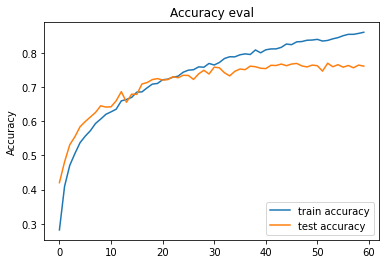

In [50]:
plot_accuracy(new_history)

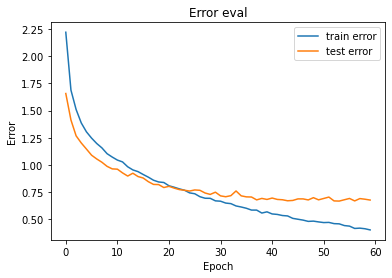

In [51]:
plot_loss(new_history)

In [52]:
# evaluate model on test set
new_test_loss, new_test_acc = new_model_cnn.evaluate(new_X_test, new_y_test, verbose=2)
print('\nTest accuracy:', new_test_acc)

52/52 - 0s - loss: 0.6661 - accuracy: 0.7834 - 298ms/epoch - 6ms/step

Test accuracy: 0.7833737730979919


In [53]:
# pick a sample to predict from the test set
new_X_to_predict = new_X_test[100]
new_y_to_predict = new_y_test[100]

In [54]:
new_X_to_predict.shape

(130, 13, 1)

In [55]:
new_X_to_predict = new_X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [57]:
# perform prediction
# print(X_to_predict)
new_prediction = new_model_cnn.predict(new_X_to_predict)
# print(prediction)
# get index with max value
new_predicted_index = np.argmax(new_prediction, axis=1)

print("Target: {}, Predicted label: {}".format(new_y_to_predict, new_predicted_index))

Target: 10, Predicted label: [3]


## CNN with 1 segment size 

In [44]:
onesegment_NEW_JSON_PATH = "onesegment_new_data.json"

In [45]:
with open(onesegment_NEW_JSON_PATH, "r") as fp:
    seg1_new_data = json.load(fp) 

In [46]:
seg1_inputs = np.array(seg1_new_data["mfcc"])
seg1_targets = np.array(seg1_new_data["labels"])

seg1_inputs.shape

(1098, 1292, 13)

In [47]:
seg1_X_train, seg1_X_test, seg1_y_train, seg1_y_test =  train_test_split(seg1_inputs, seg1_targets, test_size=0.3)
seg1_X_test, seg1_X_val, seg1_y_test, seg1_y_val = train_test_split(seg1_X_test, seg1_y_test, test_size=0.5)

In [48]:
seg1_X_train = seg1_X_train[..., np.newaxis]
seg1_X_val = seg1_X_val[..., np.newaxis]
seg1_X_test = seg1_X_test[..., np.newaxis]

In [49]:
seg1_inputs_shape = (seg1_X_train.shape[1], seg1_X_train.shape[2], 1) ##

In [50]:
seg1_model_cnn = keras.Sequential()

In [51]:
# st conv layer
seg1_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=seg1_inputs_shape))
seg1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
seg1_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
seg1_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
seg1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
seg1_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
seg1_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
seg1_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
seg1_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
seg1_model_cnn.add(keras.layers.Flatten())
seg1_model_cnn.add(keras.layers.Dense(64, activation='relu'))
seg1_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
seg1_model_cnn.add(keras.layers.Dense(11, activation='softmax'))


In [52]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
seg1_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

seg1_model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1290, 11, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 645, 6, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 645, 6, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 643, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 322, 2, 32)       0         
 2D)                                                             
                                                      

In [53]:
segone_history = seg1_model_cnn.fit(seg1_X_train, seg1_y_train, validation_data=(seg1_X_val, seg1_y_val), batch_size=32, epochs=60)

Epoch 1/60
24/24 [==============================] - 6s 221ms/step - loss: 2.7872 - accuracy: 0.1966 - val_loss: 4.1844 - val_accuracy: 0.1455
Epoch 2/60
24/24 [==============================] - 5s 211ms/step - loss: 1.9329 - accuracy: 0.3776 - val_loss: 3.4893 - val_accuracy: 0.1515
Epoch 3/60
24/24 [==============================] - 5s 214ms/step - loss: 1.5863 - accuracy: 0.4531 - val_loss: 2.9237 - val_accuracy: 0.2061
Epoch 4/60
24/24 [==============================] - 5s 211ms/step - loss: 1.3264 - accuracy: 0.5560 - val_loss: 2.5489 - val_accuracy: 0.2545
Epoch 5/60
24/24 [==============================] - 5s 211ms/step - loss: 1.1140 - accuracy: 0.6354 - val_loss: 2.1938 - val_accuracy: 0.3091
Epoch 6/60
24/24 [==============================] - 5s 211ms/step - loss: 0.9892 - accuracy: 0.6784 - val_loss: 1.9616 - val_accuracy: 0.3576
Epoch 7/60
24/24 [==============================] - 5s 213ms/step - loss: 0.8816 - accuracy: 0.6914 - val_loss: 1.8218 - val_accuracy: 0.3939
Epoch 

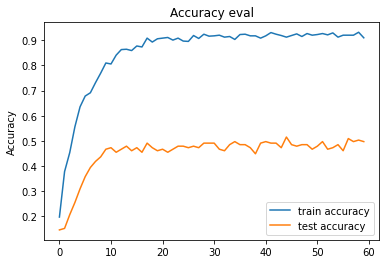

In [58]:
plot_accuracy(segone_history)

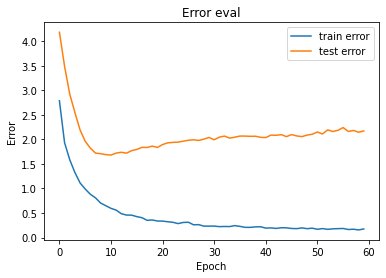

In [59]:
plot_loss(segone_history)

In [61]:
# evaluate model on test set
seg1_test_loss, seg1_test_acc = seg1_model_cnn.evaluate(seg1_X_test, seg1_y_test, verbose=2)
print('\nTest accuracy:', seg1_test_acc)

6/6 - 0s - loss: 2.0282 - accuracy: 0.4909 - 301ms/epoch - 50ms/step

Test accuracy: 0.4909090995788574


In [62]:
# pick a sample to predict from the test set
seg1_X_to_predict = seg1_X_test[100]
seg1_y_to_predict = seg1_y_test[100]

In [63]:
seg1_X_to_predict.shape

(1292, 13, 1)

In [66]:
seg1_X_to_predict = seg1_X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [67]:
# perform prediction
# print(X_to_predict)
seg1_prediction = seg1_model_cnn.predict(seg1_X_to_predict)
# print(prediction)
# get index with max value
seg1_predicted_index = np.argmax(seg1_prediction, axis=1)

print("Target: {}, Predicted label: {}".format(seg1_y_to_predict, seg1_predicted_index))

Target: 4, Predicted label: [4]


## RNN-LSTM 

In [104]:
lstm_model = keras.Sequential()

In [ ]:
smaller_lstm_model = keras.Sequential()

In [96]:
lstm_input_shape = (new_X_train.shape[1], new_X_train.shape[2]) ##

In [105]:
lstm_model.add(keras.layers.LSTM(64, input_shape=lstm_input_shape, return_sequences=True))
lstm_model.add(keras.layers.LSTM(64))

# dense layer
lstm_model.add(keras.layers.Dense(64, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.3))

# output layer
lstm_model.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
smaller_lstm_model.add(keras.layers.LSTM(32, input_shape=lstm_input_shape, return_sequences=True))
smaller_lstm_model.add(keras.layers.LSTM(32))

# dense layer
smaller_lstm_model.add(keras.layers.Dense(32, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.3))

# output layer
smaller_lstm_model.add(keras.layers.Dense(11, activation='softmax'))

In [98]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 130, 64)           19968     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 11)                715       
                                                                 
Total params: 57,867
Trainable params: 57,867
Non-trainable params: 0
_________________________________________________________________


In [106]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
smaller_lstm_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

smaller_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 130, 32)           5888      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 11)                363       
                                                                 
Total params: 15,627
Trainable params: 15,627
Non-trainable params: 0
_________________________________________________________________


In [99]:
lstm_history = lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=60)

Epoch 1/60
241/241 [==============================] - 17s 63ms/step - loss: 2.2739 - accuracy: 0.2168 - val_loss: 2.0864 - val_accuracy: 0.2888
Epoch 2/60
241/241 [==============================] - 15s 62ms/step - loss: 1.8933 - accuracy: 0.3645 - val_loss: 1.7380 - val_accuracy: 0.4193
Epoch 3/60
241/241 [==============================] - 15s 61ms/step - loss: 1.6637 - accuracy: 0.4324 - val_loss: 1.5891 - val_accuracy: 0.4478
Epoch 4/60
241/241 [==============================] - 15s 61ms/step - loss: 1.5491 - accuracy: 0.4586 - val_loss: 1.5173 - val_accuracy: 0.4600
Epoch 5/60
241/241 [==============================] - 15s 61ms/step - loss: 1.4747 - accuracy: 0.4880 - val_loss: 1.4396 - val_accuracy: 0.5097
Epoch 6/60
241/241 [==============================] - 15s 62ms/step - loss: 1.4081 - accuracy: 0.5109 - val_loss: 1.4057 - val_accuracy: 0.5261
Epoch 7/60
241/241 [==============================] - 15s 61ms/step - loss: 1.3487 - accuracy: 0.5268 - val_loss: 1.3779 - val_accuracy:

In [100]:
v2_lstm_history = lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=150)

Epoch 1/150
241/241 [==============================] - 14s 60ms/step - loss: 0.6031 - accuracy: 0.8101 - val_loss: 1.0260 - val_accuracy: 0.6845
Epoch 2/150
241/241 [==============================] - 15s 60ms/step - loss: 0.6007 - accuracy: 0.8092 - val_loss: 1.0459 - val_accuracy: 0.6851
Epoch 3/150
241/241 [==============================] - 15s 61ms/step - loss: 0.5754 - accuracy: 0.8192 - val_loss: 1.0217 - val_accuracy: 0.6948
Epoch 4/150
241/241 [==============================] - 15s 61ms/step - loss: 0.5753 - accuracy: 0.8199 - val_loss: 1.0443 - val_accuracy: 0.6814
Epoch 5/150
241/241 [==============================] - 15s 62ms/step - loss: 0.5687 - accuracy: 0.8216 - val_loss: 1.0435 - val_accuracy: 0.6778
Epoch 6/150
241/241 [==============================] - 15s 62ms/step - loss: 0.5581 - accuracy: 0.8268 - val_loss: 1.0548 - val_accuracy: 0.6863
Epoch 7/150
241/241 [==============================] - 15s 61ms/step - loss: 0.5571 - accuracy: 0.8213 - val_loss: 1.0481 - val_ac

241/241 [==============================] - 14s 59ms/step - loss: 0.2379 - accuracy: 0.9291 - val_loss: 1.2469 - val_accuracy: 0.7106
Epoch 114/150
241/241 [==============================] - 15s 61ms/step - loss: 0.2041 - accuracy: 0.9385 - val_loss: 1.2728 - val_accuracy: 0.7172
Epoch 115/150
241/241 [==============================] - 14s 60ms/step - loss: 0.2076 - accuracy: 0.9367 - val_loss: 1.3054 - val_accuracy: 0.7142
Epoch 116/150
241/241 [==============================] - 14s 60ms/step - loss: 0.2344 - accuracy: 0.9309 - val_loss: 1.3252 - val_accuracy: 0.7051
Epoch 117/150
241/241 [==============================] - 14s 60ms/step - loss: 0.2594 - accuracy: 0.9230 - val_loss: 1.2898 - val_accuracy: 0.7112
Epoch 118/150
241/241 [==============================] - 14s 60ms/step - loss: 0.2462 - accuracy: 0.9230 - val_loss: 1.2753 - val_accuracy: 0.7112
Epoch 119/150
241/241 [==============================] - 15s 60ms/step - loss: 0.2585 - accuracy: 0.9221 - val_loss: 1.2549 - val_ac

In [107]:
smaller_lstm_history = smaller_lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=75)

Epoch 1/75
241/241 [==============================] - 16s 56ms/step - loss: 2.3403 - accuracy: 0.2038 - val_loss: 2.2802 - val_accuracy: 0.2458
Epoch 2/75
241/241 [==============================] - 13s 53ms/step - loss: 2.1503 - accuracy: 0.2757 - val_loss: 2.0523 - val_accuracy: 0.2992
Epoch 3/75
241/241 [==============================] - 13s 54ms/step - loss: 1.9249 - accuracy: 0.3446 - val_loss: 1.8831 - val_accuracy: 0.3550
Epoch 4/75
241/241 [==============================] - 13s 54ms/step - loss: 1.7802 - accuracy: 0.3852 - val_loss: 1.7600 - val_accuracy: 0.3956
Epoch 5/75
241/241 [==============================] - 13s 54ms/step - loss: 1.6734 - accuracy: 0.4205 - val_loss: 1.6791 - val_accuracy: 0.4053
Epoch 6/75
241/241 [==============================] - 13s 56ms/step - loss: 1.6022 - accuracy: 0.4333 - val_loss: 1.6136 - val_accuracy: 0.4333
Epoch 7/75
241/241 [==============================] - 13s 54ms/step - loss: 1.5462 - accuracy: 0.4467 - val_loss: 1.5631 - val_accuracy:

In [108]:
smaller_lstm_history = smaller_lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=75)

Epoch 1/75
241/241 [==============================] - 13s 53ms/step - loss: 0.9958 - accuracy: 0.6450 - val_loss: 1.2649 - val_accuracy: 0.5528
Epoch 2/75
241/241 [==============================] - 13s 53ms/step - loss: 0.9873 - accuracy: 0.6503 - val_loss: 1.2770 - val_accuracy: 0.5637
Epoch 3/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9950 - accuracy: 0.6454 - val_loss: 1.2497 - val_accuracy: 0.5674
Epoch 4/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9776 - accuracy: 0.6528 - val_loss: 1.2553 - val_accuracy: 0.5637
Epoch 5/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9739 - accuracy: 0.6527 - val_loss: 1.2544 - val_accuracy: 0.5643
Epoch 6/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9731 - accuracy: 0.6523 - val_loss: 1.2488 - val_accuracy: 0.5765
Epoch 7/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9708 - accuracy: 0.6547 - val_loss: 1.2516 - val_accuracy:

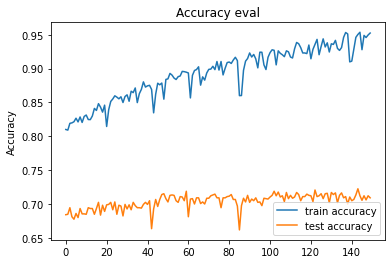

In [101]:
plot_accuracy(v2_lstm_history)

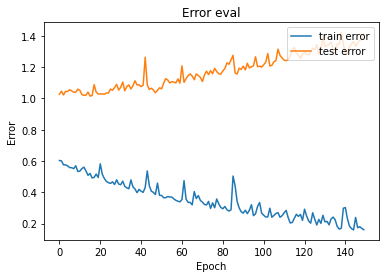

In [102]:
plot_loss(v2_lstm_history)

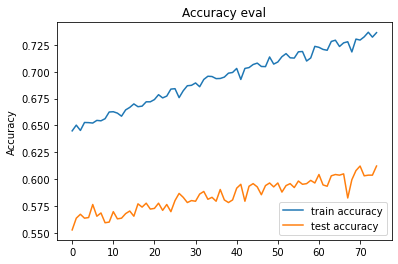

In [109]:
plot_accuracy(smaller_lstm_history)

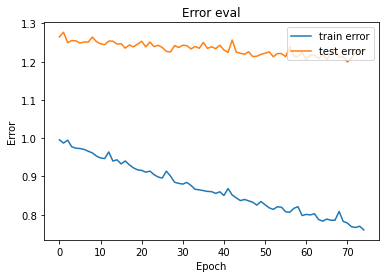

In [110]:
plot_loss(smaller_lstm_history)

In [ ]:
# evaluate model on test set
lstm_test_loss, lstm_test_acc = lstm_model_cnn.evaluate(new_X_test, new_y_test, verbose=2)
print('\nTest accuracy:', lstm_test_acc)

In [ ]:
# pick a sample to predict from the test set
new_X_to_predict = new_X_test[100]
new_y_to_predict = new_y_test[100]

In [ ]:
new_X_to_predict.shape

In [ ]:
new_X_to_predict = new_X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [92]:
# perform prediction
# print(X_to_predict)
new_prediction = lstm_model_cnn.predict(new_X_to_predict)
# print(prediction)
# get index with max value
new_predicted_index = np.argmax(new_prediction, axis=1)

print("Target: {}, Predicted label: {}".format(new_y_to_predict, new_predicted_index))

NameError: name 'lstm_model_cnn' is not defined

## Adding 100 songs to my data from each genre ( function )

In [3]:
def write_as_wav(new_songs_path, wav_songs_path, genre = "empty."):
    # Find those song files
    onlyfiles = [f for f in listdir(new_songs_path) if isfile(join(new_songs_path, f))]
    
    
    numb = 100
    audio_length = 30 * 1000 # in milliseconds, 30 seconds
    for f in onlyfiles: 
        filename = os.fsdecode(f)
        if filename.endswith(".mp3") or filename.endswith(".MP3"):
            xpath = os.path.join(new_songs_path,filename)
            print(xpath)
            new  = os.path.join(os.path.join(wav_songs_path),genre + str(numb).zfill(5) + ".wav" )
            audSeg = AudioSegment.from_mp3(xpath)
            audSeg = audSeg[0:audio_length]
            audSeg = audSeg.set_frame_rate(22050)
            audSeg.export(new, format="wav")
            numb = numb +  1

## Extracting new  music/songs

## Classical

In [13]:
# Specify the path of newly added songs and where to store them as .wav
read_path_classic = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical"
write_path_classic = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/classical"

In [14]:
write_as_wav(read_path_classic, write_path_classic, "classical.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/061. Pyotr Ilyich Tchaikovsky - The Nutcracker (Op. 71) - Waltz Of The Flowers - –©–µ–ª–∫—É–Ω—á–∏–∫.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/043. Georg Friederich Händel - Messiah (HWV 56) - For Unto Us A Child Is Born.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/008. Antonín Dvořák - New World Symphony (Op. 95) - Largo.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/082. Wolfgang Amadeus Mozart - Die Zauberfl√∂te (K. 620) - Overture.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/037. Johann Sebastian Bach - Orchestersuite Nr. 2 (BWV 1067) - Badinerie.mp3
/Users/ilyask

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/097. Aram Ilich Khachaturian - Spartacus - Adagio Of Spartacus And Phrygia.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/013. Ludwig van Beethoven - Symphony No. 7 (Op. 92).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/023. Wolfgang Amadeus Mozart - Ave Verum Corpus (K. 618).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/057. Anton√≠n Dvo≈ô√°k - Rusalka - Mƒõs√≠ƒçku Na Nebi Hlubok√©m.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/041. Giovanni Battista Pergolesi - Stabat Mater.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/036. Wolfgang Amadeus Mozart - Die Zauberflöte (K. 620) - Der Hölle Rache Kocht In Meinem Herzen.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/085. Christoph Willibald Ritter von Gluck - Orfeo Ed Euridice - Dance Of The Blessed Spirits.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/079. Gabriel Urbain Faur√© - Requiem (Op. 48) - In Paradisum.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/100. C√©sar-Auguste-Jean-Guillaume-Hubert Franck - Panis Angelicus.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical/030. Gabriel Urbain Fauré - Cantique De Jean Racine (Op. 11).mp3
/Users/ilya

## Rock 

In [16]:
# Specify the path of newly added songs and where to store them as .wav
read_path_rock = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock"
write_path_rock = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/rock"

In [17]:
write_as_wav(read_path_rock, write_path_rock, "rock.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/013. Shinedown - Simple Man.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/060. The Smashing Pumpkins - 1979 (Remastered 2012).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/034. Theory of a Deadman - Rx (Medicate).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/015. Red Hot Chili Peppers - Under the Bridge.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/053. Godsmack - Under Your Scars.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/093. Stone Sour - Through Glass.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/032. Metallica - Enter Sandman.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/020. Guns N' Roses - Patience.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/068. Chevelle - The Red.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/059. Godsmack - Bulletproof.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/066. Skillet - Monster.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/085. Imagine Dragons - I Bet My Life.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/024. Joan Je

## Blues

In [10]:
# Specify the path of newly added songs and where to store them as .wav
read_path_blues = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues"
write_path_blues = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/blues"

In [11]:
write_as_wav(read_path_blues, write_path_blues, "blues.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Marvin Gaye - Little Darling I Need You.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Martha Reeves & The Vandellas - (Love Is Like A) Heat Wave.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/The Four Tops - I Can't Help Myself (Sugar Pie, Honey Bunch).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Steve Winwood (Spencer Davis Group) - Gimme Some Lovin'.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Aretha Franklin - Chain Of Fools.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Otis Redding - Sittin' On The Dock Of The Bay.m

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/18. Son House - Delta Blues (Remastered 2017).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Otis Redding - Ain't No Sunshine (When She's Gone).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Diana Ross & The Supremes - Stop In The Name Of Love.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/The Marvelettes - Please Mr. Postman.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Jimmy Ruffin - What Becomes Of The Brokenhearted.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/17. Tampa Red - You Better Do Right (Remastered 2017).mp3
/U

## Reggae

In [24]:
# Specify the path of newly added songs and where to store them as .wav
read_path_reggae = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae"
write_path_reggae = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/reggae"

In [25]:
write_as_wav(read_path_reggae, write_path_reggae, "reggae.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/32. Wear You To The Ball - U-Roy & The Paragons.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/72. 1865 (96 Degrees In The Shade) - Third World.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/78. Feel Like Jumping - Marcia Griffiths.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/97. Electric Boogie - Marcia Griffiths.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/40. Natty Rebel - U-Roy.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/57. I'm Still In Love With You - Alton Ellis.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/86. Love Is My Religion - Ziggy Marley.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/73. Declaration of Rights - The Abyssinians.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/75. Big Ship - Freddie McGregor.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/01. No Woman, No Cry - Bob Marley & the Wailers.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/41. Loving Pauper - Dobby Dobson.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/68. You Can Get It If You Really Want - Jimmy Cliff.mp3
/Users/ilyaskarimov/Documents/GitHub/A

## Country

In [43]:
# Specify the path of newly added songs and where to store them as .wav
read_path_country = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country"
write_path_country = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/country"

In [44]:
write_as_wav(read_path_country, write_path_country, "country.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Jolene.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/I'll Fly Away.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/I've Got A Tiger By The Tail.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/500 Miles Away from Home.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Man in Black.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Mountain Dew.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Golden Ring.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fal

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Streets of Bakersfield (with Buck Owens) - 2006 Remaster.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Love Hurts (with The Fallen Angels) - Live.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Texas Cookin'.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Folsom Prison Blues - Live at Folsom State Prison, Folsom, CA - January 1968.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Fox Chase.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Home On the Range.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKar

## Disco

In [45]:
# Specify the path of newly added songs and where to store them as .wav
read_path_disco = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco"
write_path_disco = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/disco"

In [46]:
write_as_wav(read_path_disco, write_path_disco, "disco.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Good Times.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Spank - 12   Version.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/TSOP (The Sound of Philadelphia) - Extended Version.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/You're the One for Me.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Honey Bee - Extended Version.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/More, More, More.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Hot Stuff.mp3
/Users/ilyas

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Come to Me.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/So Many Men, So Little Time.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Get Off - Remastered.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Bad Girls.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Where Do We Go from Here .mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/September.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Date With The Rain.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2

## Hiphop

In [59]:
# Specify the path of newly added songs and where to store them as .wav
read_path_hiphop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop"
write_path_hiphop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/hiphop"

In [60]:
write_as_wav(read_path_hiphop, write_path_hiphop, "hiphop.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/098 - G Unit - Rider Pt. 2      (™ www.thisis50.com G Unit).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/056 - Jazmine Sullivan - Need U Bad     (™ J RMG).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/018 - V.I.C. - Get Silly      (™ Young Mogul Warner Bros.).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/097 - Colby O'Donis ft.  Akon - What You Got     (™ KonLive Geffen).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/033 - Shawty Lo - Foolish   (™  D4L Asylum).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/026 - Mar

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/008 - Usher ft. Young Jeezy - Love In This Club     (™ LaFace Zomba).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/079 - Fat Pimp - Rack Daddy    (™ Ball Hard).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/002 - Plies ft. Ne-Yo - Bust It Baby (Part 2)    (™ BigGatesSlip-N-Slide Atlantic).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/053 - Jay-Z ft.  Pharrell - I Know     (™ Roc-A-Fella Def Jam).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/075 - Leona Lewis - Bleeding Love    (™ SYCO J RMG).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/005 - Mariah Carey - Touch My Body    (™ Island  IDJMG).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/051 - T.I. - No Matter What      (™ CA -GrandHustle Warner).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/040 - The Game ft. Keyshia Cole - Game's Pain   (™ Geffen Interscope).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/010 - Usher ft.  Beyonce & Lil Wayne - Love In This Club, Part II   (™ LaFace).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/094 - Rick Ross ft  Nelly & Avery Storm - Here I Am    (™ Slip-N-Slide Def Jam  IDJMG).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-

## Jazz

In [61]:
# Specify the path of newly added songs and where to store them as .wav
read_path_jazz = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz"
write_path_jazz = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/jazz"

In [62]:
write_as_wav(read_path_jazz, write_path_jazz, "jazz.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/096. The Brecker Brothers - Sneakin' Up Behind You.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/041. Courtney Pine - Butterfly.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/089. Pharoah Sanders - Astral Traveling.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/079. Pat Metheny - All the Things You Are.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/078. Bud Powell - Bouncin' With Bud.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/074. Paco de Lucía - Beyond The Mirage.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasK

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/030. Count Basie - Taxi War Dance.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/071. Etta James - At Last.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/059. Chick Corea - Matrix.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/027. Coleman Hawkins - Night Hawk.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/082. Grant Green - Am I Blue?.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/057. Jamie Cullum - These Are The Days.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/J

## Pop

In [63]:
# Specify the path of newly added songs and where to store them as .wav
read_path_pop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop"
write_path_pop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/pop"   

In [64]:
write_as_wav(read_path_pop, write_path_pop, "pop.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/094 - Blink 182 - All The Small Things.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/076 - Radiohead - Creep.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/082 - Michael Jackson - Rock With You.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/055 - Nsync - Bye Bye Bye.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/057 - The Go-Gos - Our Lips Are Sealed.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/090 - Brandy & Monica - The Boy Is Mine.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/079 - Janet Jackson - Nasty.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/015 - John Lennon - Imagine.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/026 - Fleetwood Mac - Go Your Own Way.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/054 - Fastball - Out of my Head.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/014 - Rolling Stones - Brown Sugar.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/083 - Foreigner - I Want To Know What Love Is.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New

## Metal

In [65]:
# Specify the path of newly added songs and where to store them as .wav
read_path_metal = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal"
write_path_metal = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/metal"

In [66]:
write_as_wav(read_path_metal, write_path_metal, "metal.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/027. Judas Priest - Living After Midnight.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/095. Dream Theater - Metropolis - Part I_ _The Miracle and the Sleeper_.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/091. Lamb of God - Redneck.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/062. Iron Maiden - Fear of the Dark (2015 Remaster).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/051. Black Sabbath - Children of the Grave (2014 Remaster).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/003. Iron Maiden - Hallowed Be Thy Name (199

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/060. Manowar - Battle Hymn.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/088. Ozzy Osbourne - Diary of a Madman.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/008. Slayer - Raining Blood.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/023. Megadeth - Symphony Of Destruction.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/005. Metallica - Enter Sandman.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/043. Venom - Black Metal.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_

## Extracting New Data

In [2]:
TH_DATASET_PATH = "./Updated_data_09.03.2022"
TH_NEW_JSON_PATH = "th_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [29]:
save_mfcc(TH_DATASET_PATH, TH_NEW_JSON_PATH, num_segments=10)

130

Processing pop
pop.00153.wav
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00153.wav, segment:10
pop.00147.wav
./Updated_data_09.03.2022/pop/pop.00147.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00147.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00147.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00147.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00147.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00147.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00147.wav, segment:7
./Updated_data_0

./Updated_data_09.03.2022/pop/pop.00193.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00193.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00193.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00193.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00193.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00193.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00193.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00193.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00193.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00193.wav, segment:10
pop.00030.wav
./Updated_data_09.03.2022/pop/pop.00030.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00030.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00030.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00030.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00030.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00030.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00030.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00030.wav, segme

./Updated_data_09.03.2022/pop/pop.00196.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00196.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00196.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00196.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00196.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00196.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00196.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00196.wav, segment:10
pop.00009.wav
./Updated_data_09.03.2022/pop/pop.00009.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00009.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00009.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00009.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00009.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00009.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00009.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00009.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00009.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00009.wav, segme

./Updated_data_09.03.2022/pop/pop.00036.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00036.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00036.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00036.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00036.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00036.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00036.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00036.wav, segment:10
pop.00037.wav
./Updated_data_09.03.2022/pop/pop.00037.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00037.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00037.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00037.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00037.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00037.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00037.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00037.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00037.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00037.wav, segme

./Updated_data_09.03.2022/pop/pop.00079.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00079.wav, segment:10
pop.00051.wav
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00051.wav, segment:10
pop.00045.wav
./Updated_data_09.03.2022/pop/pop.00045.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00045.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00045.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00045.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00045.wav, segment:5
./Updated_data_09.03.2022/pop/pop.0

pop.00126.wav
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00126.wav, segment:10
pop.00122.wav
./Updated_data_09.03.2022/pop/pop.00122.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00122.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00122.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00122.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00122.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00122.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00122.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00

./Updated_data_09.03.2022/pop/pop.00069.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00069.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00069.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00069.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00069.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00069.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00069.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00069.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00069.wav, segment:10
pop.00041.wav
./Updated_data_09.03.2022/pop/pop.00041.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00041.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00041.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00041.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00041.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00041.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00041.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00041.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00041.wav, segme

./Updated_data_09.03.2022/pop/pop.00139.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00139.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00139.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00139.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00139.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00139.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00139.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00139.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00139.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00139.wav, segment:10
pop.00065.wav
./Updated_data_09.03.2022/pop/pop.00065.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00065.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00065.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00065.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00065.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00065.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00065.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00065.wav, segme

./Updated_data_09.03.2022/pop/pop.00073.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00073.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00073.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00073.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00073.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00073.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00073.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00073.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00073.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00073.wav, segment:10
pop.00113.wav
./Updated_data_09.03.2022/pop/pop.00113.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00113.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00113.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00113.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00113.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00113.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00113.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00113.wav, segme

./Updated_data_09.03.2022/pop/pop.00048.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00048.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00048.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00048.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00048.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00048.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00048.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00048.wav, segment:10
pop.00060.wav
./Updated_data_09.03.2022/pop/pop.00060.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00060.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00060.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00060.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00060.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00060.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00060.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00060.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00060.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00060.wav, segme

./Updated_data_09.03.2022/pop/pop.00167.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00167.wav, segment:10
pop.00173.wav
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00173.wav, segment:10
pop.00165.wav
./Updated_data_09.03.2022/pop/pop.00165.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00165.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00165.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00165.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00165.wav, segment:5
./Updated_data_09.03.2022/pop/pop.0

./Updated_data_09.03.2022/pop/pop.00028.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00028.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00028.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00028.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00028.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00028.wav, segment:10
pop.00014.wav
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00014.wav, segment:10
pop.00000.wav
./Updated_data_09.03.2022/pop/pop.00000.wav, segment:1
./Updated_data_09.03.2022/pop/pop.0

./Updated_data_09.03.2022/pop/pop.00162.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00162.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00162.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00162.wav, segment:10
pop.00176.wav
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:1
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:2
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:3
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:4
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:5
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:6
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:7
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:8
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:9
./Updated_data_09.03.2022/pop/pop.00176.wav, segment:10

Processing metal
metal.00022.wav
./Updated_data_09.03.2022/metal/metal.00022.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00022.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00022.wav, segment:3
./U

./Updated_data_09.03.2022/metal/metal.00182.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00182.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00182.wav, segment:10
metal.00196.wav
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00196.wav, segment:10
metal.00169.wav
./Updated_data_09.03.2022/metal/metal.00169.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00169.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00169.wav, segment:3
./Updated_data_09.03.2

./Updated_data_09.03.2022/metal/metal.00024.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00024.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00024.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00024.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00024.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00024.wav, segment:10
metal.00018.wav
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00018.wav, segment:10
metal.00187.wav
./Updated_data_09.03.2

./Updated_data_09.03.2022/metal/metal.00190.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00190.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00190.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00190.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00190.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00190.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00190.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00190.wav, segment:10
metal.00184.wav
./Updated_data_09.03.2022/metal/metal.00184.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00184.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00184.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00184.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00184.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00184.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00184.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00184.wav, segment:8
./Updated_data_09.03.2022/metal/metal.0

./Updated_data_09.03.2022/metal/metal.00135.wav, segment:10
metal.00121.wav
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00121.wav, segment:10
metal.00120.wav
./Updated_data_09.03.2022/metal/metal.00120.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00120.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00120.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00120.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00120.wav, segment:5
./Updated_data_09.03.2

./Updated_data_09.03.2022/metal/metal.00136.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00136.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00136.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00136.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00136.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00136.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00136.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00136.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00136.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00136.wav, segment:10
metal.00137.wav
./Updated_data_09.03.2022/metal/metal.00137.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00137.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00137.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00137.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00137.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00137.wav, segment:6
./Updated_data_09.03.2022/metal/metal.0

./Updated_data_09.03.2022/metal/metal.00126.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00126.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00126.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00126.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00126.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00126.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00126.wav, segment:10
metal.00046.wav
./Updated_data_09.03.2022/metal/metal.00046.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00046.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00046.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00046.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00046.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00046.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00046.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00046.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00046.wav, segment:9
./Updated_data_09.03.2022/metal/metal.0

./Updated_data_09.03.2022/metal/metal.00131.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00131.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00131.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00131.wav, segment:10
metal.00079.wav
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00079.wav, segment:10
metal.00051.wav
./Updated_data_09.03.2022/metal/metal.00051.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00051.wav, segment:2
./Updated_data_09.03.2

./Updated_data_09.03.2022/metal/metal.00129.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00129.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00129.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00129.wav, segment:10
metal.00075.wav
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00075.wav, segment:10
metal.00061.wav
./Updated_data_09.03.2022/metal/metal.00061.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00061.wav, segment:2
./Updated_data_09.03.2

./Updated_data_09.03.2022/metal/metal.00072.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00072.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00072.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00072.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00072.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00072.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00072.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00072.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00072.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00072.wav, segment:10
metal.00066.wav
./Updated_data_09.03.2022/metal/metal.00066.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00066.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00066.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00066.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00066.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00066.wav, segment:6
./Updated_data_09.03.2022/metal/metal.0

./Updated_data_09.03.2022/metal/metal.00139.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00139.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00139.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00139.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00139.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00139.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00139.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00139.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00139.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00139.wav, segment:10
metal.00138.wav
./Updated_data_09.03.2022/metal/metal.00138.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00138.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00138.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00138.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00138.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00138.wav, segment:6
./Updated_data_09.03.2022/metal/metal.0

./Updated_data_09.03.2022/metal/metal.00016.wav, segment:10
metal.00002.wav
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00002.wav, segment:10
metal.00028.wav
./Updated_data_09.03.2022/metal/metal.00028.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00028.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00028.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00028.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00028.wav, segment:5
./Updated_data_09.03.2

./Updated_data_09.03.2022/metal/metal.00011.wav, segment:10
metal.00005.wav
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00005.wav, segment:10
metal.00039.wav
./Updated_data_09.03.2022/metal/metal.00039.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00039.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00039.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00039.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00039.wav, segment:5
./Updated_data_09.03.2

./Updated_data_09.03.2022/metal/metal.00199.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00199.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00199.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00199.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00199.wav, segment:10
metal.00172.wav
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:1
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:2
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:3
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:4
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:5
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:6
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:7
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:8
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:9
./Updated_data_09.03.2022/metal/metal.00172.wav, segment:10
metal.00166.wav
./Updated_data_09.03.2022/metal/metal.00166.wav, segment:1
./Updated_data_09.03.2

./Updated_data_09.03.2022/disco/disco.00133.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00133.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00133.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00133.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00133.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00133.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00133.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00133.wav, segment:10
disco.00127.wav
./Updated_data_09.03.2022/disco/disco.00127.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00127.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00127.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00127.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00127.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00127.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00127.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00127.wav, segment:8
./Updated_data_09.03.2022/disco/disco.0

./Updated_data_09.03.2022/disco/disco.00118.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00118.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00118.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00118.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00118.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00118.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00118.wav, segment:10
disco.00124.wav
./Updated_data_09.03.2022/disco/disco.00124.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00124.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00124.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00124.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00124.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00124.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00124.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00124.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00124.wav, segment:9
./Updated_data_09.03.2022/disco/disco.0

./Updated_data_09.03.2022/disco/disco.00134.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00134.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00134.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00134.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00134.wav, segment:10
disco.00120.wav
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00120.wav, segment:10
disco.00121.wav
./Updated_data_09.03.2022/disco/disco.00121.wav, segment:1
./Updated_data_09.03.2

./Updated_data_09.03.2022/disco/disco.00137.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00137.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00137.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00137.wav, segment:10
disco.00136.wav
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00136.wav, segment:10
disco.00122.wav
./Updated_data_09.03.2022/disco/disco.00122.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00122.wav, segment:2
./Updated_data_09.03.2

./Updated_data_09.03.2022/disco/disco.00192.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00192.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00192.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00192.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00192.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00192.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00192.wav, segment:10
disco.00193.wav
./Updated_data_09.03.2022/disco/disco.00193.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00193.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00193.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00193.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00193.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00193.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00193.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00193.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00193.wav, segment:9
./Updated_data_09.03.2022/disco/disco.0

./Updated_data_09.03.2022/disco/disco.00191.wav, segment:10
disco.00185.wav
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00185.wav, segment:10
disco.00184.wav
./Updated_data_09.03.2022/disco/disco.00184.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00184.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00184.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00184.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00184.wav, segment:5
./Updated_data_09.03.2

./Updated_data_09.03.2022/disco/disco.00156.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00156.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00156.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00156.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00156.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00156.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00156.wav, segment:10
disco.00036.wav
./Updated_data_09.03.2022/disco/disco.00036.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00036.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00036.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00036.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00036.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00036.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00036.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00036.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00036.wav, segment:9
./Updated_data_09.03.2022/disco/disco.0

./Updated_data_09.03.2022/disco/disco.00021.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00021.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00021.wav, segment:10
disco.00035.wav
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00035.wav, segment:10
disco.00009.wav
./Updated_data_09.03.2022/disco/disco.00009.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00009.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00009.wav, segment:3
./Updated_data_09.03.2

./Updated_data_09.03.2022/disco/disco.00013.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00013.wav, segment:10
disco.00173.wav
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00173.wav, segment:10
disco.00167.wav
./Updated_data_09.03.2022/disco/disco.00167.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00167.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00167.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00167.wav, segment:4
./Updated_data_09.03.2

./Updated_data_09.03.2022/disco/disco.00017.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00017.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00017.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00017.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00017.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00017.wav, segment:10
disco.00003.wav
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00003.wav, segment:10
disco.00029.wav
./Updated_data_09.03.2

./Updated_data_09.03.2022/disco/disco.00073.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00073.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00073.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00073.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00073.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00073.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00073.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00073.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00073.wav, segment:10
disco.00067.wav
./Updated_data_09.03.2022/disco/disco.00067.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00067.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00067.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00067.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00067.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00067.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00067.wav, segment:7
./Updated_data_09.03.2022/disco/disco.0

./Updated_data_09.03.2022/disco/disco.00104.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00104.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00104.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00104.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00104.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00104.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00104.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00104.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00104.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00104.wav, segment:10
disco.00138.wav
./Updated_data_09.03.2022/disco/disco.00138.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00138.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00138.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00138.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00138.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00138.wav, segment:6
./Updated_data_09.03.2022/disco/disco.0

./Updated_data_09.03.2022/disco/disco.00101.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00101.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00101.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00101.wav, segment:10
disco.00100.wav
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:2
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:3
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:4
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:5
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:6
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:7
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:8
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:9
./Updated_data_09.03.2022/disco/disco.00100.wav, segment:10
disco.00114.wav
./Updated_data_09.03.2022/disco/disco.00114.wav, segment:1
./Updated_data_09.03.2022/disco/disco.00114.wav, segment:2
./Updated_data_09.03.2

./Updated_data_09.03.2022/blues/blues.00124.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00124.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00124.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00124.wav, segment:10
blues.00130.wav
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00130.wav, segment:10
blues.00118.wav
./Updated_data_09.03.2022/blues/blues.00118.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00118.wav, segment:2
./Updated_data_09.03.2

./Updated_data_09.03.2022/blues/blues.00131.wav, segment:10
blues.00125.wav
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00125.wav, segment:10
blues.00133.wav
./Updated_data_09.03.2022/blues/blues.00133.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00133.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00133.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00133.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00133.wav, segment:5
./Updated_data_09.03.2

./Updated_data_09.03.2022/blues/blues.00095.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00095.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00095.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00095.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00095.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00095.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00095.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00095.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00095.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00095.wav, segment:10
blues.00042.wav
./Updated_data_09.03.2022/blues/blues.00042.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00042.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00042.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00042.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00042.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00042.wav, segment:6
./Updated_data_09.03.2022/blues/blues.0

./Updated_data_09.03.2022/blues/blues.00082.wav, segment:10
blues.00069.wav
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00069.wav, segment:10
blues.00055.wav
./Updated_data_09.03.2022/blues/blues.00055.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00055.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00055.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00055.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00055.wav, segment:5
./Updated_data_09.03.2

./Updated_data_09.03.2022/blues/blues.00027.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00027.wav, segment:10
blues.00026.wav
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00026.wav, segment:10
blues.00032.wav
./Updated_data_09.03.2022/blues/blues.00032.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00032.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00032.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00032.wav, segment:4
./Updated_data_09.03.2

./Updated_data_09.03.2022/blues/blues.00025.wav, segment:10
blues.00179.wav
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00179.wav, segment:10
blues.00145.wav
./Updated_data_09.03.2022/blues/blues.00145.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00145.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00145.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00145.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00145.wav, segment:5
./Updated_data_09.03.2

./Updated_data_09.03.2022/blues/blues.00140.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00140.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00140.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00140.wav, segment:10
blues.00154.wav
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00154.wav, segment:10
blues.00168.wav
./Updated_data_09.03.2022/blues/blues.00168.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00168.wav, segment:2
./Updated_data_09.03.2

./Updated_data_09.03.2022/blues/blues.00166.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00166.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00166.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00166.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00166.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00166.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00166.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00166.wav, segment:10
blues.00172.wav
./Updated_data_09.03.2022/blues/blues.00172.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00172.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00172.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00172.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00172.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00172.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00172.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00172.wav, segment:8
./Updated_data_09.03.2022/blues/blues.0

./Updated_data_09.03.2022/blues/blues.00039.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00039.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00039.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00039.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00039.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00039.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00039.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00039.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00039.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00039.wav, segment:10
blues.00038.wav
./Updated_data_09.03.2022/blues/blues.00038.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00038.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00038.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00038.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00038.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00038.wav, segment:6
./Updated_data_09.03.2022/blues/blues.0

./Updated_data_09.03.2022/blues/blues.00001.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00001.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00001.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00001.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00001.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00001.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00001.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00001.wav, segment:10
blues.00029.wav
./Updated_data_09.03.2022/blues/blues.00029.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00029.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00029.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00029.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00029.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00029.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00029.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00029.wav, segment:8
./Updated_data_09.03.2022/blues/blues.0

./Updated_data_09.03.2022/blues/blues.00189.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00189.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00189.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00189.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00189.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00189.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00189.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00189.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00189.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00189.wav, segment:10
blues.00105.wav
./Updated_data_09.03.2022/blues/blues.00105.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00105.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00105.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00105.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00105.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00105.wav, segment:6
./Updated_data_09.03.2022/blues/blues.0

./Updated_data_09.03.2022/blues/blues.00112.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00112.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00112.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00112.wav, segment:10
blues.00106.wav
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00106.wav, segment:10
blues.00099.wav
./Updated_data_09.03.2022/blues/blues.00099.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00099.wav, segment:2
./Updated_data_09.03.2

./Updated_data_09.03.2022/blues/blues.00062.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00062.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00062.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00062.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00062.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00062.wav, segment:8
./Updated_data_09.03.2022/blues/blues.00062.wav, segment:9
./Updated_data_09.03.2022/blues/blues.00062.wav, segment:10
blues.00089.wav
./Updated_data_09.03.2022/blues/blues.00089.wav, segment:1
./Updated_data_09.03.2022/blues/blues.00089.wav, segment:2
./Updated_data_09.03.2022/blues/blues.00089.wav, segment:3
./Updated_data_09.03.2022/blues/blues.00089.wav, segment:4
./Updated_data_09.03.2022/blues/blues.00089.wav, segment:5
./Updated_data_09.03.2022/blues/blues.00089.wav, segment:6
./Updated_data_09.03.2022/blues/blues.00089.wav, segment:7
./Updated_data_09.03.2022/blues/blues.00089.wav, segment:8
./Updated_data_09.03.2022/blues/blues.0

./Updated_data_09.03.2022/mugam/mugam.00011.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00011.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00011.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00011.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00011.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00011.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00011.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00011.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00011.wav, segment:10
mugam.00005.wav
./Updated_data_09.03.2022/mugam/mugam.00005.wav, segment:1
./Updated_data_09.03.2022/mugam/mugam.00005.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00005.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00005.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00005.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00005.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00005.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.0

./Updated_data_09.03.2022/mugam/mugam.00000.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00000.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00000.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00000.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00000.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00000.wav, segment:10
mugam.00001.wav
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:1
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00001.wav, segment:10
mugam.00015.wav
./Updated_data_09.03.2

./Updated_data_09.03.2022/mugam/mugam.00048.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00048.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00048.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00048.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00048.wav, segment:10
mugam.00060.wav
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:1
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00060.wav, segment:10
mugam.00074.wav
./Updated_data_09.03.2022/mugam/mugam.00074.wav, segment:1
./Updated_data_09.03.2

./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:1
./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00084.wav, segment:10
mugam.00085.wav
./Updated_data_09.03.2022/mugam/mugam.00085.wav, segment:1
./Updated_data_09.03.2022/mugam/mugam.00085.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00085.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00085.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00085.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00085.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.0

./Updated_data_09.03.2022/mugam/mugam.00041.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00041.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00041.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00041.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00041.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00041.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00041.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00041.wav, segment:10
mugam.00055.wav
./Updated_data_09.03.2022/mugam/mugam.00055.wav, segment:1
./Updated_data_09.03.2022/mugam/mugam.00055.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00055.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00055.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00055.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00055.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00055.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00055.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.0

./Updated_data_09.03.2022/mugam/mugam.00057.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00057.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00057.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00057.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00057.wav, segment:10
mugam.00030.wav
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:1
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00030.wav, segment:10
mugam.00024.wav
./Updated_data_09.03.2022/mugam/mugam.00024.wav, segment:1
./Updated_data_09.03.2

./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:1
./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:7
./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:8
./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:9
./Updated_data_09.03.2022/mugam/mugam.00023.wav, segment:10
mugam.00009.wav
./Updated_data_09.03.2022/mugam/mugam.00009.wav, segment:1
./Updated_data_09.03.2022/mugam/mugam.00009.wav, segment:2
./Updated_data_09.03.2022/mugam/mugam.00009.wav, segment:3
./Updated_data_09.03.2022/mugam/mugam.00009.wav, segment:4
./Updated_data_09.03.2022/mugam/mugam.00009.wav, segment:5
./Updated_data_09.03.2022/mugam/mugam.00009.wav, segment:6
./Updated_data_09.03.2022/mugam/mugam.0

./Updated_data_09.03.2022/reggae/reggae.00122.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00122.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00122.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00122.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00122.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00122.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00122.wav, segment:10
reggae.00136.wav
./Updated_data_09.03.2022/reggae/reggae.00136.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00136.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00136.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00136.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00136.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00136.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00136.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00136.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00136.wav, segment:9
./Upda

./Updated_data_09.03.2022/reggae/reggae.00109.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00109.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00109.wav, segment:10
reggae.00135.wav
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00135.wav, segment:10
reggae.00121.wav
./Updated_data_09.03.2022/reggae/reggae.00121.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00121.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00121.wav

./Updated_data_09.03.2022/reggae/reggae.00125.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00125.wav, segment:10
reggae.00131.wav
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00131.wav, segment:10
reggae.00130.wav
./Updated_data_09.03.2022/reggae/reggae.00130.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00130.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00130.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00130.wav

./Updated_data_09.03.2022/reggae/reggae.00126.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00126.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00126.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00126.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00126.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00126.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00126.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00126.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00126.wav, segment:10
reggae.00127.wav
./Updated_data_09.03.2022/reggae/reggae.00127.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00127.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00127.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00127.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00127.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00127.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00127.wav, segment:7
./Upda

./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00168.wav, segment:10
reggae.00169.wav
./Updated_data_09.03.2022/reggae/reggae.00169.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00169.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00169.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00169.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00169.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00169.wav, segment:6
./Upda

./Updated_data_09.03.2022/reggae/reggae.00143.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00143.wav, segment:10
reggae.00157.wav
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00157.wav, segment:10
reggae.00156.wav
./Updated_data_09.03.2022/reggae/reggae.00156.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00156.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00156.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00156.wav

./Updated_data_09.03.2022/reggae/reggae.00190.wav, segment:10
reggae.00184.wav
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00184.wav, segment:10
reggae.00027.wav
./Updated_data_09.03.2022/reggae/reggae.00027.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00027.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00027.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00027.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00027.wav

./Updated_data_09.03.2022/reggae/reggae.00178.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00178.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00178.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00178.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00178.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00178.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00178.wav, segment:10
reggae.00187.wav
./Updated_data_09.03.2022/reggae/reggae.00187.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00187.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00187.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00187.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00187.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00187.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00187.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00187.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00187.wav, segment:9
./Upda

./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00174.wav, segment:10
reggae.00028.wav
./Updated_data_09.03.2022/reggae/reggae.00028.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00028.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00028.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00028.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00028.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00028.wav, segment:6
./Upda

./Updated_data_09.03.2022/reggae/reggae.00017.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00017.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00017.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00017.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00017.wav, segment:10
reggae.00013.wav
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00013.wav, segment:10
reggae.00007.wav
./Updated_data_09.03.2022/reggae/reggae.00007.wav

./Updated_data_09.03.2022/reggae/reggae.00158.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00158.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00158.wav, segment:10
reggae.00170.wav
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00170.wav, segment:10
reggae.00164.wav
./Updated_data_09.03.2022/reggae/reggae.00164.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00164.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00164.wav

./Updated_data_09.03.2022/reggae/reggae.00103.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00103.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00103.wav, segment:10
reggae.00117.wav
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00117.wav, segment:10
reggae.00077.wav
./Updated_data_09.03.2022/reggae/reggae.00077.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00077.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00077.wav

./Updated_data_09.03.2022/reggae/reggae.00048.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00048.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00048.wav, segment:10
reggae.00060.wav
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00060.wav, segment:10
reggae.00074.wav
./Updated_data_09.03.2022/reggae/reggae.00074.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00074.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00074.wav

./Updated_data_09.03.2022/reggae/reggae.00059.wav, segment:10
reggae.00098.wav
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:5
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:6
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:7
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:8
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:9
./Updated_data_09.03.2022/reggae/reggae.00098.wav, segment:10
reggae.00067.wav
./Updated_data_09.03.2022/reggae/reggae.00067.wav, segment:1
./Updated_data_09.03.2022/reggae/reggae.00067.wav, segment:2
./Updated_data_09.03.2022/reggae/reggae.00067.wav, segment:3
./Updated_data_09.03.2022/reggae/reggae.00067.wav, segment:4
./Updated_data_09.03.2022/reggae/reggae.00067.wav

./Updated_data_09.03.2022/classical/classical.00079.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00079.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00079.wav, segment:10
classical.00045.wav
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00045.wav, segment:10
classical.00051.wav
./Updated_data_09.03.2022/classical/classical.00051.wav, segment:1
./Updated_data_09.03

./Updated_data_09.03.2022/classical/classical.00132.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00132.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00132.wav, segment:10
classical.00052.wav
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00052.wav, segment:10
classical.00046.wav
./Updated_data_09.03.2022/classical/classical.00046.wav, segment:1
./Updated_data_09.03

./Updated_data_09.03.2022/classical/classical.00043.wav, segment:10
classical.00094.wav
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00094.wav, segment:10
classical.00080.wav
./Updated_data_09.03.2022/classical/classical.00080.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00080.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00080.wav, segment:3
./Updated_data_09.03

./Updated_data_09.03.2022/classical/classical.00068.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00068.wav, segment:10
classical.00083.wav
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00083.wav, segment:10
classical.00097.wav
./Updated_data_09.03.2022/classical/classical.00097.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00097.wav, segment:2
./Updated_data_09.03

./Updated_data_09.03.2022/classical/classical.00185.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00185.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00185.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00185.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00185.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00185.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00185.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00185.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00185.wav, segment:10
classical.00026.wav
./Updated_data_09.03.2022/classical/classical.00026.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00026.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00026.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00026.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00026.wav, segment:5
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/classical/classical.00192.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00192.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00192.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00192.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00192.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00192.wav, segment:10
classical.00019.wav
./Updated_data_09.03.2022/classical/classical.00019.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00019.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00019.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00019.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00019.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00019.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00019.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00019.wav, segment:8
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/classical/classical.00168.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00168.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00168.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00168.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00168.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00168.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00168.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00168.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00168.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00168.wav, segment:10
classical.00183.wav
./Updated_data_09.03.2022/classical/classical.00183.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00183.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00183.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00183.wav, segment:4
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/classical/classical.00141.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00141.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00141.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00141.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00141.wav, segment:10
classical.00157.wav
./Updated_data_09.03.2022/classical/classical.00157.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00157.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00157.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00157.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00157.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00157.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00157.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00157.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00157.wav, segment:9
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/classical/classical.00173.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00173.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00173.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00173.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00173.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00173.wav, segment:10
classical.00167.wav
./Updated_data_09.03.2022/classical/classical.00167.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00167.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00167.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00167.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00167.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00167.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00167.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00167.wav, segment:8
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/classical/classical.00010.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00010.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00010.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00010.wav, segment:10
classical.00004.wav
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00004.wav, segment:10
classical.00005.wav
./Updated_data_09.03

./Updated_data_09.03.2022/classical/classical.00028.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00028.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00028.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00028.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00028.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00028.wav, segment:10
classical.00000.wav
./Updated_data_09.03.2022/classical/classical.00000.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00000.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00000.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00000.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00000.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00000.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00000.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00000.wav, segment:8
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/classical/classical.00163.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00163.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00163.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00163.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00163.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00163.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00163.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00163.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00163.wav, segment:10
classical.00177.wav
./Updated_data_09.03.2022/classical/classical.00177.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00177.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00177.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00177.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00177.wav, segment:5
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/classical/classical.00107.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00107.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00107.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00107.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00107.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00107.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00107.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00107.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00107.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00107.wav, segment:10
classical.00113.wav
./Updated_data_09.03.2022/classical/classical.00113.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00113.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00113.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00113.wav, segment:4
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/classical/classical.00089.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00089.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00089.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00089.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00089.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00089.wav, segment:10
classical.00088.wav
./Updated_data_09.03.2022/classical/classical.00088.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00088.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00088.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00088.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00088.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00088.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00088.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00088.wav, segment:8
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/classical/classical.00060.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00060.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00060.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00060.wav, segment:9
./Updated_data_09.03.2022/classical/classical.00060.wav, segment:10
classical.00128.wav
./Updated_data_09.03.2022/classical/classical.00128.wav, segment:1
./Updated_data_09.03.2022/classical/classical.00128.wav, segment:2
./Updated_data_09.03.2022/classical/classical.00128.wav, segment:3
./Updated_data_09.03.2022/classical/classical.00128.wav, segment:4
./Updated_data_09.03.2022/classical/classical.00128.wav, segment:5
./Updated_data_09.03.2022/classical/classical.00128.wav, segment:6
./Updated_data_09.03.2022/classical/classical.00128.wav, segment:7
./Updated_data_09.03.2022/classical/classical.00128.wav, segment:8
./Updated_data_09.03.2022/classical/classical.00128.wav, segment:9
./Updated_data_09.03.2022/classical/class

./Updated_data_09.03.2022/rock/rock.00038.wav, segment:10
rock.00004.wav
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00004.wav, segment:10
rock.00010.wav
./Updated_data_09.03.2022/rock/rock.00010.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00010.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00010.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00010.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00010.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00010.wav, segment:6

./Updated_data_09.03.2022/rock/rock.00188.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00188.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00188.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00188.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00188.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00188.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00188.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00188.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00188.wav, segment:10
rock.00177.wav
./Updated_data_09.03.2022/rock/rock.00177.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00177.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00177.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00177.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00177.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00177.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00177.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00177.wav, segment:8
./Updated_data_

./Updated_data_09.03.2022/rock/rock.00149.wav, segment:10
rock.00001.wav
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00001.wav, segment:10
rock.00015.wav
./Updated_data_09.03.2022/rock/rock.00015.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00015.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00015.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00015.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00015.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00015.wav, segment:6

./Updated_data_09.03.2022/rock/rock.00071.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00071.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00071.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00071.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00071.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00071.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00071.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00071.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00071.wav, segment:10
rock.00059.wav
./Updated_data_09.03.2022/rock/rock.00059.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00059.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00059.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00059.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00059.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00059.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00059.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00059.wav, segment:8
./Updated_data_

./Updated_data_09.03.2022/rock/rock.00101.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00101.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00101.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00101.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00101.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00101.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00101.wav, segment:10
rock.00115.wav
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00115.wav, segment:10
rock.00129.wav

./Updated_data_09.03.2022/rock/rock.00084.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00084.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00084.wav, segment:10
rock.00053.wav
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00053.wav, segment:10
rock.00047.wav
./Updated_data_09.03.2022/rock/rock.00047.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00047.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00047.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00047.wav, segment:4

./Updated_data_09.03.2022/rock/rock.00124.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00124.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00124.wav, segment:10
rock.00118.wav
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00118.wav, segment:10
rock.00119.wav
./Updated_data_09.03.2022/rock/rock.00119.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00119.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00119.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00119.wav, segment:4

./Updated_data_09.03.2022/rock/rock.00121.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00121.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00121.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00121.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00121.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00121.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00121.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00121.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00121.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00121.wav, segment:10
rock.00120.wav
./Updated_data_09.03.2022/rock/rock.00120.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00120.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00120.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00120.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00120.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00120.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00120.wav, segment:7
./Updated_data_

./Updated_data_09.03.2022/rock/rock.00136.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00136.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00136.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00136.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00136.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00136.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00136.wav, segment:10
rock.00137.wav
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00137.wav, segment:10
rock.00123.wav

./Updated_data_09.03.2022/rock/rock.00178.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00178.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00178.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00178.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00178.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00178.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00178.wav, segment:10
rock.00179.wav
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00179.wav, segment:10
rock.00151.wav

./Updated_data_09.03.2022/rock/rock.00185.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00185.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00185.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00185.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00185.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00185.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00185.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00185.wav, segment:10
rock.00191.wav
./Updated_data_09.03.2022/rock/rock.00191.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00191.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00191.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00191.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00191.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00191.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00191.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00191.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00191.wav, segment:9
./Updated_data_

./Updated_data_09.03.2022/rock/rock.00023.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00023.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00023.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00023.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00023.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00023.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00023.wav, segment:9
./Updated_data_09.03.2022/rock/rock.00023.wav, segment:10
rock.00009.wav
./Updated_data_09.03.2022/rock/rock.00009.wav, segment:1
./Updated_data_09.03.2022/rock/rock.00009.wav, segment:2
./Updated_data_09.03.2022/rock/rock.00009.wav, segment:3
./Updated_data_09.03.2022/rock/rock.00009.wav, segment:4
./Updated_data_09.03.2022/rock/rock.00009.wav, segment:5
./Updated_data_09.03.2022/rock/rock.00009.wav, segment:6
./Updated_data_09.03.2022/rock/rock.00009.wav, segment:7
./Updated_data_09.03.2022/rock/rock.00009.wav, segment:8
./Updated_data_09.03.2022/rock/rock.00009.wav, segment:9
./Updated_data_

./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00156.wav, segment:10
hiphop.00142.wav
./Updated_data_09.03.2022/hiphop/hiphop.00142.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00142.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00142.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00142.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00142.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00142.wav, segment:6
./Upda

./Updated_data_09.03.2022/hiphop/hiphop.00196.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00196.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00196.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00196.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00196.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00196.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00196.wav, segment:10
hiphop.00009.wav
./Updated_data_09.03.2022/hiphop/hiphop.00009.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00009.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00009.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00009.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00009.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00009.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00009.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00009.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00009.wav, segment:9
./Upda

./Updated_data_09.03.2022/hiphop/hiphop.00187.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00187.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00187.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00187.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00187.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00187.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00187.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00187.wav, segment:10
hiphop.00193.wav
./Updated_data_09.03.2022/hiphop/hiphop.00193.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00193.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00193.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00193.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00193.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00193.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00193.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00193.wav, segment:8
./Upda

./Updated_data_09.03.2022/hiphop/hiphop.00184.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00184.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00184.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00184.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00184.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00184.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00184.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00184.wav, segment:10
hiphop.00027.wav
./Updated_data_09.03.2022/hiphop/hiphop.00027.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00027.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00027.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00027.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00027.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00027.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00027.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00027.wav, segment:8
./Upda

./Updated_data_09.03.2022/hiphop/hiphop.00041.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00041.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00041.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00041.wav, segment:10
hiphop.00055.wav
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00055.wav, segment:10
hiphop.00082.wav
./Updated_data_09.03.2022/hiphop/hiphop.00082.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00082.wav

./Updated_data_09.03.2022/hiphop/hiphop.00056.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00056.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00056.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00056.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00056.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00056.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00056.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00056.wav, segment:10
hiphop.00042.wav
./Updated_data_09.03.2022/hiphop/hiphop.00042.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00042.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00042.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00042.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00042.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00042.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00042.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00042.wav, segment:8
./Upda

./Updated_data_09.03.2022/hiphop/hiphop.00090.wav, segment:10
hiphop.00084.wav
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00084.wav, segment:10
hiphop.00085.wav
./Updated_data_09.03.2022/hiphop/hiphop.00085.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00085.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00085.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00085.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00085.wav

./Updated_data_09.03.2022/hiphop/hiphop.00087.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00087.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00087.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00087.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00087.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00087.wav, segment:10
hiphop.00093.wav
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00093.wav, segment:10
hipho

./Updated_data_09.03.2022/hiphop/hiphop.00060.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00060.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00060.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00060.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00060.wav, segment:10
hiphop.00074.wav
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00074.wav, segment:10
hiphop.00075.wav
./Updated_data_09.03.2022/hiphop/hiphop.00075.wav

./Updated_data_09.03.2022/hiphop/hiphop.00062.wav, segment:10
hiphop.00076.wav
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00076.wav, segment:10
hiphop.00116.wav
./Updated_data_09.03.2022/hiphop/hiphop.00116.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00116.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00116.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00116.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00116.wav

./Updated_data_09.03.2022/hiphop/hiphop.00111.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00111.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00111.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00111.wav, segment:10
hiphop.00105.wav
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00105.wav, segment:10
hiphop.00139.wav
./Updated_data_09.03.2022/hiphop/hiphop.00139.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00139.wav

./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00188.wav, segment:10
hiphop.00003.wav
./Updated_data_09.03.2022/hiphop/hiphop.00003.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00003.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00003.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00003.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00003.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00003.wav, segment:6
./Upda

./Updated_data_09.03.2022/hiphop/hiphop.00000.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00000.wav, segment:10
hiphop.00001.wav
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00001.wav, segment:10
hiphop.00015.wav
./Updated_data_09.03.2022/hiphop/hiphop.00015.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00015.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00015.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00015.wav

./Updated_data_09.03.2022/hiphop/hiphop.00004.wav, segment:10
hiphop.00010.wav
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00010.wav, segment:10
hiphop.00158.wav
./Updated_data_09.03.2022/hiphop/hiphop.00158.wav, segment:1
./Updated_data_09.03.2022/hiphop/hiphop.00158.wav, segment:2
./Updated_data_09.03.2022/hiphop/hiphop.00158.wav, segment:3
./Updated_data_09.03.2022/hiphop/hiphop.00158.wav, segment:4
./Updated_data_09.03.2022/hiphop/hiphop.00158.wav

./Updated_data_09.03.2022/hiphop/hiphop.00173.wav, segment:5
./Updated_data_09.03.2022/hiphop/hiphop.00173.wav, segment:6
./Updated_data_09.03.2022/hiphop/hiphop.00173.wav, segment:7
./Updated_data_09.03.2022/hiphop/hiphop.00173.wav, segment:8
./Updated_data_09.03.2022/hiphop/hiphop.00173.wav, segment:9
./Updated_data_09.03.2022/hiphop/hiphop.00173.wav, segment:10

Processing country
country.00117.wav
./Updated_data_09.03.2022/country/country.00117.wav, segment:1
./Updated_data_09.03.2022/country/country.00117.wav, segment:2
./Updated_data_09.03.2022/country/country.00117.wav, segment:3
./Updated_data_09.03.2022/country/country.00117.wav, segment:4
./Updated_data_09.03.2022/country/country.00117.wav, segment:5
./Updated_data_09.03.2022/country/country.00117.wav, segment:6
./Updated_data_09.03.2022/country/country.00117.wav, segment:7
./Updated_data_09.03.2022/country/country.00117.wav, segment:8
./Updated_data_09.03.2022/country/country.00117.wav, segment:9
./Updated_data_09.03.2022/co

./Updated_data_09.03.2022/country/country.00048.wav, segment:2
./Updated_data_09.03.2022/country/country.00048.wav, segment:3
./Updated_data_09.03.2022/country/country.00048.wav, segment:4
./Updated_data_09.03.2022/country/country.00048.wav, segment:5
./Updated_data_09.03.2022/country/country.00048.wav, segment:6
./Updated_data_09.03.2022/country/country.00048.wav, segment:7
./Updated_data_09.03.2022/country/country.00048.wav, segment:8
./Updated_data_09.03.2022/country/country.00048.wav, segment:9
./Updated_data_09.03.2022/country/country.00048.wav, segment:10
country.00074.wav
./Updated_data_09.03.2022/country/country.00074.wav, segment:1
./Updated_data_09.03.2022/country/country.00074.wav, segment:2
./Updated_data_09.03.2022/country/country.00074.wav, segment:3
./Updated_data_09.03.2022/country/country.00074.wav, segment:4
./Updated_data_09.03.2022/country/country.00074.wav, segment:5
./Updated_data_09.03.2022/country/country.00074.wav, segment:6
./Updated_data_09.03.2022/country/co

./Updated_data_09.03.2022/country/country.00065.wav, segment:1
./Updated_data_09.03.2022/country/country.00065.wav, segment:2
./Updated_data_09.03.2022/country/country.00065.wav, segment:3
./Updated_data_09.03.2022/country/country.00065.wav, segment:4
./Updated_data_09.03.2022/country/country.00065.wav, segment:5
./Updated_data_09.03.2022/country/country.00065.wav, segment:6
./Updated_data_09.03.2022/country/country.00065.wav, segment:7
./Updated_data_09.03.2022/country/country.00065.wav, segment:8
./Updated_data_09.03.2022/country/country.00065.wav, segment:9
./Updated_data_09.03.2022/country/country.00065.wav, segment:10
country.00059.wav
./Updated_data_09.03.2022/country/country.00059.wav, segment:1
./Updated_data_09.03.2022/country/country.00059.wav, segment:2
./Updated_data_09.03.2022/country/country.00059.wav, segment:3
./Updated_data_09.03.2022/country/country.00059.wav, segment:4
./Updated_data_09.03.2022/country/country.00059.wav, segment:5
./Updated_data_09.03.2022/country/co

./Updated_data_09.03.2022/country/country.00067.wav, segment:1
./Updated_data_09.03.2022/country/country.00067.wav, segment:2
./Updated_data_09.03.2022/country/country.00067.wav, segment:3
./Updated_data_09.03.2022/country/country.00067.wav, segment:4
./Updated_data_09.03.2022/country/country.00067.wav, segment:5
./Updated_data_09.03.2022/country/country.00067.wav, segment:6
./Updated_data_09.03.2022/country/country.00067.wav, segment:7
./Updated_data_09.03.2022/country/country.00067.wav, segment:8
./Updated_data_09.03.2022/country/country.00067.wav, segment:9
./Updated_data_09.03.2022/country/country.00067.wav, segment:10
country.00098.wav
./Updated_data_09.03.2022/country/country.00098.wav, segment:1
./Updated_data_09.03.2022/country/country.00098.wav, segment:2
./Updated_data_09.03.2022/country/country.00098.wav, segment:3
./Updated_data_09.03.2022/country/country.00098.wav, segment:4
./Updated_data_09.03.2022/country/country.00098.wav, segment:5
./Updated_data_09.03.2022/country/co

./Updated_data_09.03.2022/country/country.00161.wav, segment:8
./Updated_data_09.03.2022/country/country.00161.wav, segment:9
./Updated_data_09.03.2022/country/country.00161.wav, segment:10
country.00175.wav
./Updated_data_09.03.2022/country/country.00175.wav, segment:1
./Updated_data_09.03.2022/country/country.00175.wav, segment:2
./Updated_data_09.03.2022/country/country.00175.wav, segment:3
./Updated_data_09.03.2022/country/country.00175.wav, segment:4
./Updated_data_09.03.2022/country/country.00175.wav, segment:5
./Updated_data_09.03.2022/country/country.00175.wav, segment:6
./Updated_data_09.03.2022/country/country.00175.wav, segment:7
./Updated_data_09.03.2022/country/country.00175.wav, segment:8
./Updated_data_09.03.2022/country/country.00175.wav, segment:9
./Updated_data_09.03.2022/country/country.00175.wav, segment:10
country.00149.wav
./Updated_data_09.03.2022/country/country.00149.wav, segment:1
./Updated_data_09.03.2022/country/country.00149.wav, segment:2
./Updated_data_09

./Updated_data_09.03.2022/country/country.00199.wav, segment:6
./Updated_data_09.03.2022/country/country.00199.wav, segment:7
./Updated_data_09.03.2022/country/country.00199.wav, segment:8
./Updated_data_09.03.2022/country/country.00199.wav, segment:9
./Updated_data_09.03.2022/country/country.00199.wav, segment:10
country.00166.wav
./Updated_data_09.03.2022/country/country.00166.wav, segment:1
./Updated_data_09.03.2022/country/country.00166.wav, segment:2
./Updated_data_09.03.2022/country/country.00166.wav, segment:3
./Updated_data_09.03.2022/country/country.00166.wav, segment:4
./Updated_data_09.03.2022/country/country.00166.wav, segment:5
./Updated_data_09.03.2022/country/country.00166.wav, segment:6
./Updated_data_09.03.2022/country/country.00166.wav, segment:7
./Updated_data_09.03.2022/country/country.00166.wav, segment:8
./Updated_data_09.03.2022/country/country.00166.wav, segment:9
./Updated_data_09.03.2022/country/country.00166.wav, segment:10
country.00172.wav
./Updated_data_09

./Updated_data_09.03.2022/country/country.00038.wav, segment:6
./Updated_data_09.03.2022/country/country.00038.wav, segment:7
./Updated_data_09.03.2022/country/country.00038.wav, segment:8
./Updated_data_09.03.2022/country/country.00038.wav, segment:9
./Updated_data_09.03.2022/country/country.00038.wav, segment:10
country.00010.wav
./Updated_data_09.03.2022/country/country.00010.wav, segment:1
./Updated_data_09.03.2022/country/country.00010.wav, segment:2
./Updated_data_09.03.2022/country/country.00010.wav, segment:3
./Updated_data_09.03.2022/country/country.00010.wav, segment:4
./Updated_data_09.03.2022/country/country.00010.wav, segment:5
./Updated_data_09.03.2022/country/country.00010.wav, segment:6
./Updated_data_09.03.2022/country/country.00010.wav, segment:7
./Updated_data_09.03.2022/country/country.00010.wav, segment:8
./Updated_data_09.03.2022/country/country.00010.wav, segment:9
./Updated_data_09.03.2022/country/country.00010.wav, segment:10
country.00004.wav
./Updated_data_09

./Updated_data_09.03.2022/country/country.00034.wav, segment:1
./Updated_data_09.03.2022/country/country.00034.wav, segment:2
./Updated_data_09.03.2022/country/country.00034.wav, segment:3
./Updated_data_09.03.2022/country/country.00034.wav, segment:4
./Updated_data_09.03.2022/country/country.00034.wav, segment:5
./Updated_data_09.03.2022/country/country.00034.wav, segment:6
./Updated_data_09.03.2022/country/country.00034.wav, segment:7
./Updated_data_09.03.2022/country/country.00034.wav, segment:8
./Updated_data_09.03.2022/country/country.00034.wav, segment:9
./Updated_data_09.03.2022/country/country.00034.wav, segment:10
country.00020.wav
./Updated_data_09.03.2022/country/country.00020.wav, segment:1
./Updated_data_09.03.2022/country/country.00020.wav, segment:2
./Updated_data_09.03.2022/country/country.00020.wav, segment:3
./Updated_data_09.03.2022/country/country.00020.wav, segment:4
./Updated_data_09.03.2022/country/country.00020.wav, segment:5
./Updated_data_09.03.2022/country/co

./Updated_data_09.03.2022/country/country.00157.wav, segment:1
./Updated_data_09.03.2022/country/country.00157.wav, segment:2
./Updated_data_09.03.2022/country/country.00157.wav, segment:3
./Updated_data_09.03.2022/country/country.00157.wav, segment:4
./Updated_data_09.03.2022/country/country.00157.wav, segment:5
./Updated_data_09.03.2022/country/country.00157.wav, segment:6
./Updated_data_09.03.2022/country/country.00157.wav, segment:7
./Updated_data_09.03.2022/country/country.00157.wav, segment:8
./Updated_data_09.03.2022/country/country.00157.wav, segment:9
./Updated_data_09.03.2022/country/country.00157.wav, segment:10
country.00143.wav
./Updated_data_09.03.2022/country/country.00143.wav, segment:1
./Updated_data_09.03.2022/country/country.00143.wav, segment:2
./Updated_data_09.03.2022/country/country.00143.wav, segment:3
./Updated_data_09.03.2022/country/country.00143.wav, segment:4
./Updated_data_09.03.2022/country/country.00143.wav, segment:5
./Updated_data_09.03.2022/country/co

./Updated_data_09.03.2022/country/country.00146.wav, segment:2
./Updated_data_09.03.2022/country/country.00146.wav, segment:3
./Updated_data_09.03.2022/country/country.00146.wav, segment:4
./Updated_data_09.03.2022/country/country.00146.wav, segment:5
./Updated_data_09.03.2022/country/country.00146.wav, segment:6
./Updated_data_09.03.2022/country/country.00146.wav, segment:7
./Updated_data_09.03.2022/country/country.00146.wav, segment:8
./Updated_data_09.03.2022/country/country.00146.wav, segment:9
./Updated_data_09.03.2022/country/country.00146.wav, segment:10
country.00191.wav
./Updated_data_09.03.2022/country/country.00191.wav, segment:1
./Updated_data_09.03.2022/country/country.00191.wav, segment:2
./Updated_data_09.03.2022/country/country.00191.wav, segment:3
./Updated_data_09.03.2022/country/country.00191.wav, segment:4
./Updated_data_09.03.2022/country/country.00191.wav, segment:5
./Updated_data_09.03.2022/country/country.00191.wav, segment:6
./Updated_data_09.03.2022/country/co

./Updated_data_09.03.2022/country/country.00179.wav, segment:1
./Updated_data_09.03.2022/country/country.00179.wav, segment:2
./Updated_data_09.03.2022/country/country.00179.wav, segment:3
./Updated_data_09.03.2022/country/country.00179.wav, segment:4
./Updated_data_09.03.2022/country/country.00179.wav, segment:5
./Updated_data_09.03.2022/country/country.00179.wav, segment:6
./Updated_data_09.03.2022/country/country.00179.wav, segment:7
./Updated_data_09.03.2022/country/country.00179.wav, segment:8
./Updated_data_09.03.2022/country/country.00179.wav, segment:9
./Updated_data_09.03.2022/country/country.00179.wav, segment:10
country.00145.wav
./Updated_data_09.03.2022/country/country.00145.wav, segment:1
./Updated_data_09.03.2022/country/country.00145.wav, segment:2
./Updated_data_09.03.2022/country/country.00145.wav, segment:3
./Updated_data_09.03.2022/country/country.00145.wav, segment:4
./Updated_data_09.03.2022/country/country.00145.wav, segment:5
./Updated_data_09.03.2022/country/co

./Updated_data_09.03.2022/country/country.00094.wav, segment:10
country.00080.wav
./Updated_data_09.03.2022/country/country.00080.wav, segment:1
./Updated_data_09.03.2022/country/country.00080.wav, segment:2
./Updated_data_09.03.2022/country/country.00080.wav, segment:3
./Updated_data_09.03.2022/country/country.00080.wav, segment:4
./Updated_data_09.03.2022/country/country.00080.wav, segment:5
./Updated_data_09.03.2022/country/country.00080.wav, segment:6
./Updated_data_09.03.2022/country/country.00080.wav, segment:7
./Updated_data_09.03.2022/country/country.00080.wav, segment:8
./Updated_data_09.03.2022/country/country.00080.wav, segment:9
./Updated_data_09.03.2022/country/country.00080.wav, segment:10
country.00123.wav
./Updated_data_09.03.2022/country/country.00123.wav, segment:1
./Updated_data_09.03.2022/country/country.00123.wav, segment:2
./Updated_data_09.03.2022/country/country.00123.wav, segment:3
./Updated_data_09.03.2022/country/country.00123.wav, segment:4
./Updated_data_09

./Updated_data_09.03.2022/country/country.00068.wav, segment:10
country.00083.wav
./Updated_data_09.03.2022/country/country.00083.wav, segment:1
./Updated_data_09.03.2022/country/country.00083.wav, segment:2
./Updated_data_09.03.2022/country/country.00083.wav, segment:3
./Updated_data_09.03.2022/country/country.00083.wav, segment:4
./Updated_data_09.03.2022/country/country.00083.wav, segment:5
./Updated_data_09.03.2022/country/country.00083.wav, segment:6
./Updated_data_09.03.2022/country/country.00083.wav, segment:7
./Updated_data_09.03.2022/country/country.00083.wav, segment:8
./Updated_data_09.03.2022/country/country.00083.wav, segment:9
./Updated_data_09.03.2022/country/country.00083.wav, segment:10
country.00097.wav
./Updated_data_09.03.2022/country/country.00097.wav, segment:1
./Updated_data_09.03.2022/country/country.00097.wav, segment:2
./Updated_data_09.03.2022/country/country.00097.wav, segment:3
./Updated_data_09.03.2022/country/country.00097.wav, segment:4
./Updated_data_09

./Updated_data_09.03.2022/country/country.00079.wav, segment:9
./Updated_data_09.03.2022/country/country.00079.wav, segment:10
country.00045.wav
./Updated_data_09.03.2022/country/country.00045.wav, segment:1
./Updated_data_09.03.2022/country/country.00045.wav, segment:2
./Updated_data_09.03.2022/country/country.00045.wav, segment:3
./Updated_data_09.03.2022/country/country.00045.wav, segment:4
./Updated_data_09.03.2022/country/country.00045.wav, segment:5
./Updated_data_09.03.2022/country/country.00045.wav, segment:6
./Updated_data_09.03.2022/country/country.00045.wav, segment:7
./Updated_data_09.03.2022/country/country.00045.wav, segment:8
./Updated_data_09.03.2022/country/country.00045.wav, segment:9
./Updated_data_09.03.2022/country/country.00045.wav, segment:10
country.00051.wav
./Updated_data_09.03.2022/country/country.00051.wav, segment:1
./Updated_data_09.03.2022/country/country.00051.wav, segment:2
./Updated_data_09.03.2022/country/country.00051.wav, segment:3
./Updated_data_09

./Updated_data_09.03.2022/country/country.00052.wav, segment:9
./Updated_data_09.03.2022/country/country.00052.wav, segment:10
country.00046.wav
./Updated_data_09.03.2022/country/country.00046.wav, segment:1
./Updated_data_09.03.2022/country/country.00046.wav, segment:2
./Updated_data_09.03.2022/country/country.00046.wav, segment:3
./Updated_data_09.03.2022/country/country.00046.wav, segment:4
./Updated_data_09.03.2022/country/country.00046.wav, segment:5
./Updated_data_09.03.2022/country/country.00046.wav, segment:6
./Updated_data_09.03.2022/country/country.00046.wav, segment:7
./Updated_data_09.03.2022/country/country.00046.wav, segment:8
./Updated_data_09.03.2022/country/country.00046.wav, segment:9
./Updated_data_09.03.2022/country/country.00046.wav, segment:10
country.00091.wav
./Updated_data_09.03.2022/country/country.00091.wav, segment:1
./Updated_data_09.03.2022/country/country.00091.wav, segment:2
./Updated_data_09.03.2022/country/country.00091.wav, segment:3
./Updated_data_09

./Updated_data_09.03.2022/jazz/jazz.00003.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00003.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00003.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00003.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00003.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00003.wav, segment:10
jazz.00017.wav
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00017.wav, segment:10
jazz.00001.wav
./Updated_data_09.03.2022/jazz/jazz.00001.wav, segment:1

./Updated_data_09.03.2022/jazz/jazz.00010.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00010.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00010.wav, segment:10
.DS_Store
jazz.00158.wav
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00158.wav, segment:10
jazz.00170.wav
./Updated_data_09.03.2022/jazz/jazz.00170.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00170.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00170.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00170.wav,

./Updated_data_09.03.2022/jazz/jazz.00166.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00166.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00166.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00166.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00166.wav, segment:10
jazz.00006.wav
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00006.wav, segment:10
jazz.00012.wav
./Updated_data_09.03.2022/jazz/jazz.00012.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00012.wav, segment:2

./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00116.wav, segment:10
jazz.00102.wav
./Updated_data_09.03.2022/jazz/jazz.00102.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00102.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00102.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00102.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00102.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00102.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00102.wav, segment:7
./Updated_data_

./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00058.wav, segment:10
jazz.00070.wav
./Updated_data_09.03.2022/jazz/jazz.00070.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00070.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00070.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00070.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00070.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00070.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00070.wav, segment:7
./Updated_data_

./Updated_data_09.03.2022/jazz/jazz.00134.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00134.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00134.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00134.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00134.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00134.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00134.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00134.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00134.wav, segment:10
jazz.00108.wav
./Updated_data_09.03.2022/jazz/jazz.00108.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00108.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00108.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00108.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00108.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00108.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00108.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00108.wav, segment:8
./Updated_data_

./Updated_data_09.03.2022/jazz/jazz.00136.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00136.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00136.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00136.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00136.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00136.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00136.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00136.wav, segment:10
jazz.00095.wav
./Updated_data_09.03.2022/jazz/jazz.00095.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00095.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00095.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00095.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00095.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00095.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00095.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00095.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00095.wav, segment:9
./Updated_data_

./Updated_data_09.03.2022/jazz/jazz.00084.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00084.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00084.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00084.wav, segment:10
jazz.00053.wav
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00053.wav, segment:10
jazz.00047.wav
./Updated_data_09.03.2022/jazz/jazz.00047.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00047.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00047.wav, segment:3

./Updated_data_09.03.2022/jazz/jazz.00087.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00087.wav, segment:10
jazz.00093.wav
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00093.wav, segment:10
jazz.00044.wav
./Updated_data_09.03.2022/jazz/jazz.00044.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00044.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00044.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00044.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00044.wav, segment:5

./Updated_data_09.03.2022/jazz/jazz.00034.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00034.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00034.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00034.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00034.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00034.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00034.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00034.wav, segment:10
jazz.00008.wav
./Updated_data_09.03.2022/jazz/jazz.00008.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00008.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00008.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00008.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00008.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00008.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00008.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00008.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00008.wav, segment:9
./Updated_data_

./Updated_data_09.03.2022/jazz/jazz.00031.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00031.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00031.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00031.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00031.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00031.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00031.wav, segment:10
jazz.00179.wav
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00179.wav, segment:10
jazz.00151.wav

./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:7
./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:8
./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:9
./Updated_data_09.03.2022/jazz/jazz.00152.wav, segment:10
jazz.00185.wav
./Updated_data_09.03.2022/jazz/jazz.00185.wav, segment:1
./Updated_data_09.03.2022/jazz/jazz.00185.wav, segment:2
./Updated_data_09.03.2022/jazz/jazz.00185.wav, segment:3
./Updated_data_09.03.2022/jazz/jazz.00185.wav, segment:4
./Updated_data_09.03.2022/jazz/jazz.00185.wav, segment:5
./Updated_data_09.03.2022/jazz/jazz.00185.wav, segment:6
./Updated_data_09.03.2022/jazz/jazz.00185.wav, segment:7
./Updated_data_

## CNN with 200 new data

In [3]:
with open(TH_NEW_JSON_PATH, "r") as fp:
    th_data = json.load(fp)

In [32]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(th_inputs, th_targets, test_size=0.3)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

(14676, 130, 13)

In [ ]:
# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]

In [33]:
th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

(130, 13, 1)


In [46]:
th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides, padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

In [47]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 6, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 64, 6, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 31, 2, 32)        0         
 g2D)                                                            
                                                      

In [48]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=60)

Epoch 1/60
459/459 [==============================] - 12s 26ms/step - loss: 2.3216 - accuracy: 0.2417 - val_loss: 1.8210 - val_accuracy: 0.3758
Epoch 2/60
459/459 [==============================] - 12s 26ms/step - loss: 1.8866 - accuracy: 0.3572 - val_loss: 1.6409 - val_accuracy: 0.4347
Epoch 3/60
459/459 [==============================] - 12s 26ms/step - loss: 1.7187 - accuracy: 0.4110 - val_loss: 1.5465 - val_accuracy: 0.4696
Epoch 4/60
459/459 [==============================] - 12s 26ms/step - loss: 1.6323 - accuracy: 0.4325 - val_loss: 1.5079 - val_accuracy: 0.4779
Epoch 5/60
459/459 [==============================] - 12s 26ms/step - loss: 1.5746 - accuracy: 0.4491 - val_loss: 1.4632 - val_accuracy: 0.5059
Epoch 6/60
459/459 [==============================] - 12s 27ms/step - loss: 1.5154 - accuracy: 0.4745 - val_loss: 1.4151 - val_accuracy: 0.5253
Epoch 7/60
459/459 [==============================] - 12s 27ms/step - loss: 1.4694 - accuracy: 0.4903 - val_loss: 1.3769 - val_accuracy:

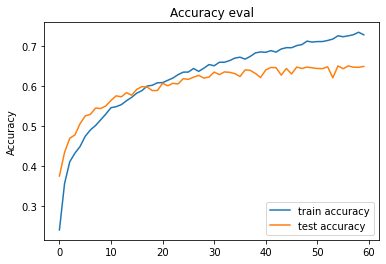

In [52]:
plot_accuracy(th_history)

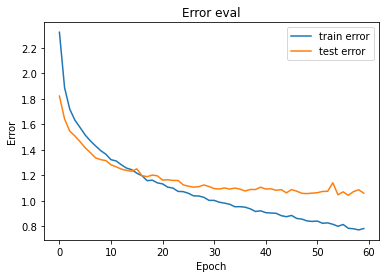

In [53]:
plot_loss(th_history)

## Continuation

In [65]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=60)

Epoch 1/60
459/459 [==============================] - 11s 24ms/step - loss: 0.7692 - accuracy: 0.7335 - val_loss: 1.0773 - val_accuracy: 0.6483
Epoch 2/60
459/459 [==============================] - 11s 25ms/step - loss: 0.7615 - accuracy: 0.7345 - val_loss: 1.0529 - val_accuracy: 0.6521
Epoch 3/60
459/459 [==============================] - 11s 25ms/step - loss: 0.7590 - accuracy: 0.7341 - val_loss: 1.0540 - val_accuracy: 0.6512
Epoch 4/60
459/459 [==============================] - 13s 27ms/step - loss: 0.7442 - accuracy: 0.7392 - val_loss: 1.0454 - val_accuracy: 0.6464
Epoch 5/60
459/459 [==============================] - 15s 33ms/step - loss: 0.7398 - accuracy: 0.7428 - val_loss: 1.0686 - val_accuracy: 0.6502
Epoch 6/60
459/459 [==============================] - 12s 27ms/step - loss: 0.7378 - accuracy: 0.7439 - val_loss: 1.0789 - val_accuracy: 0.6496
Epoch 7/60
459/459 [==============================] - 13s 28ms/step - loss: 0.7410 - accuracy: 0.7377 - val_loss: 1.0831 - val_accuracy:

## RNN-LSTM

In [54]:
th_lstm_model = keras.Sequential()

In [55]:
th_input_shape = (th_X_train.shape[1], th_X_train.shape[2]) ##

In [58]:
th_lstm_model.add(keras.layers.LSTM(64, input_shape=lstm_input_shape, return_sequences=True))
th_lstm_model.add(keras.layers.LSTM(64))

# dense layer
th_lstm_model.add(keras.layers.Dense(64, activation='relu'))
th_lstm_model.add(keras.layers.Dropout(0.3))

# output layer
th_lstm_model.add(keras.layers.Dense(11, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
th_lstm_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 11)                715       
                                                                 
Total params: 57,867
Trainable params: 57,867
Non-trainable params: 0
_________________________________________________________________


In [59]:
th_lstm_history = th_lstm_model.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=60)

Epoch 1/60
459/459 [==============================] - 30s 59ms/step - loss: 2.2262 - accuracy: 0.2126 - val_loss: 2.0044 - val_accuracy: 0.3288
Epoch 2/60
459/459 [==============================] - 27s 58ms/step - loss: 1.9464 - accuracy: 0.3256 - val_loss: 1.7990 - val_accuracy: 0.4064
Epoch 3/60
459/459 [==============================] - 27s 58ms/step - loss: 1.8071 - accuracy: 0.3720 - val_loss: 1.7017 - val_accuracy: 0.4248
Epoch 4/60
459/459 [==============================] - 27s 58ms/step - loss: 1.7211 - accuracy: 0.4069 - val_loss: 1.6409 - val_accuracy: 0.4461
Epoch 5/60
459/459 [==============================] - 27s 58ms/step - loss: 1.6533 - accuracy: 0.4278 - val_loss: 1.5898 - val_accuracy: 0.4642
Epoch 6/60
459/459 [==============================] - 27s 58ms/step - loss: 1.5977 - accuracy: 0.4508 - val_loss: 1.5531 - val_accuracy: 0.4712
Epoch 7/60
459/459 [==============================] - 27s 58ms/step - loss: 1.5523 - accuracy: 0.4702 - val_loss: 1.5260 - val_accuracy:

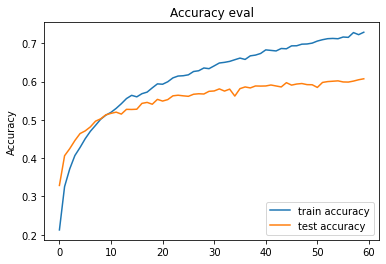

In [60]:
plot_accuracy(th_lstm_history)

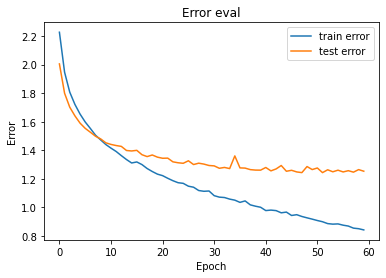

In [61]:
plot_loss(th_lstm_history)

## New CNN with one dimensional convolutional layer.

In [6]:
with open(TH_NEW_JSON_PATH, "r") as fp:
    conv1d_data = json.load(fp)

In [7]:
conv1d_inputs = np.array(conv1d_data["mfcc"])
conv1d_targets = np.array(conv1d_data["labels"])

conv1d_X_train, conv1d_X_test, conv1d_y_train, conv1d_y_test =  train_test_split(conv1d_inputs, conv1d_targets, test_size=0.3)
conv1d_X_test, conv1d_X_val, conv1d_y_test, conv1d_y_val = train_test_split(conv1d_X_test, conv1d_y_test, test_size=0.5)

conv1d_X_train.shape

# add an axis to input sets
conv1d_X_train = conv1d_X_train[..., np.newaxis]
conv1d_X_val = conv1d_X_val[..., np.newaxis]
conv1d_X_test = conv1d_X_test[..., np.newaxis]

conv1d_input_shape = (conv1d_X_train.shape[1], conv1d_X_train.shape[2], 1) ##

print(conv1d_input_shape)

(130, 13, 1)


In [8]:
DROPOUT_RATE = 0.5
CONV_DROPOUT_RATE = 0.2

In [18]:
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Input

In [17]:
# Create conv1d_model
conv1d_model =  keras.Sequential()

# First block
conv1d_model.add(Conv1D(filters=16,
                 kernel_size=3,
                 input_shape=conv1d_input_shape,
                 activation='relu',
                 padding='same'))
conv1d_model.add(Conv1D(filters=16,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
conv1d_model.add(MaxPooling1D(pool_size=2))
conv1d_model.add(Dropout(CONV_DROPOUT_RATE))

# Second block
conv1d_model.add(Conv1D(filters=32,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
conv1d_model.add(Conv1D(filters=32,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
conv1d_model.add(MaxPooling1D(pool_size=2))
conv1d_model.add(Dropout(CONV_DROPOUT_RATE))

# Third block
conv1d_model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
conv1d_model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))
conv1d_model.add(MaxPooling1D(pool_size=2))
conv1d_model.add(Dropout(CONV_DROPOUT_RATE))

# Fully connected layers
conv1d_model.add(Flatten())
conv1d_model.add(Dense(512, activation='relu'))
conv1d_model.add(Dense(512, activation='relu'))
conv1d_model.add(Dropout(DROPOUT_RATE))

# Output
conv1d_model.add(Dense(11, activation='softmax'))


NameError: name 'MaxPooling1D' is not defined

In [ ]:
conv1d_history = con1d_model.fit(conv1d_X_train, conv1d_y_train, validation_data=(conv1d_X_val, conv1d_y_val), batch_size=32, epochs=60)

## K-Nearest-Neighbor

In [ ]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [ ]:
#define a function to get distance between feature vectors and find neighbors
def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [ ]:
#function to identify the nearest neighbors
def nearestclass(neighbors):
    classVote = {}
    
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
            
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [ ]:
# define a function that will evaluate a model
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == prediction[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

In [ ]:
os.getcwd()

In [ ]:
import librosa, IPython
import librosa.display
file = './Data/genres_original/disco/disco.00031.wav'
signal, sr = librosa.load(file , sr = 22050) 
IPython.display.Audio(signal, rate=sr)

In [ ]:
directory = '/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/genres_original/'
f = open("my.dat", "wb")
i = 0
for folder in os.listdir(directory):
    #print(folder)
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+"/"+folder):
        #print(file)
        try:
            (rate, sig) = wav.read(directory+"/"+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print("Got an exception: ", e, 'in folder: ', folder, ' filename: ', file)
f.close()

In [ ]:
os.getcwd()

In [ ]:
#split dataset into train and test set
dataset = []

def loadDataset(filename, split, trset, teset):
    with open('my.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset('my.dat', 0.66, trainingSet, testSet)

In [ ]:
# Make the prediction using KNN(K nearest Neighbors)
length = len(testSet)
predictions = []
for x in range(length):
    predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

In [ ]:
from collections import defaultdict
results = defaultdict(int)

directory = "./Data/genres_original"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [ ]:
pred = nearestclass(getNeighbors(dataset, feature, 5))
print(pred)
print(results[pred])

In [ ]:
print(results)